<a href="https://colab.research.google.com/github/zeynepsldrk/TennisMoveClassification/blob/main/Makale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EĞİTİMLERE BAŞLAMADAN ÖNCE GEREKLİ VERİ HAZIRLIKLARI

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!pip install opencv-python mediapipe pandas


In [ ]:
import cv2
import mediapipe as mp
import os
import pandas as pd
import numpy as np

# MediaPipe Pose setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

# Video dizinleri
video_paths = [
    "/content/drive/MyDrive/makale tüm dosyalar/makale pdfleri/dataset-main/VIDEO_RGB"
]

# Çıktı dosyası
output_csv_path = "/content/drive/MyDrive/Sskeleton_keypoints.csv"
output_npy_path = "/content/drive/MyDrive/Sskeleton_5d_keypoints.npy"  # 5 boyutlu veriyi kaydedeceğimiz dosya

# Çıktılar için bir liste
all_keypoints = []

# Her video dizini için işlemler
for path in video_paths:
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".avi"):  # Sadece video dosyalarını işler
                video_path = os.path.join(root, file)
                print(f"Processing video: {video_path}")

                cap = cv2.VideoCapture(video_path)

                frame_index = 0
                video_keypoints = []

                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    # Yalnızca her 10. kareyi işle
                    if frame_index % 10 == 0:
                        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        results = pose.process(rgb_frame)

                        if results.pose_landmarks:
                            keypoints = []
                            for lm in results.pose_landmarks.landmark:
                                keypoints.append((lm.x, lm.y, lm.z))
                            video_keypoints.append({
                                "video_path": video_path,
                                "frame": frame_index,
                                "keypoints": keypoints
                            })

                    frame_index += 1

                cap.release()
                all_keypoints.extend(video_keypoints)

# Veriyi DataFrame'e çevir ve kaydet
df = pd.DataFrame(all_keypoints)
df.to_csv(output_csv_path, index=False)
print(f"Keypoints saved to: {output_csv_path}")

# 5. Adım: 5 Boyutlu Veriyi Hazırlama

# Veriyi NumPy array'e dönüştürme
num_keypoints = 33  # MediaPipe'den gelen 33 anahtar nokta
num_coordinates = 3  # x, y, z koordinatları
time_steps = 10  # Her 10. kareyi birleştiriyoruz

# Tüm keypoint'leri numpy array'e dönüştürme
X = np.array([video['keypoints'] for video in all_keypoints])  # all_keypoints'ten keypoint verisini al

# X array'inin boyutunu kontrol edelim
print("Original X shape:", X.shape)

# X array'inin boyutunu kontrol ettikten sonra zaman adımlarını uyarlayalım
num_frames = X.shape[0]  # Toplam kare sayısı

# Zaman adımlarını ve kareleri kontrol et
time_steps = 10  # İstediğiniz zaman adımı sayısını buradan değiştirebilirsiniz
frames_per_time_step = num_frames // time_steps

# Eğer zaman adımlarına göre tam bir bölünme yoksa, eksik olan kısmı keselim
X = X[:frames_per_time_step * time_steps]  # Zaman adımlarını tam hale getirmek için kesiyoruz

# X'i yeniden şekillendirelim
X_reshaped = X.reshape(-1, time_steps, num_keypoints, num_coordinates)

# 5 boyutlu veriyi kaydediyoruz
np.save(output_npy_path, X_reshaped)
print(f"5D Keypoints saved to: {output_npy_path}")


# 4. Adım: 5 Boyutlu Veriyi İşlemek ve Etiketlemek

# CSV dosyasını yükleyelim
data = pd.read_csv(output_csv_path)

# 1. 'keypoints' sütunundaki verilerin işlenmesi
def expand_keypoints(row):
    try:
        keypoints = ast.literal_eval(row)  # Keypoints sütununu bir listeye dönüştür
        flat_keypoints = [coord for point in keypoints for coord in point]  # x, y, z'yi birleştir
        return flat_keypoints
    except Exception as e:
        print(f"Hata oluştu: {e} -> {row}")  # Hata mesajını daha ayrıntılı şekilde yazdıralım
        return [np.nan] * (num_keypoints * 3)  # Hata durumunda NaN değerleri döndür

# keypoints sütununun örnek uzunluğunu (keypoint sayısını) bulalım
num_keypoints = len(ast.literal_eval(str(data['keypoints'].iloc[0])))  # ilk satırdan örnek al

# Anahtar noktaları sütunlara ayırmak için yeni sütun isimleri oluşturalım
keypoint_columns = [f"kp{i}_{axis}" for i in range(num_keypoints) for axis in ["x", "y", "z"]]

# 'keypoints' sütununu dönüştürüp yeni sütunlar ekleyelim
expanded_keypoints = data['keypoints'].apply(expand_keypoints)

# Yeni sütunları oluşturup, 'keypoints' sütununu kaldırarak veriyi genişletelim
keypoints_df = pd.DataFrame(expanded_keypoints.tolist(), columns=keypoint_columns)
data_expanded = pd.concat([data.drop(columns=['keypoints']), keypoints_df], axis=1)

# Verinin tamamını kaydedelim
output_full_path = "/content/drive/MyDrive/Sskeleton_data_expanded_full.csv"
data_expanded.to_csv(output_full_path, index=False)

print(f"Veri başarıyla kaydedildi: {output_full_path}")

# 5. Adım: Etiketleme

def label_data(file_path):
    # CSV dosyasını oku
    df = pd.read_csv(file_path)

    # 'video_path' sütununda 'backhand2h', 'serflat' ve 'foreflat' anahtar kelimelerine göre etiketleme yap
    df['label'] = df['video_path'].apply(lambda x: 0 if 'backhand2h' in x else (1 if 'serflat' in x else (2 if 'foreflat' in x else None)))

    # 'video_path' ve 'frame' sütunlarını kaldır
    df.drop(columns=['video_path', 'frame'], inplace=True)

    # Yeni dosyayı kaydet
    df.to_csv('/content/drive/MyDrive/Sskeleton_last_labeled_data.csv', index=False)
    print("Yeni etiketli dosya 'labeled_data.csv' olarak kaydedildi.")

# Dosya yolunu belirterek fonksiyonu çağır
label_data('/content/drive/MyDrive/Sskeleton_data_expanded_full.csv')


Processing video: /content/drive/MyDrive/makale tüm dosyalar/makale pdfleri/dataset-main/VIDEO_RGB/backhand2hands/p15_backhand2h_s3.avi
Processing video: /content/drive/MyDrive/makale tüm dosyalar/makale pdfleri/dataset-main/VIDEO_RGB/backhand2hands/p14_backhand2h_s1.avi
Processing video: /content/drive/MyDrive/makale tüm dosyalar/makale pdfleri/dataset-main/VIDEO_RGB/backhand2hands/p11_backhand2h_s2.avi
Processing video: /content/drive/MyDrive/makale tüm dosyalar/makale pdfleri/dataset-main/VIDEO_RGB/backhand2hands/p12_backhand2h_s3.avi
Processing video: /content/drive/MyDrive/makale tüm dosyalar/makale pdfleri/dataset-main/VIDEO_RGB/backhand2hands/p14_backhand2h_s2.avi
Processing video: /content/drive/MyDrive/makale tüm dosyalar/makale pdfleri/dataset-main/VIDEO_RGB/backhand2hands/p11_backhand2h_s3.avi
Processing video: /content/drive/MyDrive/makale tüm dosyalar/makale pdfleri/dataset-main/VIDEO_RGB/backhand2hands/p12_backhand2h_s2.avi
Processing video: /content/drive/MyDrive/

# Veri Arttırma

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Sskeleton_last_labeled_data.csv"
df = pd.read_csv(file_path)

print(df.columns)

df.columns = df.columns.str.strip()  # Sütun isimlerindeki boşlukları temizler
print(df.columns)

matching_columns = [col for col in df.columns if 'key' in col.lower()]
print(matching_columns)


Index(['kp0_x', 'kp0_y', 'kp0_z', 'kp1_x', 'kp1_y', 'kp1_z', 'kp2_x', 'kp2_y',
       'kp2_z', 'kp3_x', 'kp3_y', 'kp3_z', 'kp4_x', 'kp4_y', 'kp4_z', 'kp5_x',
       'kp5_y', 'kp5_z', 'kp6_x', 'kp6_y', 'kp6_z', 'kp7_x', 'kp7_y', 'kp7_z',
       'kp8_x', 'kp8_y', 'kp8_z', 'kp9_x', 'kp9_y', 'kp9_z', 'kp10_x',
       'kp10_y', 'kp10_z', 'kp11_x', 'kp11_y', 'kp11_z', 'kp12_x', 'kp12_y',
       'kp12_z', 'kp13_x', 'kp13_y', 'kp13_z', 'kp14_x', 'kp14_y', 'kp14_z',
       'kp15_x', 'kp15_y', 'kp15_z', 'kp16_x', 'kp16_y', 'kp16_z', 'kp17_x',
       'kp17_y', 'kp17_z', 'kp18_x', 'kp18_y', 'kp18_z', 'kp19_x', 'kp19_y',
       'kp19_z', 'kp20_x', 'kp20_y', 'kp20_z', 'kp21_x', 'kp21_y', 'kp21_z',
       'kp22_x', 'kp22_y', 'kp22_z', 'kp23_x', 'kp23_y', 'kp23_z', 'kp24_x',
       'kp24_y', 'kp24_z', 'kp25_x', 'kp25_y', 'kp25_z', 'kp26_x', 'kp26_y',
       'kp26_z', 'kp27_x', 'kp27_y', 'kp27_z', 'kp28_x', 'kp28_y', 'kp28_z',
       'kp29_x', 'kp29_y', 'kp29_z', 'kp30_x', 'kp30_y', 'kp30_z', 'kp31_x',

In [ ]:
import pandas as pd
import numpy as np

# Dosyanın yüklenmesi
file_path = "/content/drive/MyDrive/Sskeleton_last_labeled_data.csv"
df = pd.read_csv(file_path)

# Veri artırımı için fonksiyonlar
def add_noise(data, noise_level=0.02):
    """Veriye rastgele gürültü ekler."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def translate(data, shift=5):
    """Veriyi belirli bir miktarda öteleyerek artırır."""
    return data + shift

def flip_horizontal(data):
    """X koordinatlarını ters çevirerek yatay eksende aynalama yapar."""
    flipped_data = data.copy()
    flipped_data.iloc[:, ::2] = -flipped_data.iloc[:, ::2]  # X koordinatlarını ters çevir
    return flipped_data

# Sayısal veri sütunlarını al (etiket sütunu hariç)
data_columns = df.columns[:-1]
label_column = df.columns[-1]

# Orijinal veriyi kopyala
augmented_data = df.copy()

# Artırma sayısını 10 kat yapacak şekilde ayarla
augmentation_count = 9  # İlk veri orijinal olduğu için 9 kez daha artıracağız

# Veri artırımı işlemini bir döngüde yap
for _ in range(augmentation_count):
    # Gürültü ekleme
    noisy_data = df[data_columns].apply(add_noise)
    noisy_data[label_column] = df[label_column]  # Etiketleri koru

    # Öteleme
    translated_data = df[data_columns].apply(translate)
    translated_data[label_column] = df[label_column]

    # Aynalama
    flipped_data = flip_horizontal(df[data_columns])
    flipped_data[label_column] = df[label_column]

    # Yeni verileri birleştir
    augmented_data = pd.concat([augmented_data, noisy_data, translated_data, flipped_data], axis=0).reset_index(drop=True)

# Yeni veri setini kaydet
augmented_file_path = "/content/drive/MyDrive/Sskeleton_augmented_data.csv"
augmented_data.to_csv(augmented_file_path, index=False)

# Veri setinin yeni boyutunu yazdır
print(f"Veri artırımı tamamlandı. Yeni veri setinin satır sayısı: {augmented_data.shape[0]}")
print(f"Yeni dosya kaydedildi: {augmented_file_path}")


Veri artırımı tamamlandı. Yeni veri setinin satır sayısı: 115472
Yeni dosya kaydedildi: /content/drive/MyDrive/Sskeleton_augmented_data.csv


In [ ]:
import pandas as pd

# Orijinal ve artırılmış veri setlerinin yolları
original_file_path = "/content/drive/MyDrive/Sskeleton_last_labeled_data.csv"
augmented_file_path = "/content/drive/MyDrive/Sskeleton_augmented_data.csv"

# Veri setlerini yükleyelim
original_df = pd.read_csv(original_file_path)
augmented_df = pd.read_csv(augmented_file_path)

# Etiket sütununun adını belirleyelim
label_column = original_df.columns[-1]  # Son sütunun etiket olduğunu varsayıyoruz

# Orijinal veri setindeki etiket dağılımı
original_label_counts = original_df[label_column].value_counts().sort_index()

# Artırılmış veri setindeki etiket dağılımı
augmented_label_counts = augmented_df[label_column].value_counts().sort_index()

# Etiketlerin oranlarını hesapla
original_ratios = original_label_counts / len(original_df)
augmented_ratios = augmented_label_counts / len(augmented_df)

# Sonuçları yazdır
print("Orijinal veri setindeki etiket dağılımı:")
print(original_label_counts)
print("\nArtırılmış veri setindeki etiket dağılımı:")
print(augmented_label_counts)

print("\nOrijinal veri setindeki etiket oranları:")
print(original_ratios)
print("\nArtırılmış veri setindeki etiket oranları:")
print(augmented_ratios)

# Farkları analiz et
difference = augmented_ratios - original_ratios
print("\nEtiket dağılım farkları:")
print(difference)


Orijinal veri setindeki etiket dağılımı:
label
0    1358
1    1414
2    1352
Name: count, dtype: int64

Artırılmış veri setindeki etiket dağılımı:
label
0    38024
1    39592
2    37856
Name: count, dtype: int64

Orijinal veri setindeki etiket oranları:
label
0    0.329292
1    0.342871
2    0.327837
Name: count, dtype: float64

Artırılmış veri setindeki etiket oranları:
label
0    0.329292
1    0.342871
2    0.327837
Name: count, dtype: float64

Etiket dağılım farkları:
label
0    0.0
1    0.0
2    0.0
Name: count, dtype: float64


In [ ]:
import pandas as pd


# CSV dosyasını yükleme
file_path = "/content/drive/MyDrive/Sskeleton_balanced_scaled_data.csv"
df = pd.read_csv(file_path)

#  Veri tiplerini yazdır
print("🔹 Veri Tipleri:")
print(df.dtypes)

#  Eksik veri sayısı
print("\n🔹 Eksik Veri Sayısı:")
print(df.isnull().sum())

#  Sınıf dağılımını yazdır (Son sütunun 'label' olduğunu varsayarak)
if 'label' in df.columns:
    print("\n🔹 Sınıf Dağılımı:")
    print(df['label'].value_counts())
else:
    print("\n 'label' sütunu bulunamadı!")


🔹 Veri Tipleri:
kp0_x     float64
kp0_y     float64
kp0_z     float64
kp1_x     float64
kp1_y     float64
           ...   
kp31_z    float64
kp32_x    float64
kp32_y    float64
kp32_z    float64
label       int64
Length: 100, dtype: object

🔹 Eksik Veri Sayısı:
kp0_x     0
kp0_y     0
kp0_z     0
kp1_x     0
kp1_y     0
         ..
kp31_z    0
kp32_x    0
kp32_y    0
kp32_z    0
label     0
Length: 100, dtype: int64

🔹 Sınıf Dağılımı:
label
0    5656
2    5656
1    5656
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

#  1. Dosyanın Yüklenmesi
file_path = "/content/drive/MyDrive/Sskeleton_augmented_data.csv"
df = pd.read_csv(file_path)

#  2. Özellik ve Etiketleri Ayırma
X = df.iloc[:, :-1].values  # Son sütun hariç tüm özellikler
y = df.iloc[:, -1].values   # Son sütun (etiket)

#  3. SMOTE ile Veri Dengeleme
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#  4. Veriyi Ölçeklendirme (Etiketleri Hariç Tut)
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

#  5. Dengelenmiş ve Ölçeklendirilmiş Veriyi DataFrame'e Çevirme
df_balanced = pd.DataFrame(X_resampled_scaled, columns=df.columns[:-1])
df_balanced["label"] = y_resampled  # Etiket sütununu ekle

# 6. Dengelenmiş Veriyi Kaydetme
balanced_file_path = "/content/drive/MyDrive/Sskeleton_balanced_data.csv"
df_balanced.to_csv(balanced_file_path, index=False)

print(f" SMOTE ile dengelenmiş ve ölçeklendirilmiş veri başarıyla kaydedildi: {balanced_file_path}")


✅ SMOTE ile dengelenmiş ve ölçeklendirilmiş veri başarıyla kaydedildi: /content/drive/MyDrive/Sskeleton_balanced_data.csv


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#  1. Veriyi Yükleme
file_path = "/content/drive/MyDrive/Sskeleton_balanced_data.csv"
df = pd.read_csv(file_path)

#  2. Özellik ve Etiketleri Ayırma
X = df.iloc[:, :-1].values  # Son sütun hariç tüm özellikler
y = df.iloc[:, -1].values   # Son sütun (etiket)

#  3. MinMaxScaler ile Ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

#  4. Ölçeklendirilmiş Veriyi DataFrame'e Çevirme
df_scaled = pd.DataFrame(X_scaled, columns=df.columns[:-1])
df_scaled["label"] = y  # Etiket sütununu ekle

#  5. Ölçeklendirilmiş Veriyi Kaydetme
scaled_file_path = "/content/drive/MyDrive/Sskeleton_balanced_scaled_data.csv"
df_scaled.to_csv(scaled_file_path, index=False)

print(f" Ölçeklendirilmiş veri başarıyla kaydedildi: {scaled_file_path}")


✅ Ölçeklendirilmiş veri başarıyla kaydedildi: /content/drive/MyDrive/Sskeleton_balanced_scaled_data.csv


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive


#  2. Veri Setinin Yolunu Tanımlama
file_path = "/content/drive/MyDrive/Sskeleton_balanced_scaled_data.csv"

#  3. CSV Dosyasını Okuma
df = pd.read_csv(file_path)

#  4. Pencere Boyutu ve Özellik Sayısı
window_size = 33
num_joints = 33  # 33 eklem noktası
num_features = num_joints * 3  # Her eklem noktası için (x, y, z)

#  5. Veriyi NumPy Dizisine Çevirme
data = df.iloc[:, :-1].values  # Son sütun label, onu çıkardık
labels = df["label"].values  # Hareket etiketleri

#  6. Pencereleme (33 karelik pencere)
X_sequences = []
y_sequences = []

for i in range(len(data) - window_size):
    X_sequences.append(data[i : i + window_size])  # 33 karelik pencere
    y_sequences.append(labels[i + window_size - 1])  # Son kare etiketi

#  7. NumPy Dizilerine Çevirme
X_sequences = np.array(X_sequences)  # (num_samples, 33, 99)
y_sequences = np.array(y_sequences)  # (num_samples,)

#  8. 3D CNN için Yeniden Şekillendirme (num_samples, 33, 33, 3)
X_3D_CNN = X_sequences.reshape(-1, window_size, num_joints, 3)

#  9. Veriyi `.csv` formatında kaydetme
df_reshaped = X_3D_CNN.reshape(X_3D_CNN.shape[0], -1)  # 2D hale getir
df_final = pd.DataFrame(df_reshaped)
df_final["label"] = y_sequences  # Etiketleri ekle

# Google Drive içine kaydetme
csv_output_path = "/content/drive/MyDrive/Sskeleton_balanced_scaled_data_33frames.csv"
df_final.to_csv(csv_output_path, index=False)
print(f" CSV dosyası kaydedildi: {csv_output_path}")

#  10. Veriyi `.npy` formatında kaydetme
npy_output_X = "/content/drive/MyDrive/X_3D_CNN.npy"
npy_output_y = "/content/drive/MyDrive/y_labels.npy"

np.save(npy_output_X, X_3D_CNN)
np.save(npy_output_y, y_sequences)

print(f" NPY dosyaları kaydedildi:\n{npy_output_X}\n{npy_output_y}")

#  11. İşlemin Doğru Yapıldığını Kontrol Etme

# 1. Pencereleme ve etiketlerin eşleşip eşleşmediğini kontrol etme
print(f"Pencere sayısı: {len(X_sequences)}")
print(f"Etiket sayısı: {len(y_sequences)}")
assert len(X_sequences) == len(y_sequences), "Pencere sayısı ile etiket sayısı eşleşmiyor!"

# 2. 3D CNN için verinin doğru şekilde şekillendirildiğini kontrol etme
print(f"X_3D_CNN şekli: {X_3D_CNN.shape}")
assert X_3D_CNN.shape[1] == window_size, f"Pencere boyutu yanlış, beklenen: {window_size}, mevcut: {X_3D_CNN.shape[1]}"
assert X_3D_CNN.shape[2] == num_joints, f"Eklem sayısı yanlış, beklenen: {num_joints}, mevcut: {X_3D_CNN.shape[2]}"
assert X_3D_CNN.shape[3] == 3, "Koordinat sayısı (x, y, z) yanlış, beklenen: 3, mevcut: {X_3D_CNN.shape[3]}"

# 3. Verinin belirli bir örneğini kontrol etme
print(f"Örnek bir pencere (ilk pencere):\n{X_3D_CNN[0]}")  # İlk pencereyi yazdır
print(f"İlk etiket: {y_sequences[0]}")

# 4. CSV dosyasının doğru şekilde kaydedildiğini kontrol etme
loaded_csv = pd.read_csv(csv_output_path)
print(f"CSV dosyasının ilk satırları:\n{loaded_csv.head()}")

# 5. NPY dosyasının yüklenip doğru kaydedildiğini kontrol etme
loaded_X = np.load(npy_output_X)
loaded_y = np.load(npy_output_y)
print(f"Yüklenen X_3D_CNN şekli: {loaded_X.shape}")
print(f"Yüklenen etiket sayısı: {loaded_y.shape[0]}")


✅ CSV dosyası kaydedildi: /content/drive/MyDrive/Sskeleton_balanced_scaled_data_33frames.csv
✅ NPY dosyaları kaydedildi:
/content/drive/MyDrive/X_3D_CNN.npy
/content/drive/MyDrive/y_labels.npy
Pencere sayısı: 118743
Etiket sayısı: 118743
X_3D_CNN şekli: (118743, 33, 33, 3)
Örnek bir pencere (ilk pencere):
[[[0.19965399 0.04906518 0.10756478]
  [0.06693678 0.13455652 0.10692363]
  [0.20101039 0.04587876 0.1089981 ]
  ...
  [0.1865355  0.04629281 0.17979006]
  [0.0744079  0.2843623  0.106913  ]
  [0.18687956 0.05133612 0.15930464]]

 [[0.19502119 0.04957736 0.1179413 ]
  [0.06177733 0.13495153 0.11582414]
  [0.19667071 0.04631474 0.11787351]
  ...
  [0.18653535 0.04647032 0.18517309]
  [0.07440376 0.28433524 0.10944448]
  [0.18609016 0.05124153 0.16680232]]

 [[0.18584239 0.05588116 0.11439187]
  [0.05075091 0.14039091 0.10940948]
  [0.18721958 0.05224286 0.11147214]
  ...
  [0.18653999 0.04705896 0.21655528]
  [0.05632448 0.29055865 0.08489628]
  [0.1844022  0.05086491 0.20843206]]

 ..

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

# Etiketleri yükle
npy_output_y = "/content/drive/MyDrive/y_labels.npy"
y_sequences = np.load(npy_output_y)

# Sınıf dağılımını yazdır
label_counts = Counter(y_sequences)
print(" Sınıf Dağılımı:", label_counts)


📊 Sınıf Dağılımı: Counter({1: 39592, 2: 39591, 0: 39560})


In [ ]:
import numpy as np

# Veriyi yükleme
X = np.load("/content/drive/MyDrive/X_3D_CNN_reshaped.npy")
y = np.load("/content/drive/MyDrive/y_labels_reshaped.npy")

# Verinin şekline bakalım
print(f"X shape: {X.shape}")  # (num_samples, 33, 33, 3)
print(f"y shape: {y.shape}")  # (num_samples,)


X shape: (11874, 10, 33, 33, 3)
y shape: (11874, 10)


In [ ]:
import numpy as np

# Veriyi yükleme
X = np.load("/content/drive/MyDrive/X_3D_CNN.npy")

# Mevcut boyutu al
current_shape = X.shape
expected_dims = ["batch_size", "time_steps", "height", "width", "channels"]

# Beklenen 5 boyuttan hangisinin eksik olduğunu kontrol et
if len(current_shape) == 4:
    print(f"Mevcut veri boyutu: {current_shape} (4D)")
    print("Eksik boyut: 'time_steps' (Zaman adımı)")

elif len(current_shape) == 5:
    print(f"Mevcut veri boyutu: {current_shape} (5D)")
    print("Veri zaten 3D CNN için uygun!")

else:
    print(f"Beklenmeyen veri boyutu: {current_shape}!")


Mevcut veri boyutu: (118743, 33, 33, 3) (4D)
Eksik boyut: 'time_steps' (Zaman adımı)


In [ ]:
import numpy as np

#  Veriyi yükle
X = np.load("/content/drive/MyDrive/X_3D_CNN.npy")
y = np.load("/content/drive/MyDrive/y_labels.npy")

#  Time steps değeri
time_steps = 10  # Her 10 kare bir zaman dizisi olarak gruplandırılacak

#  NumPy dizisinin boyutunu kontrol et
num_samples = X.shape[0]  # 16935
height, width, channels = X.shape[1], X.shape[2], X.shape[3]  # (33, 33, 3)

#  Time steps ile tam bölünüp bölünmediğini kontrol et
if num_samples % time_steps != 0:
    new_num_samples = (num_samples // time_steps) * time_steps
    X = X[:new_num_samples]  # Fazla olan kareleri at
    y = y[:new_num_samples]  # Etiketleri de aynı şekilde düzenle

#  5D forma dönüştürme (batch_size, time_steps, height, width, channels)
X_reshaped = X.reshape(-1, time_steps, height, width, channels)
y_reshaped = y.reshape(-1, time_steps)  # Etiketleri de zaman serisi halinde düzenle

#  Düzenlenmiş verilerin boyutunu yazdır
print(f"Yeni X shape: {X_reshaped.shape}")  # (num_samples/time_steps, time_steps, 33, 33, 3)
print(f"Yeni y shape: {y_reshaped.shape}")  # (num_samples/time_steps, time_steps)

#  Verileri kaydet
np.save("/content/drive/MyDrive/X_3D_CNN_reshaped.npy", X_reshaped)
np.save("/content/drive/MyDrive/y_labels_reshaped.npy", y_reshaped)

print(" Düzenlenmiş veriler başarıyla kaydedildi!")


Yeni X shape: (11874, 10, 33, 33, 3)
Yeni y shape: (11874, 10)
✅ Düzenlenmiş veriler başarıyla kaydedildi!


# Hibrit model eğitimi

Orijinal X boyutları: (11874, 10, 33, 33, 3)
Orijinal y boyutları: (11874, 10)
Dönüştürülmüş y boyutları: (11874,)

Fold 1 işleniyor...
Epoch 1/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3709 - loss: 1.2702
Epoch 1: val_loss improved from inf to 1.30729, saving model to /content/drive/MyDrive/fold_1_best_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.3710 - loss: 1.2701 - val_accuracy: 0.3224 - val_loss: 1.3073
Epoch 2/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5355 - loss: 1.0750
Epoch 2: val_loss improved from 1.30729 to 0.91791, saving model to /content/drive/MyDrive/fold_1_best_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.5355 - loss: 1.0749 - val_accuracy: 0.5219 - val_loss: 0.9179
Epoch 3/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6089 - loss: 0.9464
Epoch 3: val_loss improved from 0.91791 to 0.74072, saving model to /content/drive/MyDrive/fold_1_best_model.keras
334/334 ━━━━━━━━━━━━━━━━

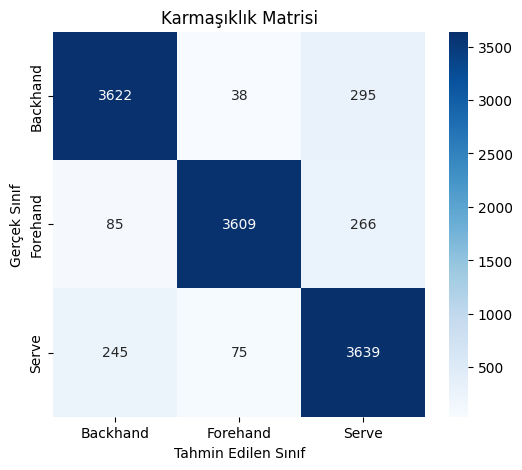

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, BatchNormalization,
                                     Flatten, LSTM, Dense, Dropout, Reshape)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# 1. VERİLERİN YÜKLENMESİ VE HAZIRLANMASI
# =============================================================================

# X verisini yükleyin: Beklenen boyut: (num_groups, time_steps, height, width, channels)
X = np.load("/content/drive/MyDrive/X_3D_CNN_reshaped.npy")
# y verisini yükleyin: İlk hali (num_groups, time_steps)
y = np.load("/content/drive/MyDrive/y_labels_reshaped.npy")

# Orijinal veri boyutlarını yazdır
print("Orijinal X boyutları:", X.shape)  # Örnek çıktı: (1693, 10, 33, 33, 3)
print("Orijinal y boyutları:", y.shape)  # Örnek çıktı: (1693, 10)

# Eğer y verisi her sekans için 10 etiket içeriyorsa, her sekansın
# son etiketini alarak y verisini (num_groups,) boyutuna indiriyoruz.
if y.ndim == 2 and y.shape[1] > 1:
    y = y[:, -1]
print("Dönüştürülmüş y boyutları:", y.shape)  # Beklenen çıktı: (1693,)

# =============================================================================
# 2. 3D MODEL MİMARİSİNİN OLUŞTURULMASI
# =============================================================================

def create_3d_model(input_shape, num_classes):
    """
    Bu fonksiyon, verilen input_shape (time_steps, height, width, channels)
    ve num_classes (örneğin, 3) parametrelerine göre 3D bir model oluşturur.
    Model, her zaman adımındaki (frame) görüntüden 3D özellik çıkarıp,
    sonrasında LSTM ile zamansal ilişkileri modelleyerek her sekans için
    tek bir tahmin (output shape: (None, num_classes)) üretir.
    """
    model = Sequential()

    # İlk katman olarak Input eklenir
    model.add(Input(shape=input_shape))

    # 3D konvolüsyon işlemleri yapılır.
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    # 5D çıktıyı 3D'ye dönüştürmek için Reshape ekleniyor.
    model.add(Reshape((-1, 128)))  # Bu katman, veriyi 3D hale getirir.

    # LSTM katmanı
    model.add(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))

    # Çıkış katmanı: softmax aktivasyon ile num_classes tahmini yapar.
    model.add(Dense(num_classes, activation='softmax'))

    # Tamsayı etiketler kullandığımız için sparse_categorical_crossentropy kullanılır.
    model.compile(optimizer=Adam(learning_rate=0.00001),  # Öğrenme oranını düşürdük
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# =============================================================================
# 3. K-FOLD CROSS VALIDATION VE MODEL EĞİTİMİ
# =============================================================================

kf = KFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc_roc': [],
}

y_true_all, y_pred_all = [], []

fold_no = 1
for train_index, val_index in kf.split(X):
    print(f'\nFold {fold_no} işleniyor...')

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    class_weights = {0: 1.0, 1: 1.0, 2: 1.5}

    # Model her fold için yeniden oluşturulur.
    model = create_3d_model(input_shape=X_train.shape[1:], num_classes=3)

    # EarlyStopping ve ModelCheckpoint kullanımı
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/fold_1_best_model.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)


    # Modeli eğitiyoruz.
    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=[ model_checkpoint],
        verbose=1
    )

    # Doğrulama seti üzerinde tahmin yapıyoruz.
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    auc = None
    try:
        y_val_onehot = np.eye(3)[y_val]
        if len(np.unique(y_val)) > 1:
            auc = roc_auc_score(y_val_onehot, y_pred, multi_class='ovr', average='macro')
        else:
            print("Uyarı: Yalnızca bir sınıf bulundu. AUC hesaplanamaz.")
    except ValueError as e:
        print(f"Uyarı: AUC hesaplanamadı: {e}")

    prec = precision_score(y_val, y_pred_classes, average='weighted', zero_division=0)
    rec = recall_score(y_val, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred_classes, average='weighted', zero_division=0)

    metrics['accuracy'].append(accuracy_score(y_val, y_pred_classes))
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    if auc is not None:
        metrics['auc_roc'].append(auc)

    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred_classes)

    print(f"Fold {fold_no} - Accuracy: {metrics['accuracy'][-1]:.4f}, "
          f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, "
          f"AUC-ROC: {auc if auc is not None else 'NaN'}")

    fold_no += 1

# =============================================================================
# 4. ORTALAMA METRİKLERİN HESAPLANMASI VE SONUÇLARIN KAYDEDİLMESİ
# =============================================================================

avg_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
print("\nOrtalama Sonuçlar:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

df_results = pd.DataFrame(metrics)
df_results.to_csv("/content/drive/MyDrive/NO_3D_CNN_LSTM_kfold_results.csv", index=False)

# =============================================================================
# 5. KARMAŞIKLIK MATRİSİNİN HESAPLANMASI VE GÖRSELLEŞTİRİLMESİ
# =============================================================================

conf_matrix = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Backhand", "Forehand", "Serve"],
            yticklabels=["Backhand", "Forehand", "Serve"])
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()


Orijinal X boyutları: (11874, 10, 33, 33, 3)
Orijinal y boyutları: (11874, 10)
Dönüştürülmüş y boyutları: (11874,)

Fold 1 işleniyor...
Epoch 1/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3756 - loss: 1.2502
Epoch 1: val_loss improved from inf to 1.04672, saving model to /content/drive/MyDrive/fold_1_best_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.3757 - loss: 1.2501 - val_accuracy: 0.6103 - val_loss: 1.0467
Epoch 2/15
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5843 - loss: 1.0675
Epoch 2: val_loss improved from 1.04672 to 0.80642, saving model to /content/drive/MyDrive/fold_1_best_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5846 - loss: 1.0672 - val_accuracy: 0.7618 - val_loss: 0.8064
Epoch 3/15
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7440 - loss: 0.8303
Epoch 3: val_loss improved from 0.80642 to 0.59318, saving model to /content/drive/MyDrive/fold_1_best_model.keras
334/334 ━━━━━━━━━━━━━━━━━

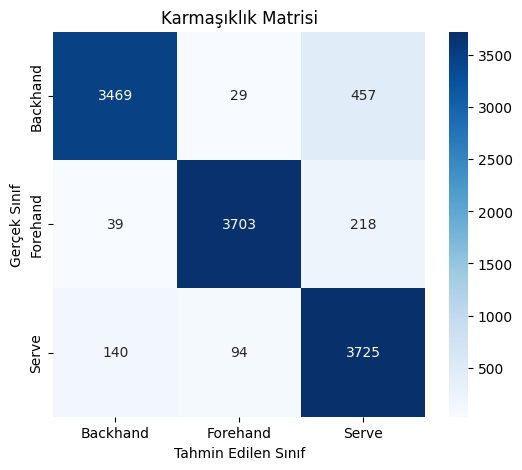

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, BatchNormalization,
                                     Flatten, LSTM, Dense, Dropout, Reshape)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix)
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# 1. VERİLERİN YÜKLENMESİ VE HAZIRLANMASI
# =============================================================================

# X verisini yükleyin: Beklenen boyut: (num_groups, time_steps, height, width, channels)
X = np.load("/content/drive/MyDrive/X_3D_CNN_reshaped.npy")
# y verisini yükleyin: İlk hali (num_groups, time_steps)
y = np.load("/content/drive/MyDrive/y_labels_reshaped.npy")

# Orijinal veri boyutlarını yazdır
print("Orijinal X boyutları:", X.shape)  # Örnek çıktı: (1693, 10, 33, 33, 3)
print("Orijinal y boyutları:", y.shape)  # Örnek çıktı: (1693, 10)

# Eğer y verisi her sekans için 10 etiket içeriyorsa, her sekansın
# son etiketini alarak y verisini (num_groups,) boyutuna indiriyoruz.
if y.ndim == 2 and y.shape[1] > 1:
    y = y[:, -1]
print("Dönüştürülmüş y boyutları:", y.shape)  # Beklenen çıktı: (1693,)

# =============================================================================
# 2. MODEL MİMARİSİNİN OLUŞTURULMASI
# =============================================================================

def create_3d_model(input_shape, num_classes):
    """
    Bu fonksiyon, verilen input_shape (time_steps, height, width, channels)
    ve num_classes (örneğin, 3) parametrelerine göre 3D CNN - LSTM hibrit modeli oluşturur.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))

    # 3D konvolüsyon işlemleri
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(BatchNormalization())

    # 5D çıktıyı 3D'ye dönüştürmek için Reshape katmanı.
    model.add(Reshape((-1, 128)))

    # LSTM katmanı
    model.add(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))

    # Çıkış katmanı: softmax aktivasyon ile num_classes tahmini yapar.
    model.add(Dense(num_classes, activation='softmax'))

    # Tamsayı etiketler kullandığımız için sparse_categorical_crossentropy kullanılır.
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# =============================================================================
# 3. K-FOLD CROSS VALIDATION, PCA İLE ÖZ NİTELİK SEÇİMİ VE MODEL EĞİTİMİ
# =============================================================================

kf = KFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc_roc': [],
}

y_true_all, y_pred_all = [], []

# PCA parametreleri:
# Her frame orijinal boyutu: (33, 33, 3) => 33*33*3 = 3267
# PCA sonrasında n_components kadar özellik seçiyoruz, örneğin 64.
# Bu örnekte 64 bileşeni kare (8x8) formatında geri yerleştireceğiz.
n_components = 128
pca_target_shape = (8, 16, 1)  # 8 * 16 * 1 = 128


fold_no = 1
for train_index, val_index in kf.split(X):
    print(f'\nFold {fold_no} işleniyor...')

    # Bölünmüş veriler
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # --- PCA İle ÖZ NİTELİK SEÇİMİ ---
    # Her frame'i flatten edip PCA’ya sokacağız.
    num_train, time_steps, h, w, c = X_train.shape
    num_val = X_val.shape[0]

    # Eğitim verisini (num_train*time_steps, h*w*c) şeklinde yeniden şekillendir.
    X_train_reshaped = X_train.reshape(-1, h*w*c)
    # PCA’yı eğitim verisi üzerinde fit ediyoruz.
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_reshaped)
    # PCA çıktısını (num_train, time_steps, pca_target_shape) şeklinde düzenliyoruz.
    X_train_pca = X_train_pca.reshape(num_train, time_steps, *pca_target_shape)

    # Doğrulama verisi için de aynı dönüşümü PCA parametreleri kullanarak uyguluyoruz.
    X_val_reshaped = X_val.reshape(-1, h*w*c)
    X_val_pca = pca.transform(X_val_reshaped)
    X_val_pca = X_val_pca.reshape(num_val, time_steps, *pca_target_shape)

    # Modelin giriş boyutu artık (time_steps, 8, 8, 1) şeklindedir.
    input_shape = X_train_pca.shape[1:]
    num_classes = 3  # Sınıf sayısı
    model = create_3d_model(input_shape=input_shape, num_classes=num_classes)

    # Ağırlıklandırma (örnekte sınıf 2 için hafif daha yüksek ağırlık)
    class_weights = {0: 1.0, 1: 1.0, 2: 1.5}

    # Erken durdurma ve model kaydetme callback'leri (ModelCheckpoint örneğinde fold numarasını kullanabilirsiniz)
    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/fold_{fold_no}_best_model.keras',
                                         monitor='val_loss',
                                         save_best_only=True,
                                         verbose=1)

    # Modeli eğitiyoruz.
    history = model.fit(
        X_train_pca, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_val_pca, y_val),
        class_weight=class_weights,
        callbacks=[model_checkpoint],
        verbose=1
    )

    # Doğrulama seti üzerinde tahmin yapıyoruz.
    y_pred = model.predict(X_val_pca)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # AUC-ROC hesaplama (sadece birden fazla sınıf varsa)
    auc = None
    try:
        y_val_onehot = np.eye(num_classes)[y_val]
        if len(np.unique(y_val)) > 1:
            auc = roc_auc_score(y_val_onehot, y_pred, multi_class='ovr', average='macro')
        else:
            print("Uyarı: Yalnızca bir sınıf bulundu. AUC hesaplanamaz.")
    except ValueError as e:
        print(f"Uyarı: AUC hesaplanamadı: {e}")

    prec = precision_score(y_val, y_pred_classes, average='weighted', zero_division=0)
    rec = recall_score(y_val, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred_classes, average='weighted', zero_division=0)

    metrics['accuracy'].append(accuracy_score(y_val, y_pred_classes))
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    if auc is not None:
        metrics['auc_roc'].append(auc)

    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred_classes)

    print(f"Fold {fold_no} - Accuracy: {metrics['accuracy'][-1]:.4f}, "
          f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, "
          f"AUC-ROC: {auc if auc is not None else 'NaN'}")

    fold_no += 1

# =============================================================================
# 4. ORTALAMA METRİKLERİN HESAPLANMASI VE SONUÇLARIN KAYDEDİLMESİ
# =============================================================================

avg_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
print("\nOrtalama Sonuçlar:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

df_results = pd.DataFrame(metrics)
df_results.to_csv("/content/drive/MyDrive/PCA_3D_CNN_LSTM_kfold_results.csv", index=False)

# =============================================================================
# 5. KARMAŞIKLIK MATRİSİNİN HESAPLANMASI VE GÖRSELLEŞTİRİLMESİ
# =============================================================================

conf_matrix = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Backhand", "Forehand", "Serve"],
            yticklabels=["Backhand", "Forehand", "Serve"])
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()


In [ ]:
!pip uninstall -y pandas
!pip install --no-cache-dir --upgrade pandas numpy tensorflow


Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 156.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 236.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 287.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 307.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
thinc 8.2.5 requires numpy<2.0.0,>=1.19.0; python_version >= "3.9", b

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================================
# 1. VERİLERİN YÜKLENMESİ VE HAZIRLANMASI
# =============================================================================

# X verisini yükleyin: Beklenen boyut: (num_groups, time_steps, height, width, channels)
X = np.load("/content/drive/MyDrive/X_3D_CNN_reshaped.npy")
# y verisini yükleyin: İlk hali (num_groups, time_steps)
y = np.load("/content/drive/MyDrive/y_labels_reshaped.npy")

# Orijinal veri boyutlarını yazdır
print("Orijinal X boyutları:", X.shape)  # Örnek çıktı: (1693, 10, 33, 33, 3)
print("Orijinal y boyutları:", y.shape)  # Örnek çıktı: (1693, 10)

# Eğer y verisi her sekans için 10 etiket içeriyorsa, her sekansın son etiketini alıyoruz.
if y.ndim == 2 and y.shape[1] > 1:
    y = y[:, -1]
print("Dönüştürülmüş y boyutları:", y.shape)  # Beklenen çıktı: (1693,)

# (İsteğe bağlı) Gerekliyse verileri normalize edebilirsiniz.
# Örneğin, eğer görüntü değerleriniz 0-255 arasındaysa:
X = X.astype('float32') / 255.0

# =============================================================================
# 2. MODEL MİMARİSİNİN OLUŞTURULMASI (LSTM tabanlı model)
# =============================================================================
def create_lda_model(input_shape, num_classes):
    """
    Bu fonksiyon, LDA ile indirgenmiş özellikleri (time_steps, n_features) giriş alan,
    LSTM kullanarak sınıflandırma yapan basit bir modeli oluşturur.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))

    # LSTM katmanı: time_steps boyunca ilişkileri öğrenir.
    model.add(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))

    # Çıkış katmanı: softmax ile sınıf tahmini.
    model.add(Dense(num_classes, activation='softmax'))

    # Derleme: Tamsayı etiketler için sparse_categorical_crossentropy kullanılıyor.
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# =============================================================================
# 3. K-FOLD CROSS VALIDATION, LDA İLE ÖZ NİTELİK SEÇİMİ VE MODEL EĞİTİMİ
# =============================================================================

kf = KFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc_roc': [],
}

y_true_all, y_pred_all = [], []

# LDA için ayarlar:
# Orijinal her frame boyutu: (33, 33, 3) => 33*33*3 = 3267 özellik
# LDA maksimum (n_classes - 1) bileşen üretebilir. 3 sınıf için n_components = 2.
n_components = 2

fold_no = 1
for train_index, val_index in kf.split(X):
    print(f'\nFold {fold_no} işleniyor...')

    # Bölünmüş veriler
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # --- LDA ile Öz Nitelik Seçimi ---
    # X_train: (num_train, time_steps, h, w, c)
    num_train, time_steps, h, w, c = X_train.shape
    num_val = X_val.shape[0]

    # Her frame'i flatten ediyoruz: (num_train*time_steps, h*w*c)
    X_train_reshaped = X_train.reshape(-1, h * w * c)
    # Her frame'in etiketi, video etiketi ile aynı kabul ediliyor:
    y_train_repeated = np.repeat(y_train, time_steps)

    # LDA'yı eğitim verisi üzerinde fit ediyoruz.
    lda = LDA(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train_reshaped, y_train_repeated)

    # LDA çıktısı: (num_train*time_steps, n_components)
    # Her video için tekrar şekillendiriyoruz: (num_train, time_steps, n_components)
    X_train_lda = X_train_lda.reshape(num_train, time_steps, n_components)

    # Doğrulama verisi için aynı dönüşümü uyguluyoruz.
    X_val_reshaped = X_val.reshape(-1, h * w * c)
    X_val_lda = lda.transform(X_val_reshaped)
    X_val_lda = X_val_lda.reshape(num_val, time_steps, n_components)

    # Modelin giriş boyutu artık (time_steps, n_components) yani (10, 2) olacaktır.
    input_shape = X_train_lda.shape[1:]
    num_classes = 3  # Sınıf sayısı
    model = create_lda_model(input_shape=input_shape, num_classes=num_classes)

    # Sınıf ağırlıkları (örnekte, sınıf 2 için hafif daha yüksek ağırlık veriliyor)
    class_weights = {0: 1.0, 1: 1.0, 2: 1.5}

    # Callback: Erken durdurma veya model kaydetme isteğe bağlı eklenebilir.
    model_checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/fold_{fold_no}_best_model.keras',
                                         monitor='val_loss',
                                         save_best_only=True,
                                         verbose=1)

    # Modeli eğitiyoruz.
    history = model.fit(
        X_train_lda, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_val_lda, y_val),
        class_weight=class_weights,
        callbacks=[model_checkpoint],
        verbose=1
    )

    # Doğrulama seti üzerinde tahmin yapıyoruz.
    y_pred = model.predict(X_val_lda)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # AUC-ROC hesaplama (birden fazla sınıf varsa)
    auc = None
    try:
        y_val_onehot = np.eye(num_classes)[y_val]
        if len(np.unique(y_val)) > 1:
            auc = roc_auc_score(y_val_onehot, y_pred, multi_class='ovr', average='macro')
        else:
            print("Uyarı: Yalnızca bir sınıf bulundu. AUC hesaplanamaz.")
    except ValueError as e:
        print(f"Uyarı: AUC hesaplanamadı: {e}")

    prec = precision_score(y_val, y_pred_classes, average='weighted', zero_division=0)
    rec = recall_score(y_val, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred_classes, average='weighted', zero_division=0)

    metrics['accuracy'].append(accuracy_score(y_val, y_pred_classes))
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)
    if auc is not None:
        metrics['auc_roc'].append(auc)

    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred_classes)

    print(f"Fold {fold_no} - Accuracy: {metrics['accuracy'][-1]:.4f}, "
          f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, "
          f"AUC-ROC: {auc if auc is not None else 'NaN'}")

    fold_no += 1

# =============================================================================
# 4. ORTALAMA METRİKLERİN HESAPLANMASI VE SONUÇLARIN KAYDEDİLMESİ
# =============================================================================

avg_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
print("\nOrtalama Sonuçlar:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

df_results = pd.DataFrame(metrics)
df_results.to_csv("/content/drive/MyDrive/LDA_3D_CNN_LSTM_kfold_results.csv", index=False)

# =============================================================================
# 5. KARMAŞIKLIK MATRİSİNİN HESAPLANMASI VE GÖRSELLEŞTİRİLMESİ
# =============================================================================

conf_matrix = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Backhand", "Forehand", "Serve"],
            yticklabels=["Backhand", "Forehand", "Serve"])
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()


Orijinal X boyutları: (11874, 10, 33, 33, 3)
Orijinal y boyutları: (11874, 10)
Dönüştürülmüş y boyutları: (11874,)

Fold 1 işleniyor...


# MAKİNE ÖĞRENİMİ


In [ ]:
import numpy as np
import pandas as pd

# Makine öğrenmesi modülleri
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Multioutput için
from sklearn.multioutput import MultiOutputClassifier

# Metrik modülleri
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

# Model kopyalamak için
from sklearn.base import clone

# -----------------------------
# Veri Yükleme ve Hazırlama
# -----------------------------
x_path = "/content/drive/MyDrive/X_3D_CNN_reshaped.npy"
y_path = "/content/drive/MyDrive/y_labels_reshaped.npy"

# Verileri yükleyelim
X = np.load(x_path)
y = np.load(y_path)

# Eğer veriler 3 boyutlu ise ve modellerin kabul edeceği 2B formata getirmek gerekiyorsa:
X = X.reshape(X.shape[0], -1)

# -----------------------------
# Modellerin Tanımlanması
# -----------------------------
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Uygulanacak dönüşüm stratejileri:
# "None": hiçbir boyut indirgeme uygulanmaz,
# "PCA": PCA ile, verinin %95 varyansı korunarak boyut indirgeme,
# "LDA": LDA ile, etiket bilgisini kullanarak boyut indirgeme
transformations = {
    "None": None,
    "PCA": PCA(n_components=0.95, random_state=42),
    "LDA": LDA()  # LDA, sınıf sayısına bağlı olarak n_components belirler.
}

# -----------------------------
# Yardımcı Fonksiyonlar
# -----------------------------
def compute_confusion_metrics(y_true, y_pred):
    """
    İkili sınıflandırmada confusion matrix'den sensitivity (TPR) ve specificity (TNR) hesaplar.
    Varsayım: y_true ve y_pred binary değerler içeriyor.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity, specificity

def evaluate_metrics(y_true, y_pred, y_prob=None):
    """
    Eğer y_true tek boyutlu ise doğrudan metrikleri hesaplar.
    Çoklu çıktı (multioutput) durumunda, her kolon için metrik hesaplanıp ortalaması alınır.
    """
    # Eğer tek çıktıysa:
    if y_true.ndim == 1:
        acc = accuracy_score(y_true, y_pred)
        sensitivity, specificity = compute_confusion_metrics(y_true, y_pred)
        f_measure = f1_score(y_true, y_pred)
        auc = None
        if y_prob is not None:
            try:
                auc = roc_auc_score(y_true, y_prob)
            except Exception:
                auc = None
        return acc, sensitivity, specificity, f_measure, auc
    else:
        n_outputs = y_true.shape[1]
        acc_list, sens_list, spec_list, f1_list, auc_list = [], [], [], [], []
        for i in range(n_outputs):
            acc_list.append(accuracy_score(y_true[:, i], y_pred[:, i]))
            sens, spec = compute_confusion_metrics(y_true[:, i], y_pred[:, i])
            sens_list.append(sens)
            spec_list.append(spec)
            f1_list.append(f1_score(y_true[:, i], y_pred[:, i]))
            # AUC ROC: yalnızca y_prob sağlanırsa hesaplanır.
            if y_prob is not None:
                try:
                    auc_i = roc_auc_score(y_true[:, i], y_prob[i][:, 1])
                except Exception:
                    auc_i = None
                if auc_i is not None:
                    auc_list.append(auc_i)
        avg_auc = np.mean(auc_list) if auc_list else None
        return np.mean(acc_list), np.mean(sens_list), np.mean(spec_list), np.mean(f1_list), avg_auc

# -----------------------------
# Ana Eğitim & Değerlendirme Döngüsü
# -----------------------------
results = {}  # Sonuçları saklamak için

# Çoklu etiket (multioutput) problemleri için, stratifiye yapılamadığı için KFold kullanıyoruz.
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Her dönüşüm stratejisi için:
for trans_name, transformer in transformations.items():
    results[trans_name] = {}

    # Her model için:
    for model_name, model in models.items():
        fold_accuracies = []
        fold_sensitivities = []
        fold_specificities = []
        fold_f_measures = []
        fold_auc_rocs = []

        # Her fold için:
        for train_index, test_index in cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Ölçeklendirme (StandardScaler)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Uygulanan dönüşüm varsa (PCA veya LDA):
            if transformer is not None:
                # Her fold için transformer'ı yeniden oluşturmak daha doğru.
                if trans_name == "PCA":
                    trans = PCA(n_components=0.95, random_state=42)
                    X_train = trans.fit_transform(X_train)
                    X_test = trans.transform(X_test)
                elif trans_name == "LDA":
                    trans = LDA()
                    # LDA, etiket bilgisine ihtiyaç duyar.
                    X_train = trans.fit_transform(X_train, y_train if y_train.ndim==1 else y_train[:,0])
                    X_test = trans.transform(X_test)

            # Eğer çoklu etiket (multioutput) varsa, bazı modellerin bu desteği yoktur.
            # Bu durumda, tüm modelleri MultiOutputClassifier ile sarmalıyoruz.
            if y.ndim > 1 and y.shape[1] > 1:
                clf = MultiOutputClassifier(clone(model))
            else:
                clf = clone(model)

            # Modeli eğitelim
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            # AUC ROC için tahmin olasılıklarını almaya çalışalım (varsa)
            y_prob = None
            try:
                # Eğer multioutput ise, MultiOutputClassifier.predict_proba dönen liste verir.
                if hasattr(clf, "predict_proba"):
                    if y.ndim > 1 and y.shape[1] > 1:
                        y_prob = clf.predict_proba(X_test)  # Bu, her çıktı için bir liste döner.
                    else:
                        y_prob = clf.predict_proba(X_test)[:, 1]
                elif hasattr(clf, "decision_function"):
                    y_prob = clf.decision_function(X_test)
            except Exception:
                y_prob = None

            # Eğer y_test çoklu etiketliyse, y_pred'nin de aynı forma sahip olduğundan emin olalım.
            # Bazı durumlarda predict metodu 1D dönebilir.
            if y.ndim > 1 and y_pred.ndim == 1:
                y_pred = y_pred.reshape(-1, 1)

            # Metrikleri hesaplayalım
            acc, sens, spec, f_measure, auc = evaluate_metrics(y_test, y_pred, y_prob)
            fold_accuracies.append(acc)
            fold_sensitivities.append(sens)
            fold_specificities.append(spec)
            fold_f_measures.append(f_measure)
            if auc is not None:
                fold_auc_rocs.append(auc)

        avg_auc = np.mean(fold_auc_rocs) if fold_auc_rocs else None
        results[trans_name][model_name] = {
            'Accuracy': np.mean(fold_accuracies),
            'Sensitivity': np.mean(fold_sensitivities),
            'Specificity': np.mean(fold_specificities),
            'F-Measure': np.mean(fold_f_measures),
            'AUC ROC': avg_auc
        }

# -----------------------------
# Sonuçların CSV'ye Kaydedilmesi
# -----------------------------
all_results = []
for trans_name, models_dict in results.items():
    for model_name, metrics in models_dict.items():
        row = {"Transformation": trans_name, "Model": model_name}
        row.update(metrics)
        all_results.append(row)

df_results = pd.DataFrame(all_results)
output_file = "/content/drive/MyDrive/model_evaluation_results.csv"
df_results.to_csv(output_file, index=False)

print(f"Sonuçlar '{output_file}' dosyasına kaydedildi.")


In [ ]:
import numpy as np
import pandas as pd

# Makine öğrenmesi modülleri
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrik modülleri
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

# Model kopyalamak için
from sklearn.base import clone

# Verilerin yolu
x_path = "/content/drive/MyDrive/X_3D_CNN_reshaped.npy"
y_path = "/content/drive/MyDrive/y_labels_reshaped.npy"

# Veriyi yükleyelim
X = np.load(x_path)
y = np.load(y_path)

# Eğer veriler 3 boyutlu ise (örneğin; görüntü, video vb.) ve modellerin kabul edeceği 2B formata dönüştürmek gerekiyorsa,
# aşağıdaki satır ile reshape edebilirsiniz:
# X = X.reshape(X.shape[0], -1)

# Modelleri tanımlıyoruz
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Uygulanacak ön işleme stratejileri
# 'None': Boyut indirgeme yapmadan,
# 'PCA': PCA ile boyut indirgeme (açıklanan varyansın %95’i korunur),
# 'LDA': LDA ile boyut indirgeme (etiket bilgisine bağlı)
transformations = {
    "None": None,
    "PCA": PCA(n_components=0.95, random_state=42),
    "LDA": LDA()  # LDA, sınıf sayısına bağlı olarak n_components ayarlar (ikili sınıflandırmada n_components=1 olur)
}

# Sonuçları saklamak için bir sözlük oluşturuyoruz
results = {}

# 5-fold stratifiye çapraz doğrulama
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Her bir dönüşüm stratejisi için:
for trans_name, transformer in transformations.items():
    results[trans_name] = {}  # Örneğin: results["PCA"] = { ... }

    # Her model için:
    for model_name, model in models.items():
        fold_accuracies = []
        fold_sensitivities = []
        fold_specificities = []
        fold_f_measures = []
        fold_auc_rocs = []

        # Çapraz doğrulama fold’ları
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Öncelikle StandardScaler ile ölçeklendirme (hem PCA hem de LDA daha iyi sonuç verir)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Eğer bir dönüşüm (PCA veya LDA) uygulanacaksa:
            if transformer is not None:
                # Her fold’da transformer’ı yeniden tanımlamak en temiz yaklaşımdır.
                if trans_name == "PCA":
                    trans = PCA(n_components=0.95, random_state=42)
                    X_train = trans.fit_transform(X_train)
                    X_test = trans.transform(X_test)
                elif trans_name == "LDA":
                    trans = LDA()
                    # LDA fit ederken etiket bilgisine ihtiyaç duyar.
                    X_train = trans.fit_transform(X_train, y_train)
                    X_test = trans.transform(X_test)

            # Modeli fold için yeniden oluşturuyoruz (clone kullanarak global nesnenin etkilenmesini önleriz)
            clf = clone(model)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            # Accuracy
            acc = accuracy_score(y_test, y_pred)
            fold_accuracies.append(acc)

            # Confusion Matrix'den sensitivity (TPR) ve specificity (TNR) hesaplama (ikili sınıflandırma varsayımıyla)
            # Confusion Matrix formatı: [[TN, FP], [FN, TP]]
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
            fold_sensitivities.append(sensitivity)
            fold_specificities.append(specificity)

            # F-Measure (F1 Score)
            f1 = f1_score(y_test, y_pred)
            fold_f_measures.append(f1)

            # AUC ROC hesabı (modelin probability veya decision_function metoduna bağlı olarak)
            auc = None
            try:
                if hasattr(clf, "predict_proba"):
                    y_prob = clf.predict_proba(X_test)[:, 1]
                elif hasattr(clf, "decision_function"):
                    y_prob = clf.decision_function(X_test)
                auc = roc_auc_score(y_test, y_prob)
            except Exception as e:
                pass  # AUC hesaplanamıyorsa None kalır.
            if auc is not None:
                fold_auc_rocs.append(auc)

        # Fold’lardan elde edilen metriklerin ortalamasını hesaplıyoruz
        avg_auc = np.mean(fold_auc_rocs) if len(fold_auc_rocs) > 0 else None
        results[trans_name][model_name] = {
            'Accuracy': np.mean(fold_accuracies),
            'Sensitivity': np.mean(fold_sensitivities),
            'Specificity': np.mean(fold_specificities),
            'F-Measure': np.mean(fold_f_measures),
            'AUC ROC': avg_auc
        }

# Sonuçları bir DataFrame’e dönüştürüp CSV olarak kaydediyoruz.
all_results = []
for trans_name, models_dict in results.items():
    for model_name, metrics in models_dict.items():
        row = {"Transformation": trans_name, "Model": model_name}
        row.update(metrics)
        all_results.append(row)

df_results = pd.DataFrame(all_results)
output_file = "/content/drive/MyDrive/makine_model_evaluation_results.csv"
df_results.to_csv(output_file, index=False)

print(f"Sonuçlar '{output_file}' dosyasına kaydedildi.")


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multiclass-multioutput' instead.

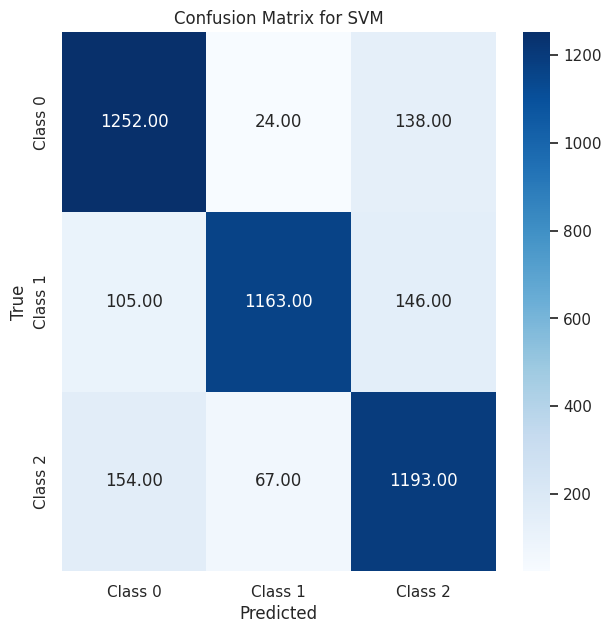

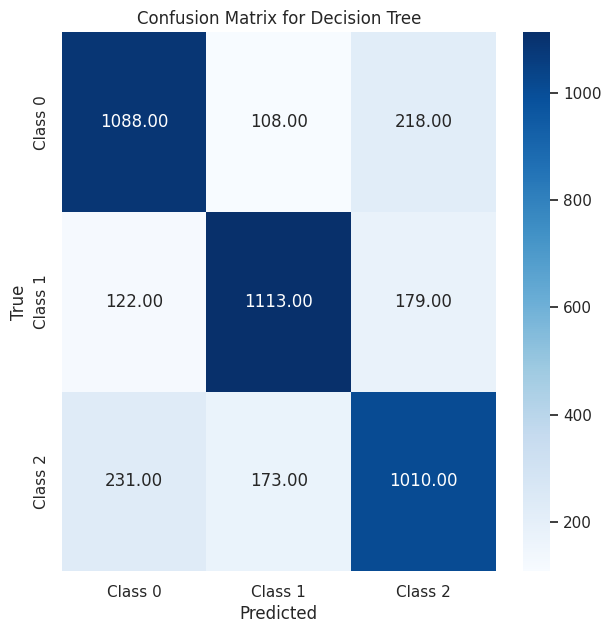

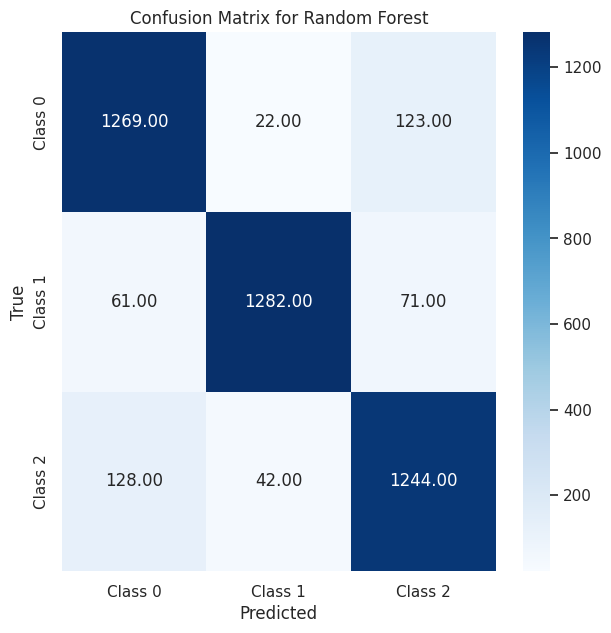

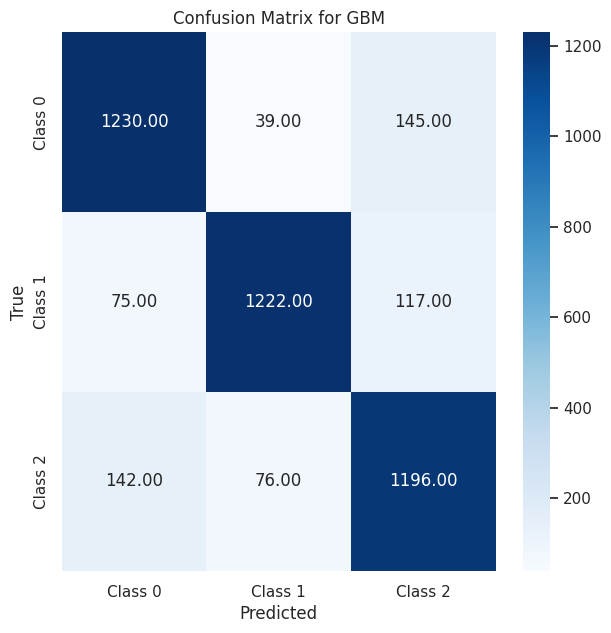

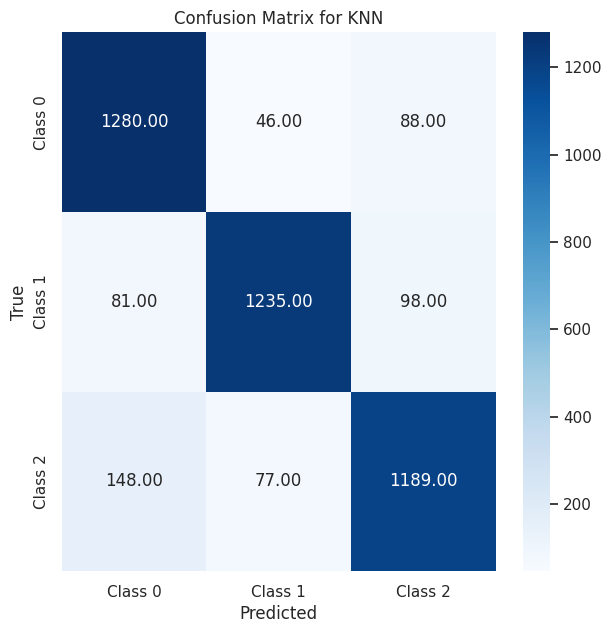

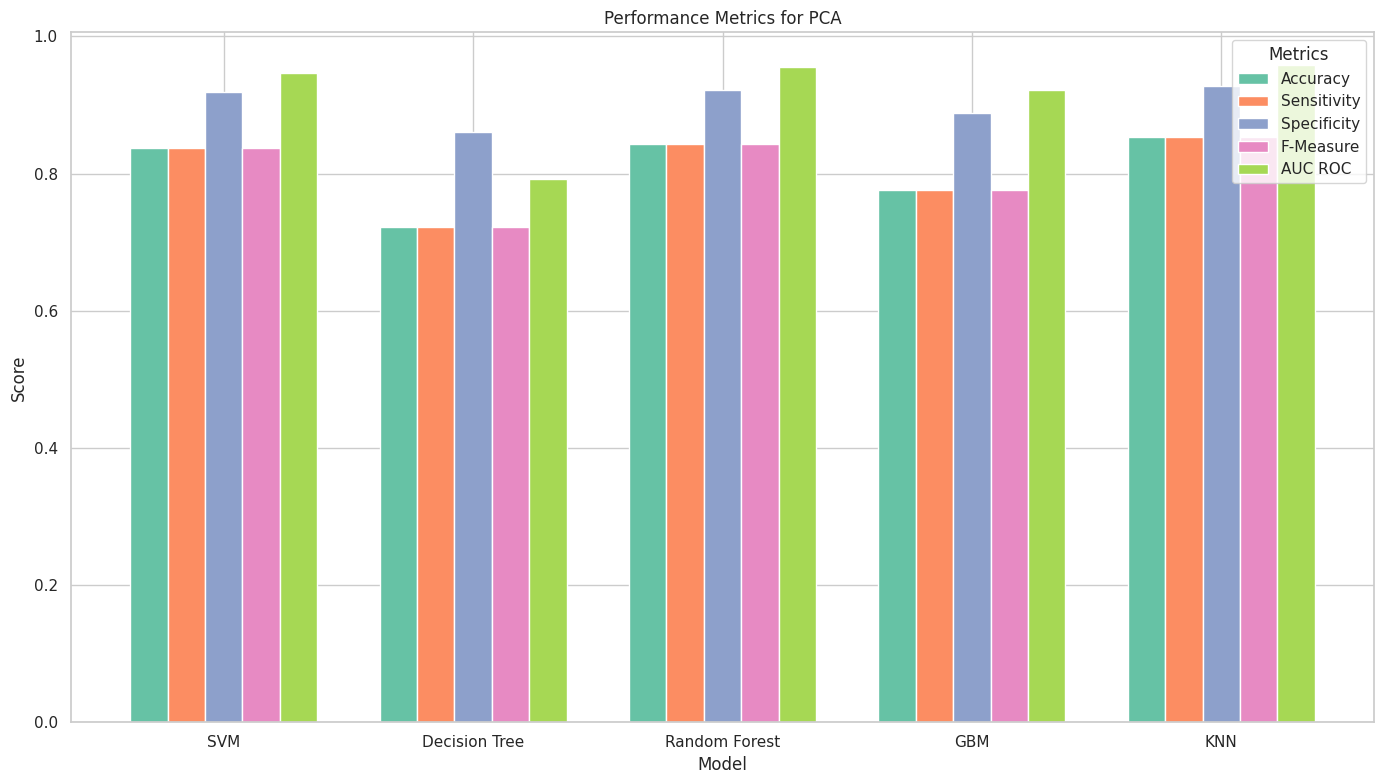

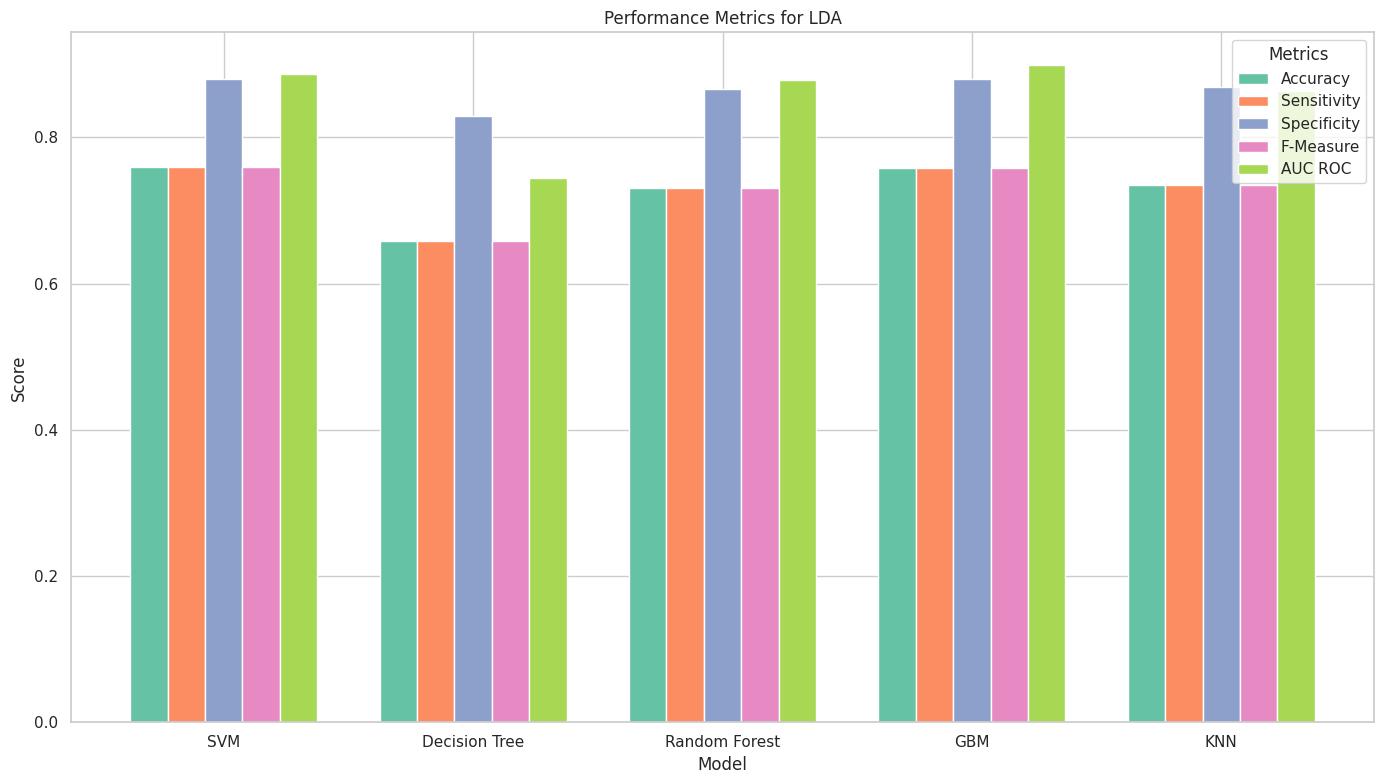

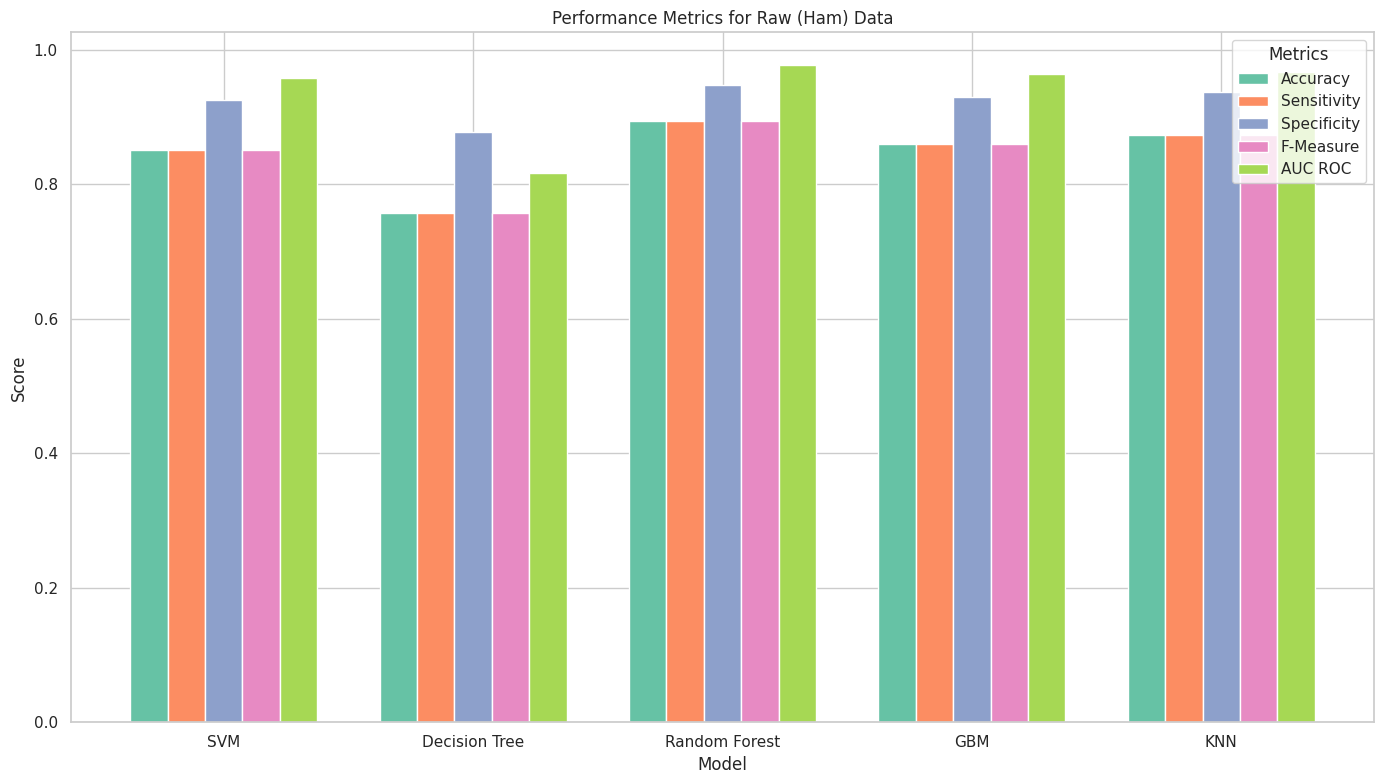

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Veri dosyaları
pca_path = "/content/drive/MyDrive/data_with_pca_normalized.csv"
lda_train_path = "/content/drive/MyDrive/data_with_lda_train.csv"
lda_test_path = "/content/drive/MyDrive/data_with_lda_test.csv"
ham_data_path = "/content/drive/MyDrive/5_data_balanced.csv"

# 1. PCA uygulanmış veriyi yükleme
data_pca = pd.read_csv(pca_path)
X_pca = data_pca.drop(columns=['label'])
y_pca = data_pca['label'].astype(int)  # Sınıfları 0, 1, 2 olarak kullanma

# 2. LDA uygulanmış veriyi yükleme
lda_train = pd.read_csv(lda_train_path)
lda_test = pd.read_csv(lda_test_path)
X_lda = pd.concat([lda_train.drop(columns=['label']), lda_test.drop(columns=['label'])])
y_lda = pd.concat([lda_train['label'], lda_test['label']]).astype(int)  # Sınıfları 0, 1, 2 olarak kullanma

# 3. PCA ve LDA uygulanmamış veriyi yükleme
ham_data = pd.read_csv(ham_data_path)
X_ham = ham_data.drop(columns=['label'])
y_ham = ham_data['label'].astype(int)  # Sınıfları 0, 1, 2 olarak kullanma

# Modeller
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Performans metrikleri hesaplama fonksiyonu
def evaluate_model(X, y, model_name):
    results = []
    cm_dict = {name: [] for name in models.keys()}  # Her model için ayrı karmaşıklık matrisi saklama
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        fold_accuracies = []
        fold_sensitivities = []
        fold_specificities = []
        fold_f_measures = []
        fold_auc_rocs = []

        for train_index, val_index in cv.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Özellik standardizasyonu
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            # Modeli eğitme
            model.fit(X_train, y_train)

            # Tahmin yapma
            y_pred = model.predict(X_val)
            y_prob = model.predict_proba(X_val) if hasattr(model, 'predict_proba') else None

            # Performans metrikleri
            cm = confusion_matrix(y_val, y_pred, labels=[0, 1, 2])
            sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0 for i in range(3)])
            specificity = np.mean([(cm.sum() - cm[:, i].sum() - cm[i].sum() + cm[i, i]) / (cm.sum() - cm[:, i].sum()) if cm.sum() - cm[:, i].sum() > 0 else 0 for i in range(3)])
            f_measure = f1_score(y_val, y_pred, average='weighted')
            auc_roc = roc_auc_score(y_val, y_prob, multi_class='ovr') if y_prob is not None else None

            fold_accuracies.append(accuracy_score(y_val, y_pred))
            fold_sensitivities.append(sensitivity)
            fold_specificities.append(specificity)
            fold_f_measures.append(f_measure)
            if auc_roc is not None:
                fold_auc_rocs.append(auc_roc)

            cm_dict[name].append(cm)

        # Ortalama sonuçlar
        results.append({
            'Model': name,
            'Accuracy': np.mean(fold_accuracies),
            'Sensitivity': np.mean(fold_sensitivities),
            'Specificity': np.mean(fold_specificities),
            'F-Measure': np.mean(fold_f_measures),
            'AUC ROC': np.mean(fold_auc_rocs) if fold_auc_rocs else None,
            'Dataset': model_name
        })

    return results, cm_dict

# Tüm veri setleri için çapraz doğrulama ve karmaşıklık matrislerini alma
results_pca, cm_pca_dict = evaluate_model(X_pca, y_pca, "PCA")
results_lda, cm_lda_dict = evaluate_model(X_lda, y_lda, "LDA")
results_ham, cm_ham_dict = evaluate_model(X_ham, y_ham, "Ham")

# Sonuçları birleştirme
all_results = pd.DataFrame(results_pca + results_lda + results_ham)

# Sonuçları CSV olarak kaydetme
all_results.to_csv('/content/drive/MyDrive/ml_All_model_results.csv', index=False)

# Her model için karmaşıklık matrislerini görselleştirme
for model_name, cm_list in {**cm_pca_dict, **cm_lda_dict, **cm_ham_dict}.items():
    total_cm = np.sum(cm_list, axis=0)
    plt.figure(figsize=(7, 7))
    sns.heatmap(total_cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1', 'Class 2'],
                yticklabels=['Class 0', 'Class 1', 'Class 2'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 8. Sonuçları görselleştirme (üç ayrı grafik için düzenleme)

# Bar genişliği
bar_width = 0.15
x = np.arange(len(models))  # Modellerin sayısı kadar bar yerleştirilecek

# Metrikler
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'F-Measure', 'AUC ROC']
metric_labels = ['Accuracy', 'Sensitivity', 'Specificity', 'F-Measure', 'AUC ROC']

# Renk paleti (her metrik için farklı renk)
colors = sns.color_palette("Set2", len(metrics))

# 1. PCA verisi için grafik
plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics):
    for j, model_name in enumerate(models.keys()):
        # PCA verisi için metrik değeri
        metric_data = all_results[(all_results['Model'] == model_name) & (all_results['Dataset'] == 'PCA')]
        metric_value = metric_data[metric].values[0]
        offset = bar_width * i  # Her metriği yatayda sıralamak için ofset
        plt.bar(x[j] + offset, metric_value, bar_width, color=colors[i], label=metric if j == 0 else "")

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Metrics for PCA')
plt.xticks(x + bar_width * 2, models.keys())
plt.legend(title='Metrics', loc='upper right')
plt.tight_layout()
plt.show()

# 2. LDA verisi için grafik
plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics):
    for j, model_name in enumerate(models.keys()):
        # LDA verisi için metrik değeri
        metric_data = all_results[(all_results['Model'] == model_name) & (all_results['Dataset'] == 'LDA')]
        metric_value = metric_data[metric].values[0]
        offset = bar_width * i  # Her metriği yatayda sıralamak için ofset
        plt.bar(x[j] + offset, metric_value, bar_width, color=colors[i], label=metric if j == 0 else "")

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Metrics for LDA')
plt.xticks(x + bar_width * 2, models.keys())
plt.legend(title='Metrics', loc='upper right')
plt.tight_layout()
plt.show()

# 3. Ham veri seti için grafik
plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics):
    for j, model_name in enumerate(models.keys()):
        # Ham veri seti için metrik değeri
        metric_data = all_results[(all_results['Model'] == model_name) & (all_results['Dataset'] == 'Ham')]
        metric_value = metric_data[metric].values[0]
        offset = bar_width * i  # Her metriği yatayda sıralamak için ofset
        plt.bar(x[j] + offset, metric_value, bar_width, color=colors[i], label=metric if j == 0 else "")

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Metrics for Raw (Ham) Data')
plt.xticks(x + bar_width * 2, models.keys())
plt.legend(title='Metrics', loc='upper right')
plt.tight_layout()
plt.show()




# DERİN ÖĞRENME


LDA Columns: Index(['Unnamed: 0', 'accuracy', 'f1', 'sensitivity', 'specificity',
       'auc_roc'],
      dtype='object')
PCA Columns: Index(['Unnamed: 0', 'accuracy', 'f1', 'sensitivity', 'specificity', 'auc_roc',
       'confusion_matrix'],
      dtype='object')
No Method Columns: Index(['Unnamed: 0', 'accuracy', 'f1', 'sensitivity', 'specificity', 'auc_roc',
       'confusion_matrix'],
      dtype='object')


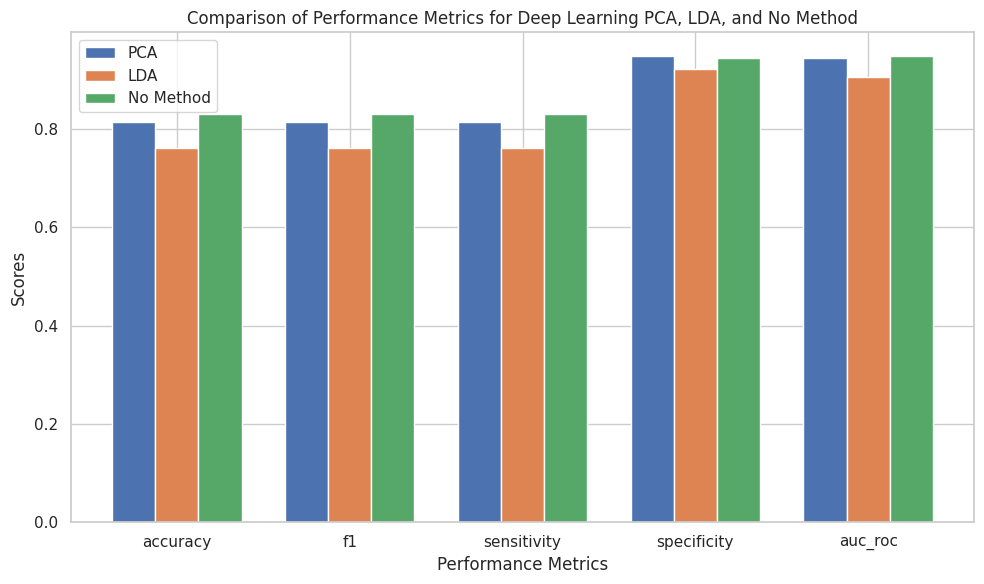

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dosya yolları
lda_file = '/content/drive/MyDrive/dl_lda_model_results_kfold.csv'
no_method_file = '/content/drive/MyDrive/dl_model_performance_results_kfold.csv'
pca_file = '/content/drive/MyDrive/dl_pca_model_performance_results_kfold.csv'

# Dosyaları yükle
lda_results = pd.read_csv(lda_file)
no_method_results = pd.read_csv(no_method_file)
pca_results = pd.read_csv(pca_file)

# Sütun adlarını kontrol et
print("LDA Columns:", lda_results.columns)
print("PCA Columns:", pca_results.columns)
print("No Method Columns:", no_method_results.columns)

# Performans metriklerini kontrol et
lda_metrics = ['accuracy', 'f1', 'sensitivity', 'specificity', 'auc_roc']
pca_metrics = ['accuracy', 'f1', 'sensitivity', 'specificity', 'auc_roc']
no_method_metrics = ['accuracy', 'f1', 'sensitivity', 'specificity', 'auc_roc']

# Verilerin eksik olup olmadığını kontrol et ve NaN yerine 0 ile doldur
lda_results = lda_results.fillna(0)
pca_results = pca_results.fillna(0)
no_method_results = no_method_results.fillna(0)

# Ortalamaları hesapla
lda_means = [lda_results[metric].mean() for metric in lda_metrics]
pca_means = [pca_results[metric].mean() for metric in pca_metrics]
no_method_means = [no_method_results[metric].mean() for metric in no_method_metrics]

# Metriklerin konumlarını belirle
x = np.arange(len(lda_metrics))  # Metriklerin konumu
width = 0.25  # Barların genişliği

# Grafik oluşturma
fig, ax = plt.subplots(figsize=(10, 6))

# Barlar
ax.bar(x - width, pca_means, width, label='PCA')
ax.bar(x, lda_means, width, label='LDA')
ax.bar(x + width, no_method_means, width, label='No Method')

# Grafiği özelleştirme
ax.set_xlabel('Performance Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Performance Metrics for Deep Learning PCA, LDA, and No Method')
ax.set_xticks(x)
ax.set_xticklabels(lda_metrics)
ax.legend()

# Grafiği gösterme
plt.tight_layout()
plt.show()


Veri seti: /content/drive/MyDrive/data_with_lda_train.csv
Etiketlerin ilk 5 değeri: [2. 1. 0. 0. 1.]
Özelliklerin boyutu: (3393, 2)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6501 - loss: 0.8519
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7439 - loss: 0.6421
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7634 - loss: 0.6121
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7691 - loss: 0.5800
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7722 - loss: 0.5950
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7746 - loss: 0.5820
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7552 - loss: 0.5916
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7643 - loss: 0.5934
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7646 - loss: 0.5839
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7609 - loss: 0.6017
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7553 - loss: 0.7822
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7377 - loss: 0.6387
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7609 - loss: 0.6013
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7772 - loss: 0.5632
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7560 - loss: 0.6045
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7724 - loss: 0.5786
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7612 - loss: 0.5972
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7621 - loss: 0.5917
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7621 - loss: 0.5936
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7515 - loss: 0.6105
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7013 - loss: 0.8180
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7477 - loss: 0.6116
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7453 - loss: 0.6300
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7540 - loss: 0.6052
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7684 - loss: 0.5797
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7708 - loss: 0.5738
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7477 - loss: 0.5945
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7572 - loss: 0.6101
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7647 - loss: 0.5816
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7759 - loss: 0.5567
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6925 - loss: 0.8181
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7460 - loss: 0.6280
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.5799
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7534 - loss: 0.6140
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7582 - loss: 0.6247
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7473 - loss: 0.6177
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7680 - loss: 0.5833
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7572 - loss: 0.6041
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7443 - loss: 0.6218
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7608 - loss: 0.5888
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7250 - loss: 0.8104
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7706 - loss: 0.5711
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7681 - loss: 0.5980
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7749 - loss: 0.5718
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7810 - loss: 0.5387
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.5545
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7803 - loss: 0.5683
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7753 - loss: 0.5578
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.5611
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7792 - loss: 0.5783
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6312 - loss: 0.8774
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7606 - loss: 0.6179
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7670 - loss: 0.5984
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7516 - loss: 0.6055
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7673 - loss: 0.5874
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7506 - loss: 0.6081
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7659 - loss: 0.6012
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7797 - loss: 0.5872
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7731 - loss: 0.5802
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7607 - loss: 0.6000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6144 - loss: 0.9114
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7648 - loss: 0.5991
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7727 - loss: 0.5926
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7602 - loss: 0.6275
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7566 - loss: 0.6273
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7693 - loss: 0.5998
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7577 - loss: 0.6152
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7677 - loss: 0.5906
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7528 - loss: 0.6197
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7519 - loss: 0.6160
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6221 - loss: 0.8943
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7426 - loss: 0.6381
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7590 - loss: 0.5987
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7479 - loss: 0.6069
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7655 - loss: 0.5963
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7585 - loss: 0.6063
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7638 - loss: 0.6110
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7613 - loss: 0.6008
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7635 - loss: 0.5871
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7624 - loss: 0.5953
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5590 - loss: 0.9352
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7632 - loss: 0.6178
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7477 - loss: 0.6155
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7589 - loss: 0.6120
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7476 - loss: 0.6306
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7391 - loss: 0.6261
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7521 - loss: 0.6158
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7589 - loss: 0.6022
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7707 - loss: 0.5914
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7530 - loss: 0.6043
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6008 - loss: 0.9211
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848 - loss: 0.5649
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7754 - loss: 0.5720
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7755 - loss: 0.5815
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7722 - loss: 0.5879
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7762 - loss: 0.5778
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7527 - loss: 0.6022
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7676 - loss: 0.5755
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7719 - loss: 0.5725
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7829 - loss: 0.5585
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6838 - loss: 0.8156
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7520 - loss: 0.6283
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7619 - loss: 0.6166
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7657 - loss: 0.6132
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7717 - loss: 0.5888
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7633 - loss: 0.5979
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7836 - loss: 0.5778
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7729 - loss: 0.5925
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7594 - loss: 0.6093
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7564 - loss: 0.5946
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6990 - loss: 0.8064
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7582 - loss: 0.6335
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7602 - loss: 0.6047
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7533 - loss: 0.6263
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7573 - loss: 0.6141
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7476 - loss: 0.6324
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7658 - loss: 0.5980
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7711 - loss: 0.5802
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7590 - loss: 0.6012
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7594 - loss: 0.5879
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7008 - loss: 0.8195
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7613 - loss: 0.6249
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7624 - loss: 0.6257
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7617 - loss: 0.6245
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7537 - loss: 0.6172
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7456 - loss: 0.6241
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7678 - loss: 0.5893
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7573 - loss: 0.6111
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7503 - loss: 0.6189
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7683 - loss: 0.5877
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7255 - loss: 0.8106
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7395 - loss: 0.6539
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7536 - loss: 0.6133
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7507 - loss: 0.6432
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7600 - loss: 0.6325
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7545 - loss: 0.6160
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7582 - loss: 0.6153
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7580 - loss: 0.6145
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7567 - loss: 0.6385
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7590 - loss: 0.6038
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7068 - loss: 0.8002
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7793 - loss: 0.5734
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7759 - loss: 0.5925
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7629 - loss: 0.6001
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7801 - loss: 0.5676
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7794 - loss: 0.5848
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7678 - loss: 0.5859
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7790 - loss: 0.5846
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7647 - loss: 0.5912
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7603 - loss: 0.5884
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6435 - loss: 0.9096
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7636 - loss: 0.6025
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7675 - loss: 0.5849
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 0.5890
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7784 - loss: 0.5795
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7706 - loss: 0.5871
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7645 - loss: 0.5945
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7755 - loss: 0.5673
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7746 - loss: 0.5797
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7785 - loss: 0.5789
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6601 - loss: 0.8378
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7503 - loss: 0.6342
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7501 - loss: 0.6105
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7489 - loss: 0.6169
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7410 - loss: 0.6189
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7701 - loss: 0.5784
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7522 - loss: 0.6088
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7681 - loss: 0.5755
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7645 - loss: 0.6084
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7654 - loss: 0.5944
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6543 - loss: 0.8653
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - loss: 0.6002
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7567 - loss: 0.6100
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7515 - loss: 0.6091
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7630 - loss: 0.5918
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7622 - loss: 0.5759
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7734 - loss: 0.5703
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7669 - loss: 0.5814
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7564 - loss: 0.5977
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7571 - loss: 0.5845
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6794 - loss: 0.8799
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7578 - loss: 0.6022
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7537 - loss: 0.6217
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7549 - loss: 0.6127
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7779 - loss: 0.5729
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7543 - loss: 0.6017
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7603 - loss: 0.5971
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7544 - loss: 0.6004
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7506 - loss: 0.6258
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - loss: 0.5954
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6995 - loss: 0.8192
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7531 - loss: 0.6037
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7733 - loss: 0.5740
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7739 - loss: 0.5705
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7748 - loss: 0.5623
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7703 - loss: 0.5684
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7744 - loss: 0.5568
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7879 - loss: 0.5544
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7790 - loss: 0.5570
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7677 - loss: 0.5734
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6425 - loss: 0.8647
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7653 - loss: 0.6021
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7587 - loss: 0.5987
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7578 - loss: 0.6105
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7757 - loss: 0.5770
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7780 - loss: 0.5816
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7746 - loss: 0.5626
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7619 - loss: 0.5905
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7836 - loss: 0.5567
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7608 - loss: 0.5912
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6434 - loss: 0.8634
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7675 - loss: 0.6011
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7738 - loss: 0.5620
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - loss: 0.5896
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7622 - loss: 0.5838
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7635 - loss: 0.5899
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7557 - loss: 0.6123
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7699 - loss: 0.5799
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7623 - loss: 0.5870
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7551 - loss: 0.6161
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7227 - loss: 0.8147
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7625 - loss: 0.5833
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7510 - loss: 0.5949
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7591 - loss: 0.5905
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7455 - loss: 0.6076
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7676 - loss: 0.5836
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7617 - loss: 0.5815
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7524 - loss: 0.6079
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7665 - loss: 0.5835
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7551 - loss: 0.5976
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6847 - loss: 0.8473
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7719 - loss: 0.5896
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7680 - loss: 0.5793
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7514 - loss: 0.6005
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7543 - loss: 0.6102
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7539 - loss: 0.5984
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7614 - loss: 0.5973
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7560 - loss: 0.6046
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7620 - loss: 0.5961
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7528 - loss: 0.6089
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7204 - loss: 0.8150
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7653 - loss: 0.5719
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7666 - loss: 0.5703
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.5792
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7696 - loss: 0.5888
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7638 - loss: 0.5960
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7677 - loss: 0.5752
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7751 - loss: 0.5827
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7658 - loss: 0.5790
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7815 - loss: 0.5524
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Veri seti: /content/drive/MyDrive/data_with_lda_test.csv
Etiketlerin ilk 5 değeri: [1. 0. 2. 0. 2.]
Özelliklerin boyutu: (849, 2)
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5898 - loss: 1.0062
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7228 - loss: 0.7600 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7178 - loss: 0.6655 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7286 - loss: 0.6435 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7647 - loss: 0.6025 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7684 - loss: 0.5895 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7460 - loss: 0.6319
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7564 - loss: 0.5929 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7256 - loss: 0.6280 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7658 - loss: 0.5833
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6026 - loss: 0.9750
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7485 - loss: 0.7257
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7178 - loss: 0.7034
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7515 - loss: 0.6129
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7296 - loss: 0.6647
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7467 - loss: 0.6260
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7405 - loss: 0.6441
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7611 - loss: 0.6307
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7190 - loss: 0.6625
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7593 - loss: 0.6329
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6484 - loss: 0.9801
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7218 - loss: 0.7662
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7399 - loss: 0.6545 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7519 - loss: 0.6358 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7239 - loss: 0.6749 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7420 - loss: 0.6543 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7324 - loss: 0.6491 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7213 - loss: 0.6688 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7265 - loss: 0.6721 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7477 - loss: 0.6329
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7110 - loss: 0.9718
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7180 - loss: 0.7224 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7266 - loss: 0.6773 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7380 - loss: 0.6463 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7469 - loss: 0.6162 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7474 - loss: 0.6252 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7536 - loss: 0.6282 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7131 - loss: 0.6722 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7631 - loss: 0.5988 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7473 - loss: 0.6245 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5424 - loss: 1.0241
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7335 - loss: 0.7389 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - loss: 0.6419 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7386 - loss: 0.6447 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7268 - loss: 0.6661 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7441 - loss: 0.5931 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7435 - loss: 0.6477 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7667 - loss: 0.5907
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7485 - loss: 0.6135
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7269 - loss: 0.6546 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4117 - loss: 1.0530
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6990 - loss: 0.8748 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7461 - loss: 0.7356
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7224 - loss: 0.6900
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7622 - loss: 0.6267
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7302 - loss: 0.6641
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7674 - loss: 0.5851
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7367 - loss: 0.6304
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7472 - loss: 0.6278
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7296 - loss: 0.6625
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5310 - loss: 0.9802
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7499 - loss: 0.7751
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7214 - loss: 0.6981
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7287 - loss: 0.6905
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7437 - loss: 0.6581
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7210 - loss: 0.6767
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7618 - loss: 0.6406
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7475 - loss: 0.6610 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7427 - loss: 0.6555
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7354 - loss: 0.6555
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5572 - loss: 0.9923
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7088 - loss: 0.8053
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7185 - loss: 0.7328
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7326 - loss: 0.6711
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7266 - loss: 0.6754
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7352 - loss: 0.6555
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7249 - loss: 0.6903
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7168 - loss: 0.6832
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7155 - loss: 0.6783
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7375 - loss: 0.6691
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5371 - loss: 1.0194
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7175 - loss: 0.8698 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7242 - loss: 0.7448 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7259 - loss: 0.7059
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7747 - loss: 0.6119 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7342 - loss: 0.6610
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7381 - loss: 0.6699
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7710 - loss: 0.6270
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7396 - loss: 0.6605
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7385 - loss: 0.6494
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4315 - loss: 1.0594
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7190 - loss: 0.8595
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7241 - loss: 0.7356
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7141 - loss: 0.6743
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7403 - loss: 0.6463
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7442 - loss: 0.6421
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7378 - loss: 0.6267
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7458 - loss: 0.6172
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7463 - loss: 0.6230
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7493 - loss: 0.6206
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5810 - loss: 0.9854
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7441 - loss: 0.6524
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7203 - loss: 0.6786
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7439 - loss: 0.6810
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7362 - loss: 0.6390
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7624 - loss: 0.6174
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7241 - loss: 0.6721
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7475 - loss: 0.6386
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7785 - loss: 0.5951
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7577 - loss: 0.6483
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6000 - loss: 0.9961
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7053 - loss: 0.7089
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7319 - loss: 0.7013
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7168 - loss: 0.7264
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7192 - loss: 0.6825
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7396 - loss: 0.6516
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7387 - loss: 0.6775
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7464 - loss: 0.6831
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7518 - loss: 0.6494
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7212 - loss: 0.6968
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5474 - loss: 1.0210
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7160 - loss: 0.7251
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7180 - loss: 0.7123
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7367 - loss: 0.6807
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7323 - loss: 0.6861
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7410 - loss: 0.6524
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7145 - loss: 0.7214
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7370 - loss: 0.6816
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7553 - loss: 0.6795
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7419 - loss: 0.6591
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5640 - loss: 1.0120
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7537 - loss: 0.6674
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7443 - loss: 0.6552
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7351 - loss: 0.6903
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7474 - loss: 0.6480
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7632 - loss: 0.6110
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7279 - loss: 0.6755
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7256 - loss: 0.6918
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7386 - loss: 0.6535
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7326 - loss: 0.6646
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6066 - loss: 1.0084
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7442 - loss: 0.6606
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7424 - loss: 0.6224
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7554 - loss: 0.6546
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7567 - loss: 0.6105
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7522 - loss: 0.6187
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7565 - loss: 0.6115
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7334 - loss: 0.6575
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7372 - loss: 0.6535
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7567 - loss: 0.5977
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5519 - loss: 1.0192
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7183 - loss: 0.7398
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7614 - loss: 0.5968  
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7231 - loss: 0.6530 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7270 - loss: 0.6352
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - loss: 0.6214 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7450 - loss: 0.6063 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7576 - loss: 0.5986
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 0.6355 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7767 - loss: 0.5785
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5193 - loss: 1.0509
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7329 - loss: 0.7738
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7157 - loss: 0.7158
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7456 - loss: 0.6386
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7471 - loss: 0.6270
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7549 - loss: 0.6056
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7362 - loss: 0.6689
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7479 - loss: 0.6281
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7306 - loss: 0.6609 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7487 - loss: 0.6119 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6226 - loss: 0.9962
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6943 - loss: 0.7824 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7592 - loss: 0.6383 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6949 - loss: 0.7327
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7095 - loss: 0.6950
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7408 - loss: 0.6333 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 0.6197 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7400 - loss: 0.6582 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7313 - loss: 0.6428 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7339 - loss: 0.6390 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5757 - loss: 1.0167
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7316 - loss: 0.7643 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7488 - loss: 0.6452 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7158 - loss: 0.6857 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7408 - loss: 0.6549
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7363 - loss: 0.6341
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7454 - loss: 0.6285 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7333 - loss: 0.6473
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7662 - loss: 0.6503
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7596 - loss: 0.6019
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5679 - loss: 1.0315
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7646 - loss: 0.7564
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7573 - loss: 0.6328
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7580 - loss: 0.6206  
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7254 - loss: 0.6659 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7427 - loss: 0.6276
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.5714 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7467 - loss: 0.6109 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7405 - loss: 0.6211 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7519 - loss: 0.6104 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6667 - loss: 0.9999
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7524 - loss: 0.7436 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7162 - loss: 0.6538 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7226 - loss: 0.6646 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7324 - loss: 0.6197 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7519 - loss: 0.5822 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7419 - loss: 0.6132 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7258 - loss: 0.6383 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7683 - loss: 0.5891
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7365 - loss: 0.6307 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4790 - loss: 1.0707
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6995 - loss: 0.8941 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7575 - loss: 0.6661 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7571 - loss: 0.6226 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7247 - loss: 0.6780 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7437 - loss: 0.6523
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7558 - loss: 0.6169 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7518 - loss: 0.6324 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7322 - loss: 0.6602 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7286 - loss: 0.6866 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6121 - loss: 1.0187
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7178 - loss: 0.7316 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7348 - loss: 0.6679 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7461 - loss: 0.6358 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7155 - loss: 0.6756 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7337 - loss: 0.6659
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7357 - loss: 0.6448
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7169 - loss: 0.6902 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7232 - loss: 0.6746 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7464 - loss: 0.6611 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5547 - loss: 1.0375
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7355 - loss: 0.7856
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7241 - loss: 0.6474
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7218 - loss: 0.6457
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7478 - loss: 0.6475
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7460 - loss: 0.6425
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7368 - loss: 0.6302
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7456 - loss: 0.6385
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7291 - loss: 0.6619
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7580 - loss: 0.6086 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5893 - loss: 1.0244
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7259 - loss: 0.7412 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7486 - loss: 0.6293 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7318 - loss: 0.6248
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7493 - loss: 0.6202 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7625 - loss: 0.6009 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7728 - loss: 0.5909 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7443 - loss: 0.6116 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7813 - loss: 0.5737
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7570 - loss: 0.5907
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Veri seti: /content/drive/MyDrive/5_data_balanced.csv
Etiketlerin ilk 5 değeri: [0. 0. 0. 0. 0.]
Özelliklerin boyutu: (4242, 9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6056 - loss: 0.8348
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.5207
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8274 - loss: 0.4399
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8127 - loss: 0.4266
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8427 - loss: 0.3676
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8685 - loss: 0.3362
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8776 - loss: 0.3015
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8893 - loss: 0.2752
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9054 - loss: 0.2429
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.3306
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5858 - loss: 0.8738
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7799 - loss: 0.5475
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8231 - loss: 0.4477
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8340 - loss: 0.4095
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8650 - loss: 0.3552
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8742 - loss: 0.3393
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8844 - loss: 0.2927
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9048 - loss: 0.2659
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8714 - loss: 0.3148
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9099 - loss: 0.2359
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6457 - loss: 0.8194
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7790 - loss: 0.5646
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8235 - loss: 0.4526
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8492 - loss: 0.3875
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.3339
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8594 - loss: 0.3459
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8810 - loss: 0.3033
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9024 - loss: 0.2701
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9047 - loss: 0.2547
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8977 - loss: 0.2714
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5951 - loss: 0.8611
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7766 - loss: 0.5459
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8002 - loss: 0.4909
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8489 - loss: 0.3863
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8562 - loss: 0.3549
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3211
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8889 - loss: 0.2801
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8978 - loss: 0.2751
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9088 - loss: 0.2492
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9176 - loss: 0.2285
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5753 - loss: 0.9493
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7830 - loss: 0.5413
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8156 - loss: 0.4492
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8319 - loss: 0.4147
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8457 - loss: 0.3684
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8711 - loss: 0.3229
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8885 - loss: 0.2829
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8993 - loss: 0.2786
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9051 - loss: 0.2527
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9250 - loss: 0.2136
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5074 - loss: 0.9991
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6339 - loss: 0.8350
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6510 - loss: 0.7986
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6652 - loss: 0.7725
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6749 - loss: 0.7597
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6890 - loss: 0.7346
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6794 - loss: 0.7177
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6962 - loss: 0.7269
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6934 - loss: 0.7241
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7215 - loss: 0.6647
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4706 - loss: 1.0261
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6123 - loss: 0.8558
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6505 - loss: 0.7954
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6409 - loss: 0.8105
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6749 - loss: 0.7523
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6670 - loss: 0.7441
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6876 - loss: 0.7147
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6979 - loss: 0.6927
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7189 - loss: 0.6598
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7260 - loss: 0.6485
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5383 - loss: 0.9761
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6066 - loss: 0.8660
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6308 - loss: 0.8205
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6504 - loss: 0.7820
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6705 - loss: 0.7496
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6625 - loss: 0.7605
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6463 - loss: 0.8097
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6849 - loss: 0.7214
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7032 - loss: 0.7027
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6840 - loss: 0.7116
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4972 - loss: 0.9978
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6144 - loss: 0.8373
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6489 - loss: 0.8013
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6730 - loss: 0.7623
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6970 - loss: 0.7166
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6852 - loss: 0.7207
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6956 - loss: 0.7096
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7033 - loss: 0.7039
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7119 - loss: 0.6859
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6249 - loss: 0.8538
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5133 - loss: 0.9939
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6339 - loss: 0.8204
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6497 - loss: 0.7999
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6626 - loss: 0.7578
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6566 - loss: 0.7766
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6935 - loss: 0.7299
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6776 - loss: 0.7144
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7084 - loss: 0.6870
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6921 - loss: 0.6934
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7090 - loss: 0.6661
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6083 - loss: 0.8595
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.7671 - loss: 0.5487
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7970 - loss: 0.4844
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8402 - loss: 0.3884
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8655 - loss: 0.3398
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8746 - loss: 0.3074
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8861 - loss: 0.2748
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9163 - loss: 0.2278
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9055 - loss: 0.2152
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9363 - loss: 0.1722
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6226 - loss: 0.8455
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7519 - loss: 0.5879
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8144 - loss: 0.4723
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8380 - loss: 0.3907
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8666 - loss: 0.3352
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8955 - loss: 0.2722
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9078 - loss: 0.2462
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9054 - loss: 0.2343
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9222 - loss: 0.1948
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9376 - loss: 0.1564
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6418 - loss: 0.8270
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.7670 - loss: 0.5588
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8256 - loss: 0.4240
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8376 - loss: 0.3817
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8598 - loss: 0.3330
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8808 - loss: 0.2824
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9028 - loss: 0.2604
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9010 - loss: 0.2460
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8995 - loss: 0.2356
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9372 - loss: 0.1718
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.5890 - loss: 0.8856
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7694 - loss: 0.5540
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8211 - loss: 0.4368
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8258 - loss: 0.4205
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8757 - loss: 0.3208
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8755 - loss: 0.3151
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9041 - loss: 0.2337
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9127 - loss: 0.2148
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9257 - loss: 0.1902
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9354 - loss: 0.1696
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5676 - loss: 0.8928
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7840 - loss: 0.5552
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8088 - loss: 0.4565
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8385 - loss: 0.4087
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.8663 - loss: 0.3434
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8753 - loss: 0.3013
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8975 - loss: 0.2477
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8928 - loss: 0.2583
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9229 - loss: 0.1912
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9325 - loss: 0.1669
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5882 - loss: 0.8710
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7725 - loss: 0.5441
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8252 - loss: 0.4319
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8617 - loss: 0.3522
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8616 - loss: 0.3445
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8699 - loss: 0.3124
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9014 - loss: 0.2543
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8884 - loss: 0.2945
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9200 - loss: 0.2120
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9276 - loss: 0.1967
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5932 - loss: 0.8921
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7734 - loss: 0.5652
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8200 - loss: 0.4414
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8196 - loss: 0.4426
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8593 - loss: 0.3522
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8731 - loss: 0.3128
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8968 - loss: 0.2546
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9164 - loss: 0.2277
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8499 - loss: 0.4323
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9151 - loss: 0.2192
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6109 - loss: 0.8379
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7912 - loss: 0.5249
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8159 - loss: 0.4441
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8491 - loss: 0.3756
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8664 - loss: 0.3280
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8677 - loss: 0.3374
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8952 - loss: 0.2679
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9047 - loss: 0.2499
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9081 - loss: 0.2220
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9291 - loss: 0.2024
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5759 - loss: 0.9064
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7769 - loss: 0.5366
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8473 - loss: 0.3961
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.3888
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8775 - loss: 0.3125
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.2795
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9152 - loss: 0.2252
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9212 - loss: 0.2160
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9217 - loss: 0.2058
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9429 - loss: 0.1669
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5883 - loss: 0.8901
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7840 - loss: 0.5344
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8231 - loss: 0.4272
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8406 - loss: 0.3768
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8609 - loss: 0.3453
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8733 - loss: 0.3125
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8857 - loss: 0.2882
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9116 - loss: 0.2306
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9167 - loss: 0.2179
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9245 - loss: 0.2030
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5752 - loss: 0.9135
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7773 - loss: 0.5404
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8368 - loss: 0.4230
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8645 - loss: 0.3538
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8760 - loss: 0.3197
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8775 - loss: 0.3053
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9089 - loss: 0.2443
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9079 - loss: 0.2355
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9256 - loss: 0.2044
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9279 - loss: 0.1989
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6072 - loss: 0.8591
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7885 - loss: 0.5167
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8087 - loss: 0.4568
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 0.3771
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8688 - loss: 0.3408
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8822 - loss: 0.3019
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8744 - loss: 0.3135
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8979 - loss: 0.2549
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9156 - loss: 0.2187
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9303 - loss: 0.1852
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5869 - loss: 0.8968
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7578 - loss: 0.5848
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8266 - loss: 0.4421
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8404 - loss: 0.3788
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8721 - loss: 0.3240
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8829 - loss: 0.2972
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9094 - loss: 0.2529
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9175 - loss: 0.2184
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9233 - loss: 0.1985
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9396 - loss: 0.1691
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5777 - loss: 0.9281
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7629 - loss: 0.5642
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8176 - loss: 0.4450
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8418 - loss: 0.4029
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8597 - loss: 0.3452
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8964 - loss: 0.2805
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3136
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8777 - loss: 0.3072
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9130 - loss: 0.2181
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9091 - loss: 0.2117
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5636 - loss: 0.9064
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7648 - loss: 0.5558
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8238 - loss: 0.4376
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8457 - loss: 0.3725
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8576 - loss: 0.3381
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8849 - loss: 0.2902
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8931 - loss: 0.2758
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9155 - loss: 0.2221
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9137 - loss: 0.2167
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9194 - loss: 0.2069
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Veri seti: /content/drive/MyDrive/data_with_pca_normalized.csv
Etiketlerin ilk 5 değeri: [0. 0. 0. 0. 0.]
Özell

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5815 - loss: 0.9278
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7654 - loss: 0.6153
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7862 - loss: 0.5423
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8118 - loss: 0.4829
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8310 - loss: 0.4411
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8243 - loss: 0.4355
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8435 - loss: 0.4061
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8426 - loss: 0.3876
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.3523
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8614 - loss: 0.3555
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5640 - loss: 0.9375
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7526 - loss: 0.6379
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7680 - loss: 0.5705
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7913 - loss: 0.5229
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8047 - loss: 0.4856
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8158 - loss: 0.4539
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8164 - loss: 0.4548
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8175 - loss: 0.4361
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.3781
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8643 - loss: 0.3602
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5867 - loss: 0.9117
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7428 - loss: 0.6320
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7818 - loss: 0.5594
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7983 - loss: 0.5163
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8059 - loss: 0.4805
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7995 - loss: 0.4630
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8353 - loss: 0.4130
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8352 - loss: 0.4104
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8402 - loss: 0.3862
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8424 - loss: 0.3756
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5882 - loss: 0.9164
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7452 - loss: 0.6285
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7937 - loss: 0.5397
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8071 - loss: 0.4842
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8212 - loss: 0.4606
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8173 - loss: 0.4648
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8430 - loss: 0.4072
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8434 - loss: 0.3977
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8424 - loss: 0.3791
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8646 - loss: 0.3505
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5304 - loss: 0.9577
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7278 - loss: 0.6465
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7769 - loss: 0.5407
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7953 - loss: 0.5093
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8167 - loss: 0.4704
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8235 - loss: 0.4284
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8400 - loss: 0.4175
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.4134
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8443 - loss: 0.3826
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 0.3659
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4013 - loss: 1.0793
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6236 - loss: 0.8564
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7012 - loss: 0.7152
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7268 - loss: 0.6586
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7370 - loss: 0.6150
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7521 - loss: 0.5764
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7858 - loss: 0.5172
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7617 - loss: 0.5709
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8064 - loss: 0.4918
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7960 - loss: 0.4683
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3809 - loss: 1.0905
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6073 - loss: 0.8817
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6941 - loss: 0.7486
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7007 - loss: 0.7079
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7699 - loss: 0.6065
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7492 - loss: 0.6047
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7847 - loss: 0.5489
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7730 - loss: 0.5421
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7921 - loss: 0.5326
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8048 - loss: 0.4799
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4188 - loss: 1.0646
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5887 - loss: 0.8952
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6922 - loss: 0.7478
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7248 - loss: 0.6689
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7540 - loss: 0.6045
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7618 - loss: 0.5648
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7444 - loss: 0.6182
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7887 - loss: 0.5262
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8067 - loss: 0.4845
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7981 - loss: 0.4887
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4337 - loss: 1.0617
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5915 - loss: 0.8761
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6970 - loss: 0.7152
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7219 - loss: 0.6411
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7457 - loss: 0.5871
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7491 - loss: 0.5804
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7878 - loss: 0.5340
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7985 - loss: 0.4872
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7956 - loss: 0.4824
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8241 - loss: 0.4630
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4511 - loss: 1.0544
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6089 - loss: 0.8632
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6888 - loss: 0.7322
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7215 - loss: 0.6456
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7665 - loss: 0.5772
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7699 - loss: 0.5568
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7728 - loss: 0.5596
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7855 - loss: 0.4953
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7901 - loss: 0.4866
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7882 - loss: 0.4875
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5719 - loss: 0.9200
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7103 - loss: 0.6543
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7516 - loss: 0.5788
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7738 - loss: 0.5365
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8053 - loss: 0.4693
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8304 - loss: 0.4175
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8416 - loss: 0.3986
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8568 - loss: 0.3489
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8793 - loss: 0.3198
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8623 - loss: 0.3268
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5706 - loss: 0.9151
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7222 - loss: 0.6590
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7639 - loss: 0.5899
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8018 - loss: 0.5087
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8070 - loss: 0.4799
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8296 - loss: 0.4223
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8484 - loss: 0.3858
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8484 - loss: 0.3705
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8605 - loss: 0.3380
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8485 - loss: 0.3787
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6005 - loss: 0.9013
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7266 - loss: 0.6572
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7688 - loss: 0.5756
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7831 - loss: 0.5062
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8093 - loss: 0.4546
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8394 - loss: 0.3928
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8460 - loss: 0.3800
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8448 - loss: 0.3825
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8526 - loss: 0.3668
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8719 - loss: 0.3189
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5512 - loss: 0.9254
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7340 - loss: 0.6311
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7600 - loss: 0.5577
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8022 - loss: 0.4858
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8136 - loss: 0.4660
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8323 - loss: 0.3980
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8450 - loss: 0.3870
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8430 - loss: 0.3666
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8709 - loss: 0.3272
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8660 - loss: 0.3336
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5593 - loss: 0.9095
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7311 - loss: 0.6416
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7447 - loss: 0.5938
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7690 - loss: 0.5514
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7930 - loss: 0.4933
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8318 - loss: 0.4158
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8382 - loss: 0.3981
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8269 - loss: 0.4143
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8563 - loss: 0.3609
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8667 - loss: 0.3186
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5810 - loss: 0.9327
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7450 - loss: 0.6184
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8013 - loss: 0.5100
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8112 - loss: 0.4724
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8278 - loss: 0.4338
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8542 - loss: 0.3813
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8549 - loss: 0.3620
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8659 - loss: 0.3399
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8696 - loss: 0.3387
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8850 - loss: 0.2980
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5315 - loss: 0.9651
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7506 - loss: 0.6286
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7837 - loss: 0.5474
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8133 - loss: 0.4805
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8198 - loss: 0.4558
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8286 - loss: 0.4203
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8383 - loss: 0.4013
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8410 - loss: 0.4041
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8621 - loss: 0.3444
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8535 - loss: 0.3540
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6110 - loss: 0.8975
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7662 - loss: 0.6065
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7781 - loss: 0.5255
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8065 - loss: 0.4839
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8231 - loss: 0.4210
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8386 - loss: 0.4004
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8366 - loss: 0.3875
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8550 - loss: 0.3446
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8593 - loss: 0.3411
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.3005
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5312 - loss: 0.9570
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7538 - loss: 0.6196
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8030 - loss: 0.5141
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8060 - loss: 0.4782
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8284 - loss: 0.4360
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8423 - loss: 0.4086
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8538 - loss: 0.3678
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8691 - loss: 0.3371
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8793 - loss: 0.3154
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8762 - loss: 0.3252
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5585 - loss: 0.9556
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7301 - loss: 0.6451
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7823 - loss: 0.5290
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8107 - loss: 0.4658
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8193 - loss: 0.4407
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8413 - loss: 0.3952
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8517 - loss: 0.3683
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8548 - loss: 0.3512
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8704 - loss: 0.3219
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8825 - loss: 0.2964
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5363 - loss: 0.9432
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7407 - loss: 0.6225
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7766 - loss: 0.5365
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8139 - loss: 0.4687
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8345 - loss: 0.4183
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8348 - loss: 0.3955
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8546 - loss: 0.3486
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8840 - loss: 0.3166
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8784 - loss: 0.3003
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8915 - loss: 0.2788
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5966 - loss: 0.9120
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7427 - loss: 0.6337
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7951 - loss: 0.5345
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7987 - loss: 0.5039
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8287 - loss: 0.4414
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.4334
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8562 - loss: 0.3792
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8600 - loss: 0.3710
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8653 - loss: 0.3455
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8705 - loss: 0.3197
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5622 - loss: 0.9425
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7458 - loss: 0.6236
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7936 - loss: 0.5180
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8060 - loss: 0.4771
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8343 - loss: 0.4173
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8437 - loss: 0.3889
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8544 - loss: 0.3510
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8787 - loss: 0.3127
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8768 - loss: 0.3106
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8923 - loss: 0.2806
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5546 - loss: 0.9380
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7738 - loss: 0.5805
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7944 - loss: 0.5240
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8136 - loss: 0.4841
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8425 - loss: 0.4136
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8422 - loss: 0.3839
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8424 - loss: 0.3817
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8714 - loss: 0.3340
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8828 - loss: 0.3030
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.2831
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5629 - loss: 0.9357
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7335 - loss: 0.6549
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7708 - loss: 0.5636
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7903 - loss: 0.4946
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8144 - loss: 0.4527
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8357 - loss: 0.4189
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8446 - loss: 0.3798
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8656 - loss: 0.3462
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8640 - loss: 0.3275
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8696 - loss: 0.3230
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MLP Modeli için Toplam Karmaşıklık Matrisi:


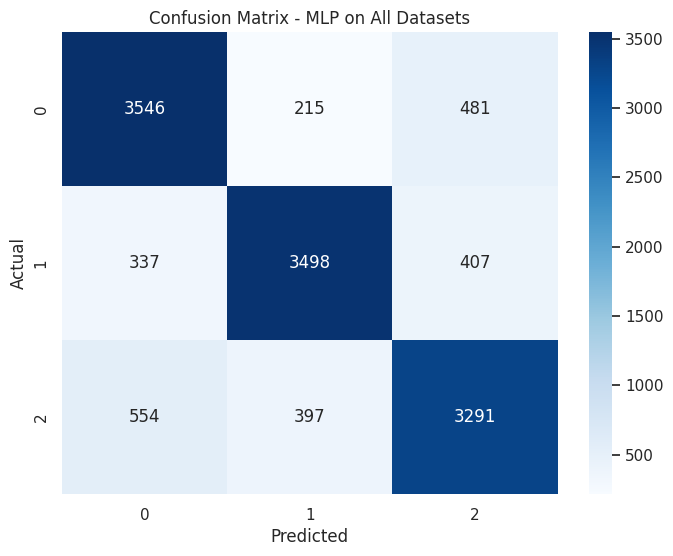

RNN Modeli için Toplam Karmaşıklık Matrisi:


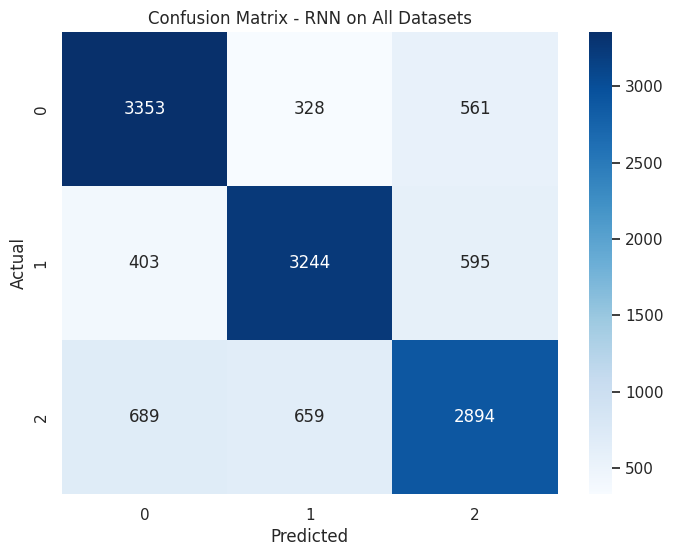

CNN Modeli için Toplam Karmaşıklık Matrisi:


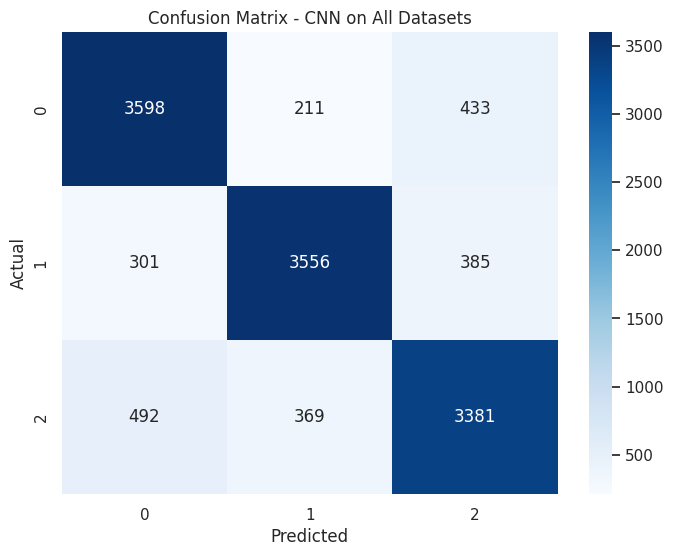

DBN Modeli için Toplam Karmaşıklık Matrisi:


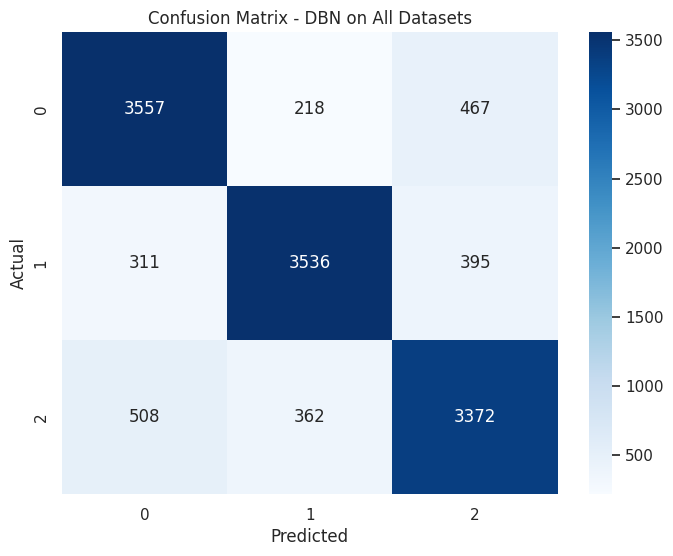

Autoencoder Modeli için Toplam Karmaşıklık Matrisi:


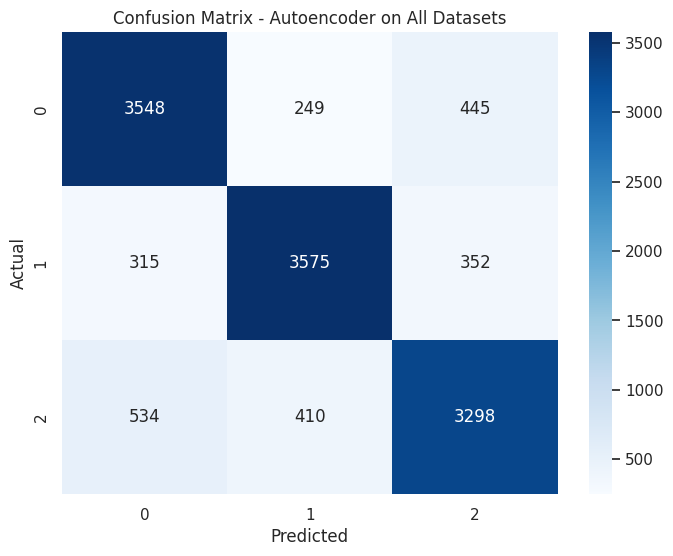

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# MLP Modeli
def create_mlp_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# RNN Modeli
def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(SimpleRNN(64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN Modeli
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# DBN Modeli
def create_dbn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Autoencoder Modeli
def create_autoencoder(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli Eğitme ve Test Etme
def train_and_predict_kfold(features, labels, model_name, input_dim, input_shape=None, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    total_cm = None

    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)

        if model_name == "MLP":
            model = create_mlp_model(input_dim, y_train.shape[1])
        elif model_name == "RNN":
            model = create_rnn_model((X_train.shape[1], 1), y_train.shape[1])
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        elif model_name == "CNN":
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
            model = create_cnn_model((X_train.shape[1], 1), y_train.shape[1])
        elif model_name == "DBN":
            model = create_dbn_model(input_dim, y_train.shape[1])
        elif model_name == "Autoencoder":
            model = create_autoencoder(input_dim, y_train.shape[1])

        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        cm = confusion_matrix(y_test_classes, y_pred_classes)
        if total_cm is None:
            total_cm = cm
        else:
            total_cm += cm

    return total_cm

# Karmaşıklık Matrisini Görselleştirme
def plot_confusion_matrix(cm, model_name, dataset_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
    plt.title(f'Confusion Matrix - {model_name} on {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def main():
    # Veri yolları
    paths = [
        "/content/drive/MyDrive/data_with_lda_train.csv",
        "/content/drive/MyDrive/data_with_lda_test.csv",
        "/content/drive/MyDrive/5_data_balanced.csv",
        "/content/drive/MyDrive/data_with_pca_normalized.csv"
    ]

    # Her model için karmaşıklık matrislerini toplamak
    confusion_matrices = {model: None for model in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]}

    # Her veri seti ile işlem yapılacak
    for path in paths:
        data = pd.read_csv(path)

        # Etiketler ve Özellikler
        labels = data.iloc[:, -1].values
        features = data.iloc[:, :-1].values

        print(f"Veri seti: {path}")
        print(f"Etiketlerin ilk 5 değeri: {labels[:5]}")
        print(f"Özelliklerin boyutu: {features.shape}")

        # Her model için eğitim ve karmaşıklık matrisi toplama
        for model_name in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]:
            cm = train_and_predict_kfold(features, labels, model_name, features.shape[1])
            if confusion_matrices[model_name] is None:
                confusion_matrices[model_name] = cm
            else:
                confusion_matrices[model_name] += cm

    # Karmaşıklık Matrislerinin Görselleştirilmesi
    for model_name, cm in confusion_matrices.items():
        print(f"{model_name} Modeli için Toplam Karmaşıklık Matrisi:")
        plot_confusion_matrix(cm, model_name, "All Datasets")

if __name__ == "__main__":
    main()


Etiketlerin ilk 5 değeri: [0. 0. 0. 0. 0.]
Özelliklerin boyutu: (4242, 99)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MLP model doğruluğu: 0.8706


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RNN model doğruluğu: 0.7006


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
CNN model doğruluğu: 0.8699


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
DBN model doğruluğu: 0.8706


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Autoencoder model doğruluğu: 0.8680


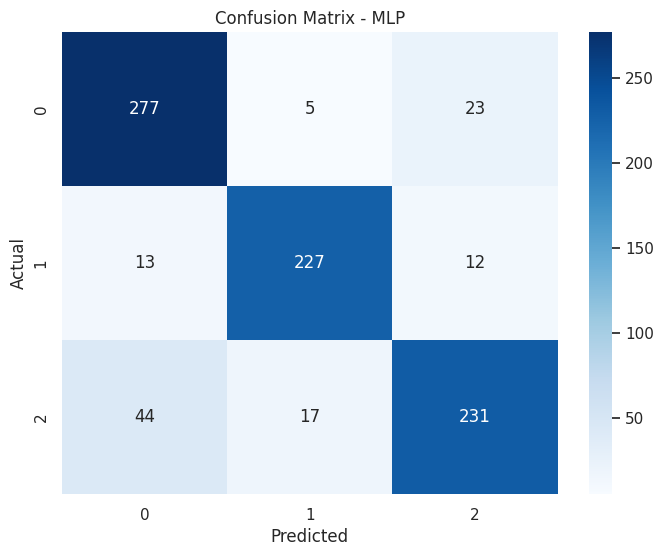

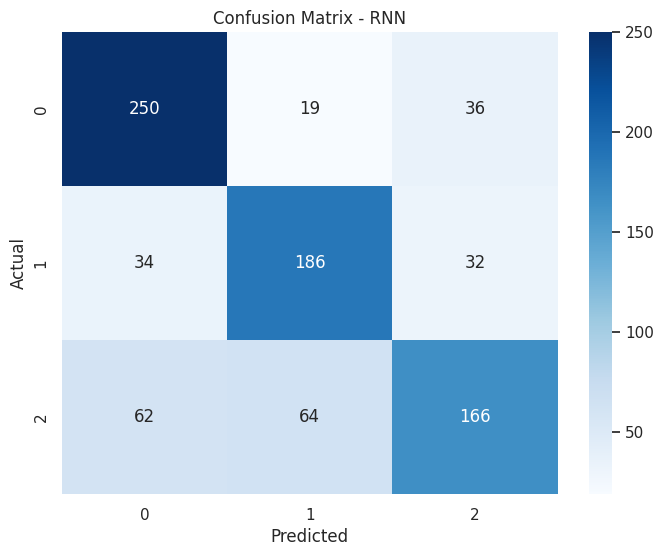

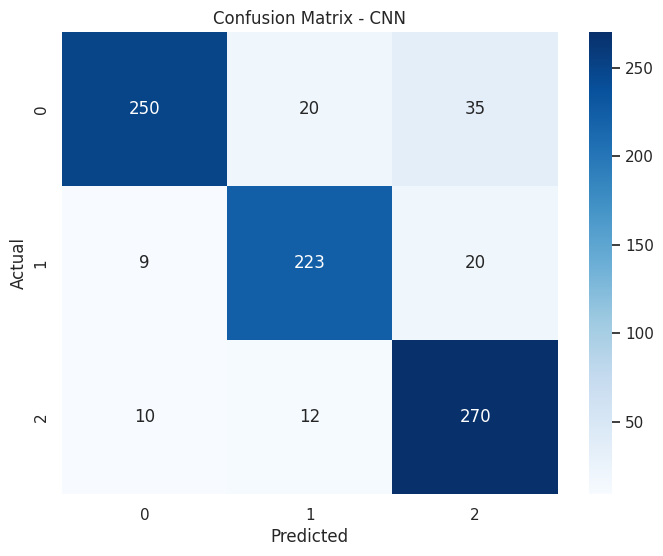

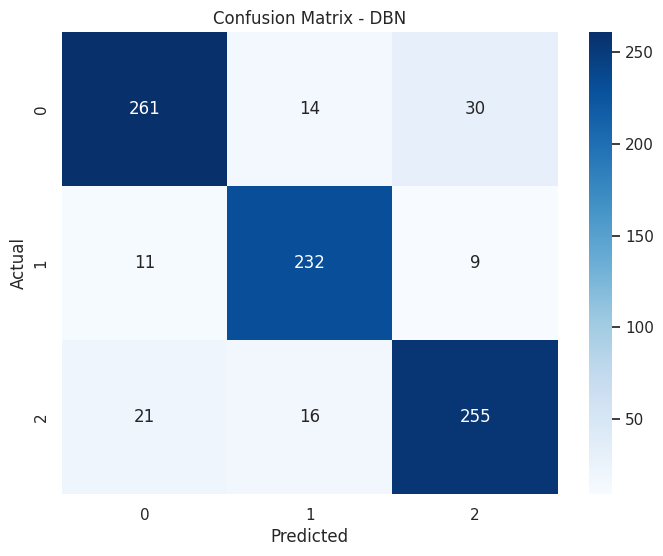

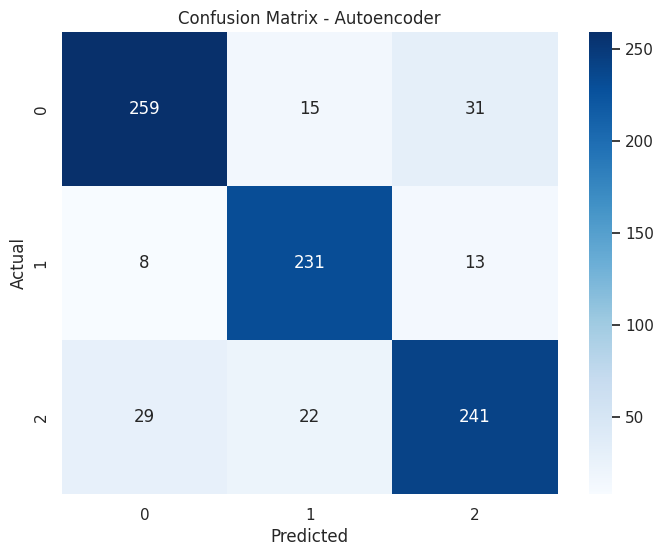

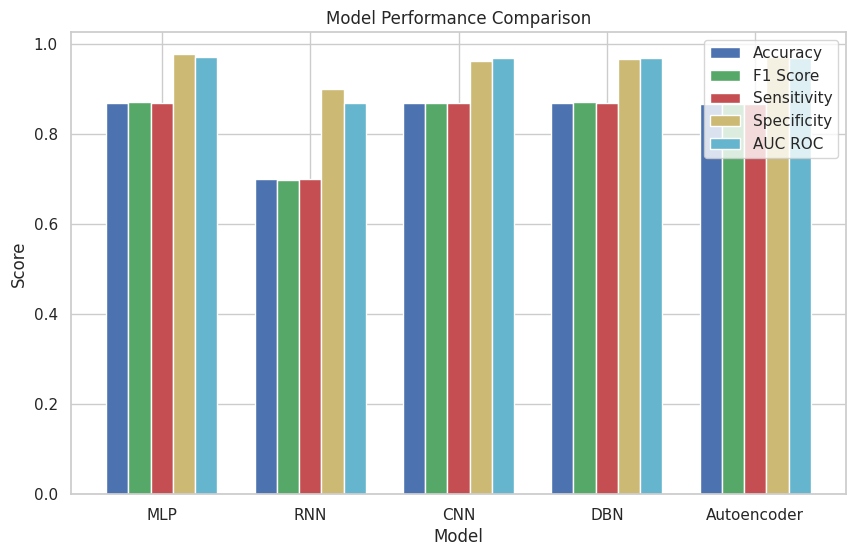

Sonuçlar 'dl_model_performance_results_kfold.csv' dosyasına kaydedildi.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, LSTM, SimpleRNN, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import to_categorical
import seaborn as sns

# MLP Modeli
def create_mlp_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# RNN Modeli
def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(SimpleRNN(64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN Modeli
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# DBN Modeli (Deep Belief Network)
def create_dbn_model(input_dim, num_classes):
    model = create_mlp_model(input_dim, num_classes)
    return model

# Autoencoder Modeli (Sınıflandırma için)
def create_autoencoder(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Sınıflandırma amaçlı çıkış katmanı
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli Eğitme ve Test Etme
def train_and_predict(features, labels, model_name, input_dim, input_shape=None, kfold_splits=5):
    # K-Fold çapraz doğrulama
    kfold = KFold(n_splits=kfold_splits, shuffle=True, random_state=42)

    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []
    auc_roc_scores = []
    cm_list = []

    for train_index, test_index in kfold.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Verilerin ölçeklendirilmesi
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Etiketlerin one-hot encoding formatına çevrilmesi
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)

        # Modelin oluşturulması
        if model_name == "MLP":
            model = create_mlp_model(input_dim, y_train.shape[1])
        elif model_name == "RNN":
            model = create_rnn_model((X_train.shape[1], 1), y_train.shape[1])
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        elif model_name == "CNN":
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # X_train için 3D şekil
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # X_test için 3D şekil
            model = create_cnn_model((X_train.shape[1], 1), y_train.shape[1])
        elif model_name == "DBN":
            model = create_dbn_model(input_dim, y_train.shape[1])
        elif model_name == "Autoencoder":
            model = create_autoencoder(input_dim, y_train.shape[1])

        # Modeli eğitme
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Tahmin yapma
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        # Başarıyı hesaplama
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        accuracies.append(accuracy)

        # Diğer metrikleri hesaplama
        f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
        f1_scores.append(f1)

        sensitivity = recall_score(y_test_classes, y_pred_classes, average='weighted')
        sensitivities.append(sensitivity)

        # Specificity hesaplama (True Negatives / (True Negatives + False Positives))
        cm = confusion_matrix(y_test_classes, y_pred_classes)
        specificity = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
        specificities.append(specificity)

        # AUC ROC hesaplama
        auc_roc = roc_auc_score(y_test, y_pred, multi_class='ovr')
        auc_roc_scores.append(auc_roc)

        cm_list.append(cm)

    # Ortalama metrikleri hesaplama
    metrics = {
        'accuracy': np.mean(accuracies),
        'f1': np.mean(f1_scores),
        'sensitivity': np.mean(sensitivities),
        'specificity': np.mean(specificities),
        'auc_roc': np.mean(auc_roc_scores),
        'confusion_matrix': cm_list
    }

    return metrics

# Karmaşıklık Matrisini Görselleştirme
def plot_confusion_matrix(cm, model_name, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Karmaşıklık matrisini kaydetme
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Model Performanslarını Görselleştirme
def plot_model_performance(metrics):
    model_names = list(metrics.keys())
    accuracy_values = [metrics[model]['accuracy'] for model in model_names]
    f1_values = [metrics[model]['f1'] for model in model_names]
    sensitivity_values = [metrics[model]['sensitivity'] for model in model_names]
    specificity_values = [metrics[model]['specificity'] for model in model_names]
    auc_roc_values = [metrics[model]['auc_roc'] for model in model_names]

    # Performans metriklerini bar grafiğiyle görselleştirme
    bar_width = 0.15
    x = np.arange(len(model_names))

    plt.figure(figsize=(10, 6))

    plt.bar(x - 2*bar_width, accuracy_values, bar_width, label='Accuracy', color='b')
    plt.bar(x - bar_width, f1_values, bar_width, label='F1 Score', color='g')
    plt.bar(x, sensitivity_values, bar_width, label='Sensitivity', color='r')
    plt.bar(x + bar_width, specificity_values, bar_width, label='Specificity', color='y')
    plt.bar(x + 2*bar_width, auc_roc_values, bar_width, label='AUC ROC', color='c')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.show()

def main():
    # Veri setini yükleme
    file_path = "/content/drive/MyDrive/5_data_balanced.csv"
    data = pd.read_csv(file_path)

    # Etiketler ve özelliklerin ayrılması
    labels = data.iloc[:, -1].values
    features = data.iloc[:, :-1].values

    print(f"Etiketlerin ilk 5 değeri: {labels[:5]}")
    print(f"Özelliklerin boyutu: {features.shape}")

    # Model performanslarını saklayacak bir sözlük
    metrics = {}

    # Modelleri eğitme ve doğruluklarını saklama
    for model_name in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]:
        metrics[model_name] = train_and_predict(features, labels, model_name, features.shape[1])

        print(f"{model_name} model doğruluğu: {metrics[model_name]['accuracy']:.4f}")

        # Karmaşıklık matrisini görselleştirme ve kaydetme
        plot_confusion_matrix(metrics[model_name]['confusion_matrix'][0], model_name, save_path=f'{model_name}_confusion_matrix.png')

    # Modellerin performanslarını görselleştirme
    plot_model_performance(metrics)

    # Sonuçları bir CSV dosyasına kaydetme
    results_df = pd.DataFrame(metrics).T
    results_df.to_csv("/content/drive/MyDrive/dl_model_performance_results_kfold.csv")
    print("Sonuçlar 'dl_model_performance_results_kfold.csv' dosyasına kaydedildi.")

if __name__ == "__main__":
    main()


Etiketlerin ilk 5 değeri: [0. 0. 0. 0. 0.]
Özelliklerin boyutu: (4242, 12)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP model doğruluğu: 0.8197


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RNN model doğruluğu: 0.7977


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
CNN model doğruluğu: 0.8168


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
DBN model doğruluğu: 0.8138


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Autoencoder model doğruluğu: 0.8244


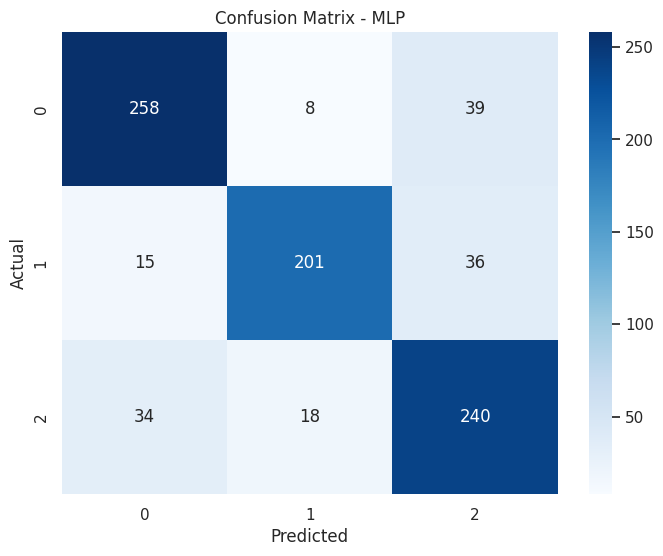

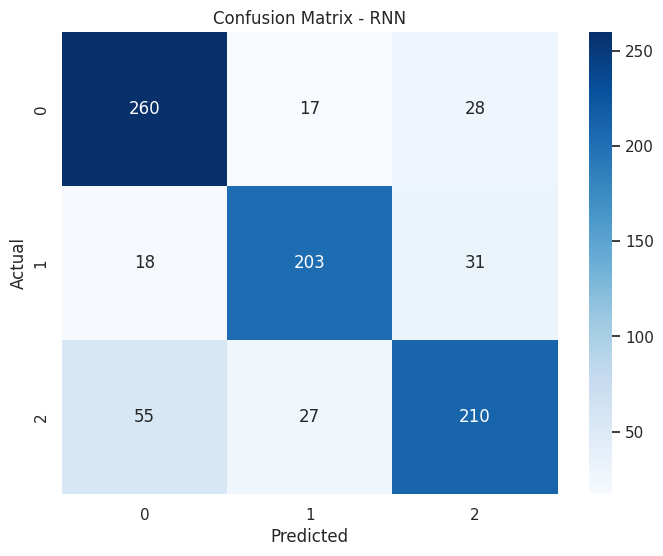

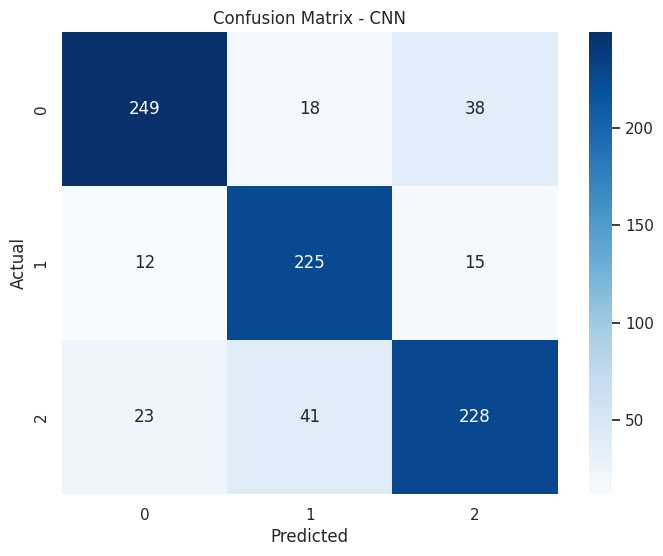

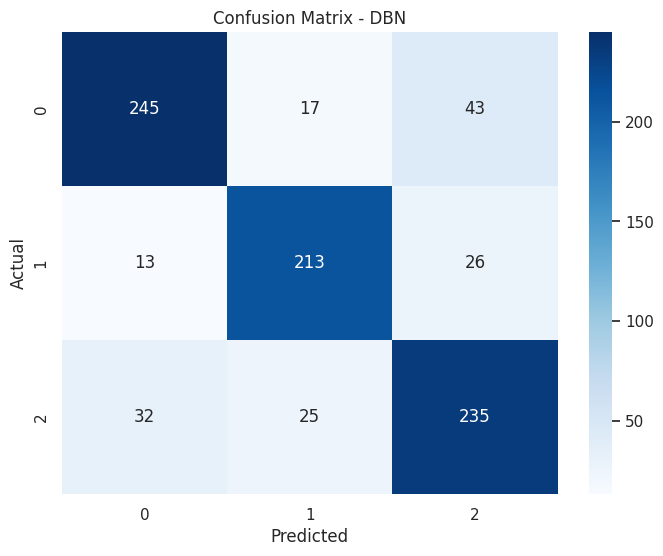

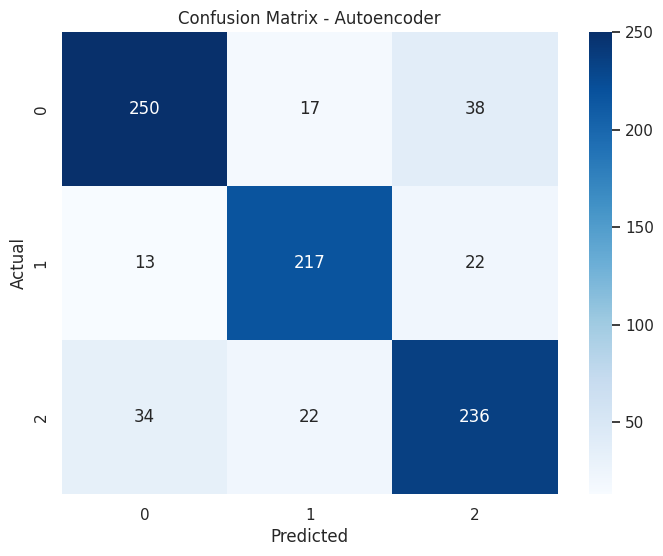

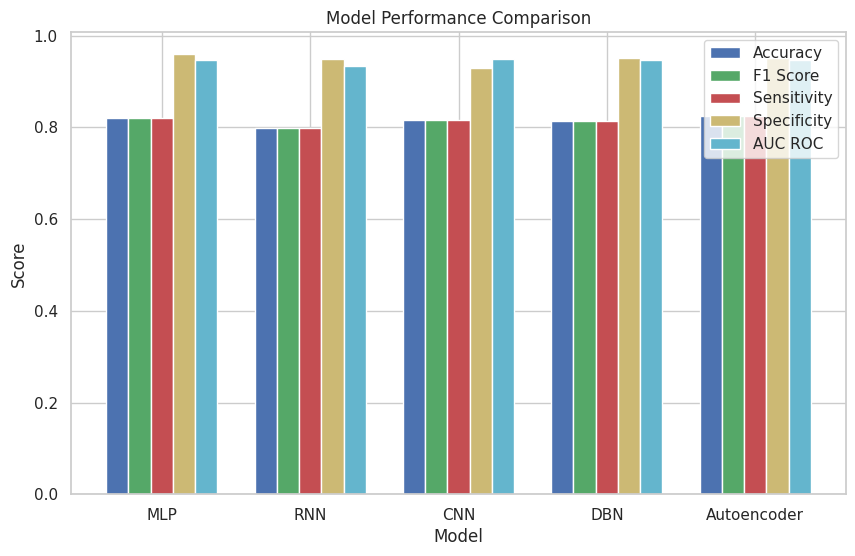

Sonuçlar 'dl_pca_model_performance_results_kfold.csv' dosyasına kaydedildi.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, LSTM, SimpleRNN, Dropout
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import to_categorical
import seaborn as sns

# MLP Modeli
def create_mlp_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# RNN Modeli
def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(SimpleRNN(64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN Modeli
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# DBN Modeli (Deep Belief Network)
def create_dbn_model(input_dim, num_classes):
    model = create_mlp_model(input_dim, num_classes)
    return model

# Autoencoder Modeli (Sınıflandırma için)
def create_autoencoder(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Sınıflandırma amaçlı çıkış katmanı
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli Eğitme ve Test Etme
def train_and_predict(features, labels, model_name, input_dim, input_shape=None, kfold_splits=5):
    # K-Fold çapraz doğrulama
    kfold = KFold(n_splits=kfold_splits, shuffle=True, random_state=42)

    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []
    auc_roc_scores = []
    cm_list = []

    for train_index, test_index in kfold.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Verilerin ölçeklendirilmesi
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Etiketlerin one-hot encoding formatına çevrilmesi
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)

        # Modelin oluşturulması
        if model_name == "MLP":
            model = create_mlp_model(input_dim, y_train.shape[1])
        elif model_name == "RNN":
            model = create_rnn_model((X_train.shape[1], 1), y_train.shape[1])
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        elif model_name == "CNN":
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # X_train için 3D şekil
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # X_test için 3D şekil
            model = create_cnn_model((X_train.shape[1], 1), y_train.shape[1])
        elif model_name == "DBN":
            model = create_dbn_model(input_dim, y_train.shape[1])
        elif model_name == "Autoencoder":
            model = create_autoencoder(input_dim, y_train.shape[1])

        # Modeli eğitme
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Tahmin yapma
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        # Başarıyı hesaplama
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        accuracies.append(accuracy)

        # Diğer metrikleri hesaplama
        f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
        f1_scores.append(f1)

        sensitivity = recall_score(y_test_classes, y_pred_classes, average='weighted')
        sensitivities.append(sensitivity)

        # Specificity hesaplama (True Negatives / (True Negatives + False Positives))
        cm = confusion_matrix(y_test_classes, y_pred_classes)
        specificity = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
        specificities.append(specificity)

        # AUC ROC hesaplama
        auc_roc = roc_auc_score(y_test, y_pred, multi_class='ovr')
        auc_roc_scores.append(auc_roc)

        cm_list.append(cm)

    # Ortalama metrikleri hesaplama
    metrics = {
        'accuracy': np.mean(accuracies),
        'f1': np.mean(f1_scores),
        'sensitivity': np.mean(sensitivities),
        'specificity': np.mean(specificities),
        'auc_roc': np.mean(auc_roc_scores),
        'confusion_matrix': cm_list
    }

    return metrics

# Karmaşıklık Matrisini Görselleştirme
def plot_confusion_matrix(cm, model_name, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Karmaşıklık matrisini kaydetme
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Model Performanslarını Görselleştirme
def plot_model_performance(metrics):
    model_names = list(metrics.keys())
    accuracy_values = [metrics[model]['accuracy'] for model in model_names]
    f1_values = [metrics[model]['f1'] for model in model_names]
    sensitivity_values = [metrics[model]['sensitivity'] for model in model_names]
    specificity_values = [metrics[model]['specificity'] for model in model_names]
    auc_roc_values = [metrics[model]['auc_roc'] for model in model_names]

    # Performans metriklerini bar grafiğiyle görselleştirme
    bar_width = 0.15
    x = np.arange(len(model_names))

    plt.figure(figsize=(10, 6))

    plt.bar(x - 2*bar_width, accuracy_values, bar_width, label='Accuracy', color='b')
    plt.bar(x - bar_width, f1_values, bar_width, label='F1 Score', color='g')
    plt.bar(x, sensitivity_values, bar_width, label='Sensitivity', color='r')
    plt.bar(x + bar_width, specificity_values, bar_width, label='Specificity', color='y')
    plt.bar(x + 2*bar_width, auc_roc_values, bar_width, label='AUC ROC', color='c')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.show()

def main():
    # Veri setini yükleme
    file_path = "/content/drive/MyDrive/data_with_pca_normalized.csv"
    data = pd.read_csv(file_path)

    # Etiketler ve özelliklerin ayrılması
    labels = data.iloc[:, -1].values
    features = data.iloc[:, :-1].values

    print(f"Etiketlerin ilk 5 değeri: {labels[:5]}")
    print(f"Özelliklerin boyutu: {features.shape}")

    # Model performanslarını saklayacak bir sözlük
    metrics = {}

    # Modelleri eğitme ve doğruluklarını saklama
    for model_name in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]:
        metrics[model_name] = train_and_predict(features, labels, model_name, features.shape[1])

        print(f"{model_name} model doğruluğu: {metrics[model_name]['accuracy']:.4f}")

        # Karmaşıklık matrisini görselleştirme ve kaydetme
        plot_confusion_matrix(metrics[model_name]['confusion_matrix'][0], model_name, save_path=f'{model_name}_confusion_matrix.png')

    # Modellerin performanslarını görselleştirme
    plot_model_performance(metrics)

    # Sonuçları bir CSV dosyasına kaydetme
    results_df = pd.DataFrame(metrics).T
    results_df.to_csv("/content/drive/MyDrive/dl_pca_model_performance_results_kfold.csv")
    print("Sonuçlar 'dl_pca_model_performance_results_kfold.csv' dosyasına kaydedildi.")

if __name__ == "__main__":
    main()


Etiketlerin ilk 5 değeri (Eğitim): [2. 1. 0. 0. 1.]
Özelliklerin boyutu (Eğitim): (3393, 2)
Etiketlerin ilk 5 değeri (Test): [1. 0. 2. 0. 2.]
Özelliklerin boyutu (Test): (849, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP modelinin K-Fold sonuçları:
Ortalama Doğruluk: 0.7604
Ortalama F1 Skoru: 0.7601
Ortalama Hassasiyet: 0.7604
Ortalama Spesifite: 0.9203
Ortalama AUC ROC: 0.9057


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
RNN modelinin K-Fold sonuçları:
Ortalama Doğruluk: 0.7598
Ortalama F1 Skoru: 0.7594
Ortalama Hassasiyet: 0.7598
Ortalama Spesifite: 0.9144
Ortalama AUC ROC: 0.9058


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
CNN modelinin K-Fold sonuçları:
Ortalama Doğruluk: 0.7586
Ortalama F1 Skoru: 0.7583
Ortalama Hassasiyet: 0.7586
Ortalama Spesifite: 0.9151
Ortalama AUC ROC: 0.9058


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
DBN modelinin K-Fold sonuçları:
Ortalama Doğruluk: 0.7633
Ortalama F1 Skoru: 0.7632
Ortalama Hassasiyet: 0.7633
Ortalama Spesifite: 0.9223
Ortalama AUC ROC: 0.9059


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Autoencoder modelinin K-Fold sonuçları:
Ortalama Doğruluk: 0.7572
Ortalama F1 Skoru: 0.7565
Ortalama Hassasiyet: 0.7572
Ortalama Spesifite: 0.9167
Ortalama AUC ROC: 0.9060


<Figure size 1200x800 with 0 Axes>

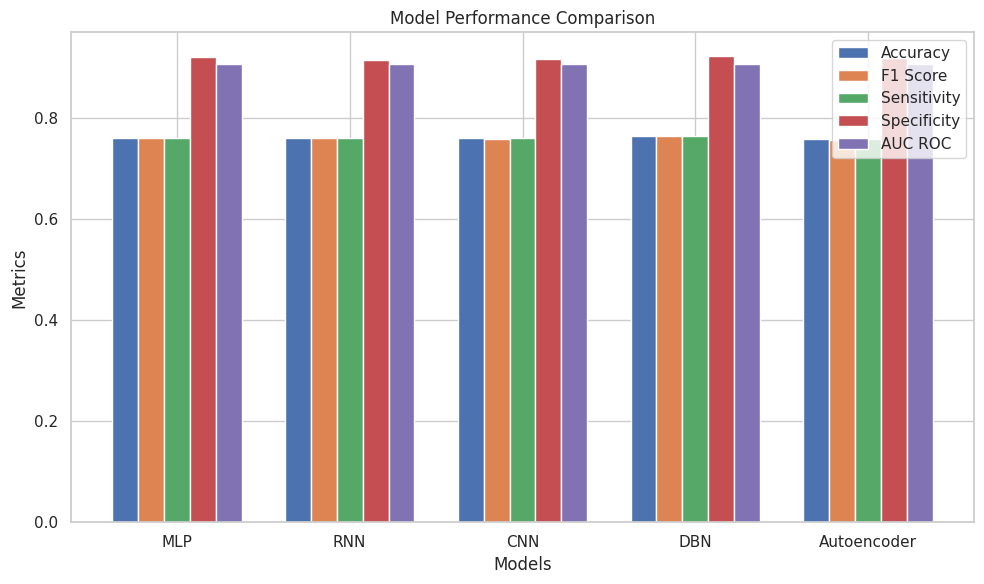

Sonuçlar /content/drive/MyDrive/dl_lda_model_results_kfold.csv dosyasına kaydedildi.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import to_categorical
import seaborn as sns
from keras.layers import GlobalAveragePooling1D
from sklearn.model_selection import KFold

# MLP Modeli
def create_mlp_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# RNN Modeli
def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(SimpleRNN(64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN Modeli
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# DBN Modeli
def create_dbn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Autoencoder Modeli
def create_autoencoder(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_predict_with_kfold(features, labels, model_name, input_dim, input_shape=None, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for train_index, val_index in kf.split(features):
        X_train, X_val = features[train_index], features[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        y_train = to_categorical(y_train)
        y_val = to_categorical(y_val)

        if model_name == "MLP":
            model = create_mlp_model(input_dim, y_train.shape[1])
        elif model_name == "RNN":
            model = create_rnn_model((X_train.shape[1], 1), y_train.shape[1])
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        elif model_name == "CNN":
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
            model = create_cnn_model((X_train.shape[1], 1), y_train.shape[1])
        elif model_name == "DBN":
            model = create_dbn_model(input_dim, y_train.shape[1])
        elif model_name == "Autoencoder":
            model = create_autoencoder(input_dim, y_train.shape[1])

        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        y_pred = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_val_classes = np.argmax(y_val, axis=1)

        accuracy = accuracy_score(y_val_classes, y_pred_classes)
        f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
        sensitivity = recall_score(y_val_classes, y_pred_classes, average='weighted')

        cm = confusion_matrix(y_val_classes, y_pred_classes)
        specificity = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0

        auc_roc = roc_auc_score(y_val, y_pred, multi_class='ovr')

        fold_metrics.append({
            'accuracy': accuracy,
            'f1': f1,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'auc_roc': auc_roc,
            'confusion_matrix': cm
        })

    # Ortalama metrikleri hesapla
    avg_metrics = {
        'accuracy': np.mean([fold['accuracy'] for fold in fold_metrics]),
        'f1': np.mean([fold['f1'] for fold in fold_metrics]),
        'sensitivity': np.mean([fold['sensitivity'] for fold in fold_metrics]),
        'specificity': np.mean([fold['specificity'] for fold in fold_metrics]),
        'auc_roc': np.mean([fold['auc_roc'] for fold in fold_metrics])
    }

    return avg_metrics, fold_metrics

# Sonuçları Kaydetme ve Görselleştirme
def save_results_to_csv(metrics, file_name="/content/drive/MyDrive/dl_lda_model_results_kfold.csv"):
    results_df = pd.DataFrame.from_dict(metrics, orient='index')
    results_df.to_csv(file_name)
    print(f"Sonuçlar {file_name} dosyasına kaydedildi.")

def plot_model_performance(metrics):
    models = list(metrics.keys())
    avg_accuracy = [metrics[model]['accuracy'] for model in models]
    avg_f1 = [metrics[model]['f1'] for model in models]
    avg_sensitivity = [metrics[model]['sensitivity'] for model in models]
    avg_specificity = [metrics[model]['specificity'] for model in models]
    avg_auc_roc = [metrics[model]['auc_roc'] for model in models]

    plt.figure(figsize=(12, 8))

    x = np.arange(len(models))
    width = 0.15  # Bar width

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - 2*width, avg_accuracy, width, label='Accuracy')
    ax.bar(x - width, avg_f1, width, label='F1 Score')
    ax.bar(x, avg_sensitivity, width, label='Sensitivity')
    ax.bar(x + width, avg_specificity, width, label='Specificity')
    ax.bar(x + 2*width, avg_auc_roc, width, label='AUC ROC')

    ax.set_xlabel('Models')
    ax.set_ylabel('Metrics')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    plt.tight_layout()
    plt.show()

def main():
    train_file_path = "/content/drive/MyDrive/data_with_lda_train.csv"
    test_file_path = "/content/drive/MyDrive/data_with_lda_test.csv"

    train_data = pd.read_csv(train_file_path)
    test_data = pd.read_csv(test_file_path)

    train_labels = train_data.iloc[:, -1].values
    train_features = train_data.iloc[:, :-1].values

    test_labels = test_data.iloc[:, -1].values
    test_features = test_data.iloc[:, :-1].values

    print(f"Etiketlerin ilk 5 değeri (Eğitim): {train_labels[:5]}")
    print(f"Özelliklerin boyutu (Eğitim): {train_features.shape}")
    print(f"Etiketlerin ilk 5 değeri (Test): {test_labels[:5]}")
    print(f"Özelliklerin boyutu (Test): {test_features.shape}")

    metrics = {}

    for model_name in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]:
        avg_metrics, fold_metrics = train_and_predict_with_kfold(train_features, train_labels, model_name, train_features.shape[1])

        metrics[model_name] = avg_metrics

        print(f"{model_name} modelinin K-Fold sonuçları:")
        print(f"Ortalama Doğruluk: {avg_metrics['accuracy']:.4f}")
        print(f"Ortalama F1 Skoru: {avg_metrics['f1']:.4f}")
        print(f"Ortalama Hassasiyet: {avg_metrics['sensitivity']:.4f}")
        print(f"Ortalama Spesifite: {avg_metrics['specificity']:.4f}")
        print(f"Ortalama AUC ROC: {avg_metrics['auc_roc']:.4f}")

    plot_model_performance(metrics)
    save_results_to_csv(metrics)

if __name__ == "__main__":
    main()


# HİBRİT MODEL EĞİTİM VE PERFORMANSI
 Hibrit model PCA ,LDA ve NO_PCA_LDA için her bir foldun performans metriklerinin hesaplanması ve kaydedilmesi ardından tüm sonuçları bar grafiğinde gösterilmek için birleştirilmesini, karmaşıklık matrisini içerir.

In [ ]:
pip install tensorflow


In [ ]:
#HER BİR FOLD UN METİKLERİNİ AYRI AYARI HESAPLAYIP YAZDIRIYOR.
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape
import matplotlib.pyplot as plt
import seaborn as sns

# Veri Yükleme
balanced_data = pd.read_csv("/content/drive/MyDrive/5_data_balanced.csv")

# Veriyi 3D CNN için Yeniden Şekillendirme
def reshape_for_3d_cnn(X, time_steps=10):
    num_features = X.shape[1]
    if num_features % time_steps != 0:
        # Fazlalık özellikleri atmak için boyutu ayarla
        X = X[:, :(num_features // time_steps) * time_steps]
    features_per_step = X.shape[1] // time_steps
    return X.reshape(-1, time_steps, features_per_step, 1, 1)

# Hibrit Model Tanımlama (3D CNN + LSTM)
def create_hybrid_model(time_steps, features_per_step):
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 1), activation='relu', padding='same',
               input_shape=(time_steps, features_per_step, 1, 1)),
        MaxPooling3D(pool_size=(2, 2, 1)),
        Flatten(),
        Reshape((time_steps, -1)),
        TimeDistributed(Dense(64, activation='relu')),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Değerlendirme Fonksiyonu
def evaluate_model(y_test_classes, y_pred_classes, y_test, y_pred_prob):
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    sensitivity = recall_score(y_test_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    specificity = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    try:
        auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')
    except ValueError:
        auc_roc = None
    try:
        precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
    except ValueError:
        precision = None
    return accuracy, f1, sensitivity, specificity, precision, auc_roc, cm

# K-Fold Çapraz Doğrulama
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = balanced_data.iloc[:, :-1].values
y = balanced_data.iloc[:, -1].values
time_steps = 10

fold = 1
results = []
for train_idx, test_idx in kfold.split(X, y):
    print(f"Fold {fold} Başlıyor...")

    # Eğitim ve Test Verilerini Ayırma
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Veriyi Yeniden Şekillendirme
    X_train = reshape_for_3d_cnn(X_train, time_steps)
    X_test = reshape_for_3d_cnn(X_test, time_steps)

    # Modeli Oluşturma
    model = create_hybrid_model(time_steps, X_train.shape[2])

    # Modeli Eğitme
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Tahminler
    y_pred_classes = np.argmax(model.predict(X_test), axis=1)
    y_pred_prob = model.predict(X_test)

    # Değerlendirme
    accuracy, f1, sensitivity, specificity, precision, auc_roc, cm = evaluate_model(y_test, y_pred_classes, y_test, y_pred_prob)
    results.append({
        "Fold": fold,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "AUC ROC": auc_roc
    })

    print(f"Fold {fold} Sonuçları:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Precision: {precision}")
    print(f"AUC ROC: {auc_roc}")
    print(f"Confusion Matrix: \n{cm}")
    fold += 1

# Tüm Fold Sonuçlarını Kaydetme
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/hibrit_no_kfold_results.csv", index=False)

# Ortalama Sonuçları Yazdırma
print("\nK-Fold Ortalamaları:")
print(results_df.mean())


Fold 1 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.3554 - loss: 1.0959 - val_accuracy: 0.4441 - val_loss: 1.0385
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.4623 - loss: 1.0343 - val_accuracy: 0.5324 - val_loss: 0.9643
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.5436 - loss: 0.9201 - val_accuracy: 0.5807 - val_loss: 0.8905
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5579 - loss: 0.9029 - val_accuracy: 0.5984 - val_loss: 0.8647
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5718 - loss: 0.8795 - val_accuracy: 0.6066 - val_loss: 0.8836
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5795 - loss: 0.8657 - val_accuracy: 0.5960 - val_loss: 0.8536
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6138 - loss: 0.8225 - val_accuracy: 0.6148 - val_loss: 0.8287
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6243 - loss: 0.8188 - val_accuracy: 0.5

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3399 - loss: 1.1015 - val_accuracy: 0.4794 - val_loss: 1.0635
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4791 - loss: 1.0232 - val_accuracy: 0.5607 - val_loss: 0.9394
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5418 - loss: 0.9303 - val_accuracy: 0.5583 - val_loss: 0.8911
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5698 - loss: 0.8949 - val_accuracy: 0.5501 - val_loss: 0.8917
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5745 - loss: 0.8877 - val_accuracy: 0.6290 - val_loss: 0.8271
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5841 - loss: 0.8698 - val_accuracy: 0.6243 - val_loss: 0.8194
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6031 - loss: 0.8516 - val_accuracy: 0.6066 - val_loss: 0.8183
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6134 - loss: 0.8530 - val_accuracy: 0.621

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.3359 - loss: 1.1017 - val_accuracy: 0.4540 - val_loss: 1.0813
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4048 - loss: 1.0711 - val_accuracy: 0.5778 - val_loss: 0.9401
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5592 - loss: 0.9207 - val_accuracy: 0.6002 - val_loss: 0.8843
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5608 - loss: 0.8963 - val_accuracy: 0.5401 - val_loss: 0.8974
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5774 - loss: 0.8768 - val_accuracy: 0.6050 - val_loss: 0.8478
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6032 - loss: 0.8467 - val_accuracy: 0.6226 - val_loss: 0.8206
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6195 - loss: 0.8343 - val_accuracy: 0.6498 - val_loss: 0.8142
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6266 - loss: 0.8078 - val_accuracy: 0.636

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.3459 - loss: 1.0990 - val_accuracy: 0.5165 - val_loss: 1.0482
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4688 - loss: 1.0134 - val_accuracy: 0.5330 - val_loss: 0.9235
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5649 - loss: 0.8972 - val_accuracy: 0.5495 - val_loss: 0.9276
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5587 - loss: 0.8932 - val_accuracy: 0.5625 - val_loss: 0.8792
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5904 - loss: 0.8427 - val_accuracy: 0.5802 - val_loss: 0.8792
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.6182 - loss: 0.8551 - val_accuracy: 0.5542 - val_loss: 0.8768
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5983 - loss: 0.8433 - val_accuracy: 0.6038 - val_loss: 0.8246
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5988 - loss: 0.8290 - val_accuracy: 0.626

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3383 - loss: 1.1023 - val_accuracy: 0.5389 - val_loss: 1.0738
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4377 - loss: 1.0605 - val_accuracy: 0.5979 - val_loss: 0.9532
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5358 - loss: 0.9478 - val_accuracy: 0.5884 - val_loss: 0.8606
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5636 - loss: 0.9134 - val_accuracy: 0.5366 - val_loss: 0.9043
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5645 - loss: 0.9224 - val_accuracy: 0.6050 - val_loss: 0.8096
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5910 - loss: 0.8712 - val_accuracy: 0.5979 - val_loss: 0.8560
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6025 - loss: 0.8483 - val_accuracy: 0.6026 - val_loss: 0.8050
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6307 - loss: 0.8335 - val_accuracy: 0.633

In [ ]:
#HER BİR FOLD UN METRİKLERİNİ HESAPLAYIP YAZDIRIYOR
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape
import matplotlib.pyplot as plt
import seaborn as sns

# Veri Yükleme
balanced_data = pd.read_csv("/content/drive/MyDrive/data_with_pca_normalized.csv")

# Veriyi 3D CNN için Yeniden Şekillendirme
def reshape_for_3d_cnn(X, time_steps=10):
    num_features = X.shape[1]
    if num_features % time_steps != 0:
        # Fazlalık özellikleri atmak için boyutu ayarla
        X = X[:, :(num_features // time_steps) * time_steps]
    features_per_step = X.shape[1] // time_steps
    return X.reshape(-1, time_steps, features_per_step, 1, 1)

# Hibrit Model Tanımlama (3D CNN + LSTM)
def create_hybrid_model(time_steps, features_per_step):
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 1), activation='relu', padding='same', input_shape=(time_steps, features_per_step, 1, 1)),
        MaxPooling3D(pool_size=(1, 1, 1)),  # Havuzlama boyutunu girişe uyarladık
        Flatten(),
        Reshape((time_steps, -1)),  # Veriyi zaman adımlarına göre yeniden şekillendir
        TimeDistributed(Dense(64, activation='relu')),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Değerlendirme Fonksiyonu
def evaluate_model(y_test_classes, y_pred_classes, y_test, y_pred_prob):
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    sensitivity = recall_score(y_test_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    specificity = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    try:
        auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')
    except ValueError:
        auc_roc = None
    try:
        precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
    except ValueError:
        precision = None
    return accuracy, f1, sensitivity, specificity, precision, auc_roc, cm

# K-Fold Çapraz Doğrulama
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = balanced_data.iloc[:, :-1].values
y = balanced_data.iloc[:, -1].values
time_steps = 10

fold = 1
results = []
for train_idx, test_idx in kfold.split(X, y):
    print(f"Fold {fold} Başlıyor...")

    # Eğitim ve Test Verilerini Ayırma
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Veriyi Yeniden Şekillendirme
    X_train = reshape_for_3d_cnn(X_train, time_steps)
    X_test = reshape_for_3d_cnn(X_test, time_steps)

    # Modeli Oluşturma
    model = create_hybrid_model(time_steps, X_train.shape[2])

    # Modeli Eğitme
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Tahminler
    y_pred_classes = np.argmax(model.predict(X_test), axis=1)
    y_pred_prob = model.predict(X_test)

    # Değerlendirme
    accuracy, f1, sensitivity, specificity, precision, auc_roc, cm = evaluate_model(y_test, y_pred_classes, y_test, y_pred_prob)
    results.append({
        "Fold": fold,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "AUC ROC": auc_roc
    })

    print(f"Fold {fold} Sonuçları:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Precision: {precision}")
    print(f"AUC ROC: {auc_roc}")
    print(f"Confusion Matrix: \n{cm}")
    fold += 1

# Tüm Fold Sonuçlarını Kaydetme
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/hibrit_pca_kfold_results.csv", index=False)

# Ortalama Sonuçları Yazdırma
print("\nK-Fold Ortalamaları:")
print(results_df.mean())


Fold 1 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.4306 - loss: 1.0530 - val_accuracy: 0.5041 - val_loss: 0.9801
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5414 - loss: 0.9402 - val_accuracy: 0.5807 - val_loss: 0.9265
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5804 - loss: 0.8974 - val_accuracy: 0.5936 - val_loss: 0.8861
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6233 - loss: 0.8327 - val_accuracy: 0.6360 - val_loss: 0.8377
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6307 - loss: 0.7903 - val_accuracy: 0.5866 - val_loss: 0.8544
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6545 - loss: 0.7677 - val_accuracy: 0.6431 - val_loss: 0.7865
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6634 - loss: 0.7340 - val_accuracy: 0.6714 - val_loss: 0.7909
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6678 - loss: 0.7583 - val_accuracy: 0.697

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.4128 - loss: 1.0628 - val_accuracy: 0.5489 - val_loss: 0.9294
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5173 - loss: 0.9526 - val_accuracy: 0.5995 - val_loss: 0.8792
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5880 - loss: 0.8864 - val_accuracy: 0.6243 - val_loss: 0.8148
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6010 - loss: 0.8572 - val_accuracy: 0.5866 - val_loss: 0.8566
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6399 - loss: 0.8136 - val_accuracy: 0.6549 - val_loss: 0.7486
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6590 - loss: 0.7695 - val_accuracy: 0.6796 - val_loss: 0.7292
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6778 - loss: 0.7382 - val_accuracy: 0.6749 - val_loss: 0.7153
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6814 - loss: 0.7364 - val_acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4593 - loss: 1.0474 - val_accuracy: 0.5236 - val_loss: 0.9957
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5478 - loss: 0.9412 - val_accuracy: 0.5708 - val_loss: 0.8972
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5811 - loss: 0.8905 - val_accuracy: 0.5991 - val_loss: 0.8612
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6014 - loss: 0.8631 - val_accuracy: 0.6392 - val_loss: 0.7959
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6029 - loss: 0.8440 - val_accuracy: 0.6816 - val_loss: 0.7431
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6640 - loss: 0.7710 - val_accuracy: 0.6828 - val_loss: 0.7172
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6834 - loss: 0.7422 - val_accuracy: 0.7099 - val_loss: 0.6887
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6902 - loss: 0.7240 - val_accuracy: 0.713

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4151 - loss: 1.0588 - val_accuracy: 0.5059 - val_loss: 0.9657
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5307 - loss: 0.9488 - val_accuracy: 0.5802 - val_loss: 0.9033
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5727 - loss: 0.8946 - val_accuracy: 0.5790 - val_loss: 0.8812
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5933 - loss: 0.8574 - val_accuracy: 0.5896 - val_loss: 0.8432
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6168 - loss: 0.8177 - val_accuracy: 0.6380 - val_loss: 0.7830
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6640 - loss: 0.7666 - val_accuracy: 0.6486 - val_loss: 0.7784
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6583 - loss: 0.7292 - val_accuracy: 0.6592 - val_loss: 0.7473
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6903 - loss: 0.7006 - val_accuracy: 0.653

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4129 - loss: 1.0524 - val_accuracy: 0.5307 - val_loss: 0.9518
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5240 - loss: 0.9492 - val_accuracy: 0.5979 - val_loss: 0.8839
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5694 - loss: 0.9010 - val_accuracy: 0.6002 - val_loss: 0.8427
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6083 - loss: 0.8507 - val_accuracy: 0.6262 - val_loss: 0.7907
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6309 - loss: 0.8084 - val_accuracy: 0.6769 - val_loss: 0.7306
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6583 - loss: 0.7597 - val_accuracy: 0.6781 - val_loss: 0.7288
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6769 - loss: 0.7419 - val_accuracy: 0.6804 - val_loss: 0.7334
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6731 - loss: 0.7290 - val_accuracy: 0.715

In [ ]:
#HER BİR K FOLD İÇİN AYRI AYRI METRİKLERİ İÇERİR.
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape
import matplotlib.pyplot as plt
import seaborn as sns

# Veri Yükleme
train_data = pd.read_csv("/content/drive/MyDrive/data_with_lda_train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/data_with_lda_test.csv")

# Veriyi 3D CNN için Yeniden Şekillendirme
def reshape_for_3d_cnn(X, time_steps=10):
    num_features = X.shape[1]
    if num_features % time_steps != 0:
        # Fazlalık özellikleri atmak için boyutu ayarla
        X = X[:, :(num_features // time_steps) * time_steps]
    features_per_step = X.shape[1] // time_steps
    return X.reshape(-1, time_steps, features_per_step, 1, 1)

# Hibrit Model Tanımlama (3D CNN + LSTM)
def create_hybrid_model(time_steps, features_per_step):
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 1), activation='relu', padding='same', input_shape=(time_steps, features_per_step, 1, 1)),
        MaxPooling3D(pool_size=(1, 1, 1)),  # Havuzlama boyutunu girişe uyarladık
        Flatten(),
        Reshape((time_steps, -1)),  # Veriyi zaman adımlarına göre yeniden şekillendir
        TimeDistributed(Dense(64, activation='relu')),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Değerlendirme Fonksiyonu
def evaluate_model(y_test_classes, y_pred_classes, y_test, y_pred_prob):
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    sensitivity = recall_score(y_test_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    specificity = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    try:
        auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')
    except ValueError:
        auc_roc = None
    try:
        precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
    except ValueError:
        precision = None
    return accuracy, f1, sensitivity, specificity, precision, auc_roc, cm

# K-Fold Çapraz Doğrulama
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = balanced_data.iloc[:, :-1].values
y = balanced_data.iloc[:, -1].values
time_steps = 10

fold = 1
results = []
for train_idx, test_idx in kfold.split(X, y):
    print(f"Fold {fold} Başlıyor...")

    # Eğitim ve Test Verilerini Ayırma
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Veriyi Yeniden Şekillendirme
    X_train = reshape_for_3d_cnn(X_train, time_steps)
    X_test = reshape_for_3d_cnn(X_test, time_steps)

    # Modeli Oluşturma
    model = create_hybrid_model(time_steps, X_train.shape[2])

    # Modeli Eğitme
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Tahminler
    y_pred_classes = np.argmax(model.predict(X_test), axis=1)
    y_pred_prob = model.predict(X_test)

    # Değerlendirme
    accuracy, f1, sensitivity, specificity, precision, auc_roc, cm = evaluate_model(y_test, y_pred_classes, y_test, y_pred_prob)
    results.append({
        "Fold": fold,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "AUC ROC": auc_roc
    })

    print(f"Fold {fold} Sonuçları:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Precision: {precision}")
    print(f"AUC ROC: {auc_roc}")
    print(f"Confusion Matrix: \n{cm}")
    fold += 1

# Tüm Fold Sonuçlarını Kaydetme
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/hibrit_lda_kfold_results.csv", index=False)

# Ortalama Sonuçları Yazdırma
print("\nK-Fold Ortalamaları:")
print(results_df.mean())


Fold 1 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4189 - loss: 1.0507 - val_accuracy: 0.5277 - val_loss: 0.9704
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5152 - loss: 0.9600 - val_accuracy: 0.5677 - val_loss: 0.9833
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5583 - loss: 0.9081 - val_accuracy: 0.6031 - val_loss: 0.9040
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5792 - loss: 0.8781 - val_accuracy: 0.5842 - val_loss: 0.9010
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6195 - loss: 0.8310 - val_accuracy: 0.6431 - val_loss: 0.8310
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6488 - loss: 0.7740 - val_accuracy: 0.6466 - val_loss: 0.8033
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6829 - loss: 0.7240 - val_accuracy: 0.6702 - val_loss: 0.7756
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6456 - loss: 0.7863 - val_accuracy: 0.692

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4397 - loss: 1.0523 - val_accuracy: 0.5112 - val_loss: 0.9452
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5298 - loss: 0.9364 - val_accuracy: 0.5936 - val_loss: 0.8598
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5814 - loss: 0.8796 - val_accuracy: 0.6007 - val_loss: 0.8306
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6007 - loss: 0.8504 - val_accuracy: 0.6172 - val_loss: 0.7842
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6451 - loss: 0.8094 - val_accuracy: 0.6502 - val_loss: 0.7569
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6570 - loss: 0.7749 - val_accuracy: 0.6643 - val_loss: 0.7442
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6681 - loss: 0.7508 - val_accuracy: 0.6620 - val_loss: 0.7439
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6894 - loss: 0.7192 - val_accuracy: 0.694

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4266 - loss: 1.0505 - val_accuracy: 0.5519 - val_loss: 0.9552
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5273 - loss: 0.9672 - val_accuracy: 0.5318 - val_loss: 0.9435
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5511 - loss: 0.9348 - val_accuracy: 0.6144 - val_loss: 0.8468
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6066 - loss: 0.8623 - val_accuracy: 0.6486 - val_loss: 0.7948
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6331 - loss: 0.8252 - val_accuracy: 0.6616 - val_loss: 0.7585
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6759 - loss: 0.7631 - val_accuracy: 0.6887 - val_loss: 0.7318
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6705 - loss: 0.7521 - val_accuracy: 0.7052 - val_loss: 0.6804
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6871 - loss: 0.7228 - val_accuracy: 0.704

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4237 - loss: 1.0601 - val_accuracy: 0.4953 - val_loss: 0.9570
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5320 - loss: 0.9445 - val_accuracy: 0.5413 - val_loss: 0.8986
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5892 - loss: 0.8869 - val_accuracy: 0.5896 - val_loss: 0.8659
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5755 - loss: 0.8890 - val_accuracy: 0.6156 - val_loss: 0.8290
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6305 - loss: 0.7981 - val_accuracy: 0.6356 - val_loss: 0.7999
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6281 - loss: 0.8074 - val_accuracy: 0.6722 - val_loss: 0.7662
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6880 - loss: 0.7302 - val_accuracy: 0.6958 - val_loss: 0.7353
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6722 - loss: 0.7192 - val_accuracy: 0.692

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4096 - loss: 1.0635 - val_accuracy: 0.5236 - val_loss: 0.9489
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5351 - loss: 0.9454 - val_accuracy: 0.6002 - val_loss: 0.8644
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5926 - loss: 0.8852 - val_accuracy: 0.6368 - val_loss: 0.8024
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6081 - loss: 0.8655 - val_accuracy: 0.6604 - val_loss: 0.7630
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6281 - loss: 0.8014 - val_accuracy: 0.6580 - val_loss: 0.7561
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6673 - loss: 0.7699 - val_accuracy: 0.6946 - val_loss: 0.7114
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6971 - loss: 0.7314 - val_accuracy: 0.7028 - val_loss: 0.6993
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7015 - loss: 0.6961 - val_accuracy: 0.707

Veri seti: /content/drive/MyDrive/data_with_lda_train.csv
Etiketlerin ilk 5 değeri: [2. 1. 0. 0. 1.]
Özelliklerin boyutu: (3393, 2)
Fold 1 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6797 - loss: 0.8985
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7638 - loss: 0.6092
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7676 - loss: 0.6047
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7560 - loss: 0.6242
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7529 - loss: 0.6212
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7791 - loss: 0.5824
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7706 - loss: 0.5947
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7563 - loss: 0.6322
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7604 - loss: 0.6011
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7594 - loss: 0.6159
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 2 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6389 - loss: 0.8983
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7643 - loss: 0.6068
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7515 - loss: 0.6274
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7557 - loss: 0.6166
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7664 - loss: 0.5986
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7597 - loss: 0.6100
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7625 - loss: 0.6126
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7488 - loss: 0.6206
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7605 - loss: 0.5954
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7614 - loss: 0.6058
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 3 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6572 - loss: 0.9010
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7656 - loss: 0.6111
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7636 - loss: 0.6162
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7450 - loss: 0.6388
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7611 - loss: 0.6123
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7664 - loss: 0.6094
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7513 - loss: 0.6253
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7486 - loss: 0.6024
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7618 - loss: 0.6164
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7565 - loss: 0.6049
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 4 Başlıyor...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6704 - loss: 0.9043
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7551 - loss: 0.6388
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7510 - loss: 0.6566
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7517 - loss: 0.6196
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7594 - loss: 0.5996
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7689 - loss: 0.5975
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7543 - loss: 0.6241
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7610 - loss: 0.6202
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7565 - loss: 0.6037
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7686 - loss: 0.6107
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 5 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6907 - loss: 0.8899
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7851 - loss: 0.5818
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7578 - loss: 0.6224
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7760 - loss: 0.5778
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7882 - loss: 0.5753
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7711 - loss: 0.5931
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7707 - loss: 0.5998
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7749 - loss: 0.5782
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7755 - loss: 0.5772
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7838 - loss: 0.5657
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Veri seti: /content/drive/MyDrive/data_with_lda_test.csv
Etiketlerin ilk 5 değeri: [1. 0. 2. 0. 2.]
Özelliklerin boyutu: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5337 - loss: 1.0762
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7463 - loss: 0.7412
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7300 - loss: 0.6882
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7380 - loss: 0.6708
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7078 - loss: 0.7413
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7475 - loss: 0.6389
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7622 - loss: 0.6129
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7319 - loss: 0.6757
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7352 - loss: 0.6600
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7371 - loss: 0.6572
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 2 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5192 - loss: 1.0732
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7364 - loss: 0.7636
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7400 - loss: 0.6968
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7442 - loss: 0.6553
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7545 - loss: 0.6329
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7391 - loss: 0.7050
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7403 - loss: 0.6568
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7276 - loss: 0.6832
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7297 - loss: 0.6768
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7365 - loss: 0.6897
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 3 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4807 - loss: 1.0846
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7389 - loss: 0.8241
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7315 - loss: 0.7036
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7252 - loss: 0.7040
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7359 - loss: 0.6614
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7208 - loss: 0.7367
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7264 - loss: 0.6884
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7152 - loss: 0.6914
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7055 - loss: 0.7270
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7498 - loss: 0.6460
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Fold 4 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5271 - loss: 1.0782
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7376 - loss: 0.7745
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7523 - loss: 0.6635
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7355 - loss: 0.6674
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7374 - loss: 0.6410
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7424 - loss: 0.6707
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7388 - loss: 0.6496
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7696 - loss: 0.6241
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7150 - loss: 0.6728
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7255 - loss: 0.6367
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Fold 5 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4880 - loss: 1.0734
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7323 - loss: 0.7655
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7437 - loss: 0.6803
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7351 - loss: 0.6704
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7395 - loss: 0.6656
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7660 - loss: 0.6140
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7073 - loss: 0.7088
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7555 - loss: 0.6438
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7619 - loss: 0.5941
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7571 - loss: 0.6460
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Veri seti: /content/drive/MyDrive/5_data_balanced.csv
Etiketlerin ilk 5 değeri: [0. 0. 0. 0. 0.]
Özelliklerin boyutu: (424

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.5463 - loss: 0.9446
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.7336 - loss: 0.6286
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.7812 - loss: 0.5227
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.7975 - loss: 0.4632
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.8005 - loss: 0.4493
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.8513 - loss: 0.3779
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.8654 - loss: 0.3548
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.8810 - loss: 0.2972
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - accuracy: 0.8868 - loss: 0.2681
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - accuracy: 0.8942 - loss: 0.2726
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Fold 2 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - accuracy: 0.5693 - loss: 0.9198
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.7404 - loss: 0.6392
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - accuracy: 0.7625 - loss: 0.5290
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.8063 - loss: 0.4670
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.7975 - loss: 0.4741
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.8357 - loss: 0.3988
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.8626 - loss: 0.3605
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.8871 - loss: 0.2979
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.8784 - loss: 0.2921
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.8909 - loss: 0.2787
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Fold 3 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - accuracy: 0.4972 - loss: 0.9831
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.7247 - loss: 0.6635
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.7705 - loss: 0.5459
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.7866 - loss: 0.5038
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.8196 - loss: 0.4187
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - accuracy: 0.8383 - loss: 0.3837
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.8569 - loss: 0.3577
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.8791 - loss: 0.3043
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.8771 - loss: 0.2959
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 0.8914 - loss: 0.2730
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Fold 4 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step - accuracy: 0.5186 - loss: 0.9801
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.7106 - loss: 0.6899
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.7747 - loss: 0.5466
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 0.7944 - loss: 0.4709
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.8241 - loss: 0.4224
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.8397 - loss: 0.3963
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.8677 - loss: 0.3305
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.8572 - loss: 0.3422
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.8884 - loss: 0.2769
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - accuracy: 0.8946 - loss: 0.2655
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Fold 5 Başlıyor...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.5181 - loss: 0.9641
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.7173 - loss: 0.6671
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.7712 - loss: 0.5626
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.7893 - loss: 0.4957
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.8061 - loss: 0.4442
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.8384 - loss: 0.3866
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.8320 - loss: 0.3836
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.8672 - loss: 0.3196
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.8727 - loss: 0.3094
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.8779 - loss: 0.2780
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Veri seti: /content/drive/MyDrive/data_with_pca_normalized.csv
Etiket

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4961 - loss: 0.9793
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6979 - loss: 0.6984
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7572 - loss: 0.6055
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7430 - loss: 0.6031
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7834 - loss: 0.5327
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7908 - loss: 0.5136
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8080 - loss: 0.4821
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8143 - loss: 0.4382
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8299 - loss: 0.4203
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8492 - loss: 0.3924
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Fold 2 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5214 - loss: 0.9760
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6759 - loss: 0.7321
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7385 - loss: 0.6384
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7667 - loss: 0.5869
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7630 - loss: 0.5675
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7934 - loss: 0.5129
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8025 - loss: 0.4748
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8161 - loss: 0.4572
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8177 - loss: 0.4493
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8462 - loss: 0.3840
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Fold 3 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5086 - loss: 0.9765
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6768 - loss: 0.7381
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7234 - loss: 0.6567
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7746 - loss: 0.5543
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7642 - loss: 0.5507
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7809 - loss: 0.5035
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7940 - loss: 0.4850
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8104 - loss: 0.4662
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8241 - loss: 0.4068
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8352 - loss: 0.4093
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Fold 4 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5387 - loss: 0.9746
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6959 - loss: 0.7244
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7372 - loss: 0.6237
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7736 - loss: 0.5575
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7819 - loss: 0.5299
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7798 - loss: 0.5169
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8088 - loss: 0.4574
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8254 - loss: 0.4370
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8316 - loss: 0.4348
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8378 - loss: 0.3964
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 5 Başlıyor...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5067 - loss: 0.9945
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6782 - loss: 0.7326
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7264 - loss: 0.6359
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7512 - loss: 0.5826
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7631 - loss: 0.5506
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7892 - loss: 0.5058
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8098 - loss: 0.4531
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8035 - loss: 0.4782
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8214 - loss: 0.4527
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8349 - loss: 0.3893
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
3D_CNN_LSTM Modeli için Toplam Karmaşıklık Matrisi:


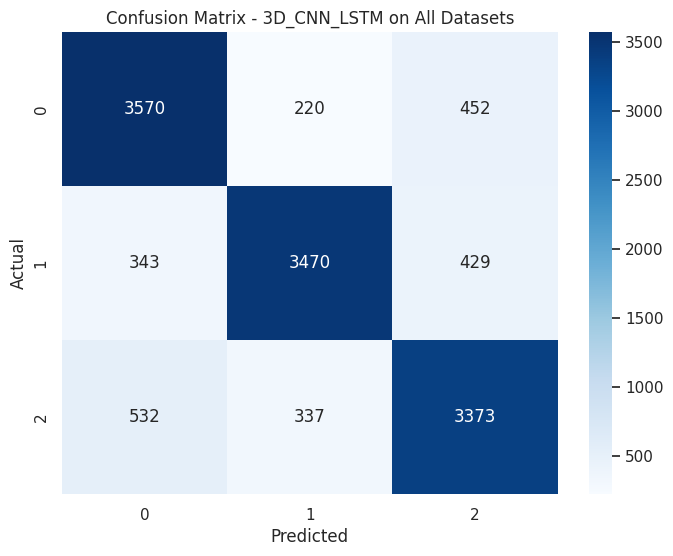

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv3D, MaxPooling3D
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 3D CNN+LSTM Modeli
def create_3d_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli Eğitme ve Test Etme
def train_and_predict(features, labels, model_name, input_shape=None):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    if model_name == "3D_CNN_LSTM":
        time_steps = 1
        n_features = X_train.shape[1]
        X_train = X_train.reshape(X_train.shape[0], time_steps, n_features // time_steps, 1, 1)
        X_test = X_test.reshape(X_test.shape[0], time_steps, n_features // time_steps, 1, 1)

        model = create_3d_cnn_lstm_model((time_steps, X_train.shape[2], 1, 1), y_train.shape[1])

    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_classes, y_pred_classes)

    return cm

# Karmaşıklık Matrisini Görselleştirme
def plot_confusion_matrix(cm, model_name, dataset_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
    plt.title(f'Confusion Matrix - {model_name} on {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def main():
    # Veri yolları
    paths = [
        "/content/drive/MyDrive/data_with_lda_train.csv",
        "/content/drive/MyDrive/data_with_lda_test.csv",
        "/content/drive/MyDrive/5_data_balanced.csv",
        "/content/drive/MyDrive/data_with_pca_normalized.csv"
    ]

    # Her model için karmaşıklık matrislerini toplamak
    confusion_matrices = {model: None for model in ["3D_CNN_LSTM"]}

    # Her veri seti ile işlem yapılacak
    for path in paths:
        data = pd.read_csv(path)

        # Etiketler ve Özellikler
        labels = data.iloc[:, -1].values
        features = data.iloc[:, :-1].values

        print(f"Veri seti: {path}")
        print(f"Etiketlerin ilk 5 değeri: {labels[:5]}")
        print(f"Özelliklerin boyutu: {features.shape}")

        # K-Fold Çapraz Doğrulama için StratifiedKFold
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold = 1
        for train_idx, test_idx in kfold.split(features, labels):
            print(f"Fold {fold} Başlıyor...")

            # Eğitim ve Test Verilerini Ayırma
            X_train, X_test = features[train_idx], features[test_idx]
            y_train, y_test = labels[train_idx], labels[test_idx]

            # Veriyi Standartlaştırma
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            y_train = to_categorical(y_train)
            y_test = to_categorical(y_test)

            # Zaman adımlarına göre şekillendirme
            time_steps = 1
            n_features = X_train.shape[1]
            X_train = X_train.reshape(X_train.shape[0], time_steps, n_features // time_steps, 1, 1)
            X_test = X_test.reshape(X_test.shape[0], time_steps, n_features // time_steps, 1, 1)

            # Modeli oluşturma
            model = create_3d_cnn_lstm_model((time_steps, X_train.shape[2], 1, 1), y_train.shape[1])

            # Modeli eğitme
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

            # Tahminler
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_test_classes = np.argmax(y_test, axis=1)

            # Karmaşıklık Matrisi
            cm = confusion_matrix(y_test_classes, y_pred_classes)

            if confusion_matrices["3D_CNN_LSTM"] is None:
                confusion_matrices["3D_CNN_LSTM"] = cm
            else:
                confusion_matrices["3D_CNN_LSTM"] += cm

            fold += 1

    # Karmaşıklık Matrislerinin Görselleştirilmesi
    for model_name, cm in confusion_matrices.items():
        print(f"{model_name} Modeli için Toplam Karmaşıklık Matrisi:")
        plot_confusion_matrix(cm, model_name, "All Datasets")

if __name__ == "__main__":
    main()


LDA Results Columns:  Index(['Fold', 'Accuracy', 'F1 Score', 'Sensitivity', 'Specificity',
       'Precision', 'AUC ROC'],
      dtype='object')
PCA Results Columns:  Index(['Fold', 'Accuracy', 'F1 Score', 'Sensitivity', 'Specificity',
       'Precision', 'AUC ROC'],
      dtype='object')
No Method Results Columns:  Index(['Fold', 'Accuracy', 'F1 Score', 'Sensitivity', 'Specificity',
       'Precision', 'AUC ROC'],
      dtype='object')


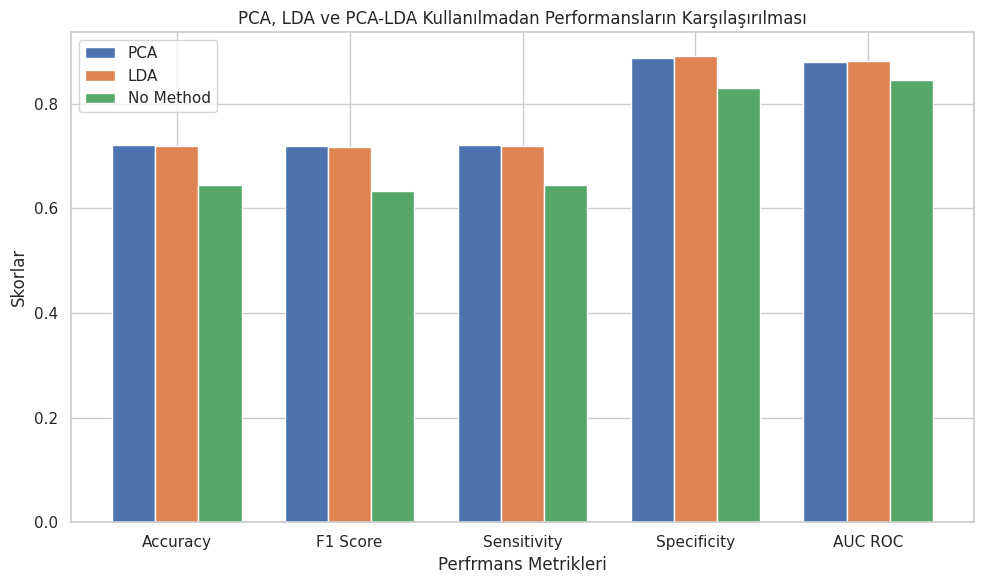

Combined Results Saved:
        Metric       PCA       LDA  No Method
0     Accuracy  0.720890  0.718533   0.644510
1     F1 Score  0.719993  0.717881   0.632545
2  Sensitivity  0.720890  0.718533   0.644510
3  Specificity  0.887048  0.891945   0.830821
4      AUC ROC  0.878897  0.880845   0.844732


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dosya yolları
lda_file = '/content/drive/MyDrive/hibrit_lda_kfold_results.csv'
no_method_file = '/content/drive/MyDrive/hibrit_no_kfold_results.csv'
pca_file = '/content/drive/MyDrive/hibrit_pca_kfold_results.csv'

# Dosyaları yükle
lda_results = pd.read_csv(lda_file)
no_method_results = pd.read_csv(no_method_file)
pca_results = pd.read_csv(pca_file)

# Verilerin sütun isimlerini kontrol et
print("LDA Results Columns: ", lda_results.columns)
print("PCA Results Columns: ", pca_results.columns)
print("No Method Results Columns: ", no_method_results.columns)

# Performans metrikleri isimlerini belirliyoruz (gerekirse doğru isimlerle güncellenmiş)
lda_metrics = ['Accuracy', 'F1 Score', 'Sensitivity', 'Specificity', 'AUC ROC']
pca_metrics = ['Accuracy', 'F1 Score', 'Sensitivity', 'Specificity', 'AUC ROC']
no_method_metrics = ['Accuracy', 'F1 Score', 'Sensitivity', 'Specificity', 'AUC ROC']

# LDA ve PCA sonuçlarını uygun şekilde alıyoruz (sütun isimleri doğruysa)
lda_means = lda_results[lda_metrics].mean().values if all(metric in lda_results.columns for metric in lda_metrics) else np.nan
pca_means = pca_results[pca_metrics].mean().values if all(metric in pca_results.columns for metric in pca_metrics) else np.nan

# No Method verisini 'Metric' ve 'Score' kolonlarına göre düzenliyoruz
# 'Metric' ve 'Score' sütunları yerine doğrudan metriklerin adlarını kullanıyoruz
no_method_means = []
for metric in lda_metrics:  # 'AUC ROC' hariç
    if metric in no_method_results.columns:
        no_method_means.append(no_method_results[metric].mean())
    else:
        no_method_means.append(np.nan)

# Bar grafiği için düzenleme
x = np.arange(len(lda_metrics))  # Metriklerin konumu
width = 0.25  # Barların genişliği

# Grafik oluşturma
fig, ax = plt.subplots(figsize=(10, 6))

# Barlar
ax.bar(x - width, pca_means, width, label='PCA')
ax.bar(x, lda_means, width, label='LDA')
ax.bar(x + width, no_method_means, width, label='No Method')

# Grafiği özelleştirme
ax.set_xlabel('Perfrmans Metrikleri')
ax.set_ylabel('Skorlar')
ax.set_title('PCA, LDA ve PCA-LDA Kullanılmadan Performansların Karşılaşırılması')
ax.set_xticks(x)
ax.set_xticklabels(lda_metrics)
ax.legend()

# Grafiği gösterme
plt.tight_layout()
plt.show()

# Ortalama değerleri hesapla
lda_avg = lda_results[lda_metrics].mean()
pca_avg = pca_results[pca_metrics].mean()
no_method_avg = no_method_results[no_method_metrics].mean()

# Sonuçları birleştir
results_df = pd.DataFrame({
    'Metric': lda_metrics,
    'PCA': pca_avg.values,
    'LDA': lda_avg.values,
    'No Method': no_method_avg.values
})

# Sonuçları yeni bir CSV dosyasına kaydet
results_df.to_csv('/content/drive/MyDrive/hibrit_combined_performance_results.csv', index=False)

# Sonuçları göster
print("Combined Results Saved:")
print(results_df)


# EĞİTİM VE TEST VERİLERİNİN PERFORMANS DEĞERLENDİRMESİ

Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
PCA Ortalama Doğruluk: 0.7338
Özellik Sayısı: 2, Time_steps: 2
Özellik Sayısı: 2, Time_steps: 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Özellik Sayısı: 2, Time_steps: 2
Özellik Sayısı: 2, Time_steps: 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Özellik Sayısı: 2, Time_steps: 2
Özellik Sayısı: 2, Time_steps: 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Özellik Sayısı: 2, Time_steps: 2
Özellik Sayısı: 2, Time_steps: 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Özellik Sayısı: 2, Time_steps: 2
Özellik Sayısı: 2, Time_steps: 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
LDA Ortalama Doğruluk: 0.7613
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
No Transformation Ortalama Doğruluk: 0.6502


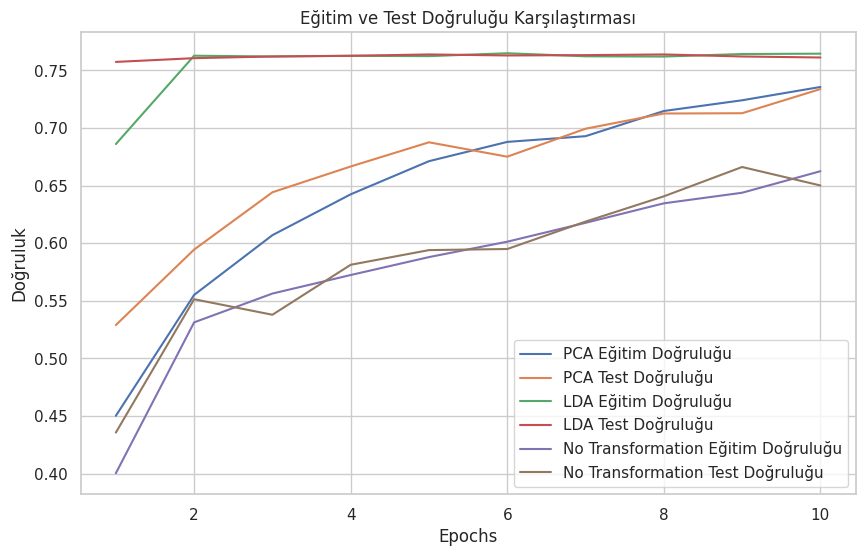

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape

# Veri Yükleme
data_pca = pd.read_csv("/content/drive/MyDrive/data_with_pca_normalized.csv")
data_lda_train = pd.read_csv("/content/drive/MyDrive/data_with_lda_train.csv")
data_lda_test = pd.read_csv("/content/drive/MyDrive/data_with_lda_test.csv")
data_no_transform = pd.read_csv("/content/drive/MyDrive/5_data_balanced.csv")

# Veriyi 3D CNN için Yeniden Şekillendirme
def reshape_for_3d_cnn(X, time_steps=10):
    num_features = X.shape[1]
    print(f"Özellik Sayısı: {num_features}, Time_steps: {time_steps}")

    # time_steps değerini, özellik sayısına göre ayarlama
    if num_features < time_steps:
        time_steps = num_features  # Eğer özellik sayısı time_steps'ten küçükse, time_steps'i özellik sayısına eşitle
        print(f"Özellik sayısı zaman adımı sayısından küçük. time_steps değeri {time_steps} olarak ayarlandı.")

    if num_features % time_steps != 0:
        new_features = (num_features // time_steps) * time_steps
        print(f"Fazlalık özellikler atılacak. Yeni özellik sayısı: {new_features}")
        X = X[:, :new_features]

    features_per_step = X.shape[1] // time_steps

    return X.reshape(-1, time_steps, features_per_step, 1, 1)

# Hibrit Model Tanımlama (3D CNN + LSTM)
def create_hybrid_model(time_steps, features_per_step):
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 1), activation='relu', padding='same',
               input_shape=(time_steps, features_per_step, 1, 1)),
        MaxPooling3D(pool_size=(2, 2, 1), padding='same'),
        Flatten(),
        Reshape((time_steps, -1)),
        TimeDistributed(Dense(64, activation='relu')),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Çapraz Doğrulama
def cross_validation(X, y, time_steps, model_name):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_histories = []
    accuracy_scores = []

    for train_idx, test_idx in kfold.split(X, y):
        # Eğitim ve Test Verilerini Ayırma
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Veriyi Yeniden Şekillendirme
        X_train = reshape_for_3d_cnn(X_train, time_steps)
        X_test = reshape_for_3d_cnn(X_test, time_steps)

        # Modeli Oluşturma
        model = create_hybrid_model(time_steps, X_train.shape[2])

        # Modeli Eğitme
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        # Geçmişi Saklama
        all_histories.append(history.history)

        # Test Seti ile Doğruluk Hesaplama
        y_pred = np.argmax(model.predict(X_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    # Ortalama Doğruluk
    avg_accuracy = np.mean(accuracy_scores)
    print(f'{model_name} Ortalama Doğruluk: {avg_accuracy:.4f}')

    return avg_accuracy, all_histories

# Doğrulukların Tablosunu ve Grafiğini Çizme
def plot_accuracy_graph(title, accuracies, histories):
    # Her model için doğrulukları çizme
    plt.figure(figsize=(10, 6))
    for model_name, (accuracy, history) in accuracies.items():
        # Epoch başına eğitim ve test doğruluğu
        epochs = range(1, len(history[0]['accuracy']) + 1)
        avg_train_accuracy = np.mean([h['accuracy'] for h in history], axis=0)
        avg_val_accuracy = np.mean([h['val_accuracy'] for h in history], axis=0)

        # Grafik
        plt.plot(epochs, avg_train_accuracy, label=f'{model_name} Eğitim Doğruluğu')
        plt.plot(epochs, avg_val_accuracy, label=f'{model_name} Test Doğruluğu')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid(True)
    plt.show()

# Veriyi Yükleme
X_pca = data_pca.iloc[:, :-1].values
y_pca = data_pca.iloc[:, -1].values
X_lda_train = data_lda_train.iloc[:, :-1].values
y_lda_train = data_lda_train.iloc[:, -1].values
X_lda_test = data_lda_test.iloc[:, :-1].values
y_lda_test = data_lda_test.iloc[:, -1].values
X_no_transform = data_no_transform.iloc[:, :-1].values
y_no_transform = data_no_transform.iloc[:, -1].values

# Zaman adımını özellik sayısına göre uyarlama
time_steps_pca = min(X_pca.shape[1], 10)
time_steps_lda = min(X_lda_train.shape[1], 10)
time_steps_no_transform = min(X_no_transform.shape[1], 10)

# PCA ile eğitim ve doğruluk
accuracy_pca, history_pca = cross_validation(X_pca, y_pca, time_steps_pca, "PCA")

# LDA ile eğitim ve doğruluk
accuracy_lda, history_lda = cross_validation(X_lda_train, y_lda_train, time_steps_lda, "LDA")

# LDA ve PCA uygulanmamış verilerle eğitim ve doğruluk
accuracy_no_transform, history_no_transform = cross_validation(X_no_transform, y_no_transform, time_steps_no_transform, "No Transformation")

# Sonuçları Grafikle Gösterme
accuracies = {
    'PCA': (accuracy_pca, history_pca),
    'LDA': (accuracy_lda, history_lda),
    'No Transformation': (accuracy_no_transform, history_no_transform)
}

plot_accuracy_graph('Eğitim ve Test Doğruluğu Karşılaştırması', accuracies, {
    'PCA': history_pca,
    'LDA': history_lda,
    'No Transformation': history_no_transform
})


Fold 1 Başlıyor...
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10
Özellik Sayısı: 12, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 10
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4014 - loss: 1.0652 - val_accuracy: 0.5559 - val_loss: 0.9541
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5689 - loss: 0.9215 - val_accuracy: 0.5383 - val_loss: 0.9336
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6344 - loss: 0.8342 - val_accuracy: 0.6207 - val_loss: 0.8087
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6429 - loss: 0.8193 - val_accuracy: 0.6455 - val_loss: 0.7920
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6272 - loss: 0.8471 - val_accuracy: 0.6867 - val_loss: 0.7570
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6854 - loss: 0.7392 - val_accuracy: 0.6985 - val_loss: 0.7295
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6935 - loss: 0.7137 - val_accuracy: 0.6855 - val_loss: 0.7033
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7121 - loss: 0.6704 - val_accuracy: 0.717

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4057 - loss: 1.0571 - val_accuracy: 0.5665 - val_loss: 0.9198
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5376 - loss: 0.9456 - val_accuracy: 0.5736 - val_loss: 0.8549
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5954 - loss: 0.8768 - val_accuracy: 0.6349 - val_loss: 0.7816
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6453 - loss: 0.8035 - val_accuracy: 0.6219 - val_loss: 0.8048
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6294 - loss: 0.8061 - val_accuracy: 0.6678 - val_loss: 0.7267
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6718 - loss: 0.7445 - val_accuracy: 0.6902 - val_loss: 0.6934
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6926 - loss: 0.7111 - val_accuracy: 0.7091 - val_loss: 0.6628
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7086 - loss: 0.7002 - val_accuracy: 0.706

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3937 - loss: 1.0730 - val_accuracy: 0.5283 - val_loss: 0.9617
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5400 - loss: 0.9417 - val_accuracy: 0.5991 - val_loss: 0.8828
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5941 - loss: 0.8827 - val_accuracy: 0.6368 - val_loss: 0.8215
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6445 - loss: 0.8199 - val_accuracy: 0.6710 - val_loss: 0.7379
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6760 - loss: 0.7474 - val_accuracy: 0.6946 - val_loss: 0.6931
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6951 - loss: 0.7106 - val_accuracy: 0.7170 - val_loss: 0.6588
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7187 - loss: 0.6708 - val_accuracy: 0.6887 - val_loss: 0.7068
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7291 - loss: 0.6637 - val_accuracy: 0.702

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4137 - loss: 1.0629 - val_accuracy: 0.4976 - val_loss: 0.9563
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5480 - loss: 0.9328 - val_accuracy: 0.6108 - val_loss: 0.8831
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5855 - loss: 0.8769 - val_accuracy: 0.6144 - val_loss: 0.8251
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6400 - loss: 0.8099 - val_accuracy: 0.6474 - val_loss: 0.7841
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6683 - loss: 0.7464 - val_accuracy: 0.6616 - val_loss: 0.7508
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6910 - loss: 0.7278 - val_accuracy: 0.6840 - val_loss: 0.7695
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6965 - loss: 0.7219 - val_accuracy: 0.7052 - val_loss: 0.6997
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7119 - loss: 0.6794 - val_accuracy: 0.702

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3677 - loss: 1.0800 - val_accuracy: 0.5047 - val_loss: 0.9775
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5241 - loss: 0.9711 - val_accuracy: 0.6167 - val_loss: 0.8592
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5986 - loss: 0.8768 - val_accuracy: 0.6533 - val_loss: 0.8018
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6337 - loss: 0.8213 - val_accuracy: 0.6863 - val_loss: 0.7407
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6670 - loss: 0.7653 - val_accuracy: 0.6710 - val_loss: 0.7461
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6949 - loss: 0.7398 - val_accuracy: 0.7087 - val_loss: 0.6882
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7133 - loss: 0.6912 - val_accuracy: 0.7170 - val_loss: 0.6937
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7184 - loss: 0.6977 - val_accuracy: 0.722

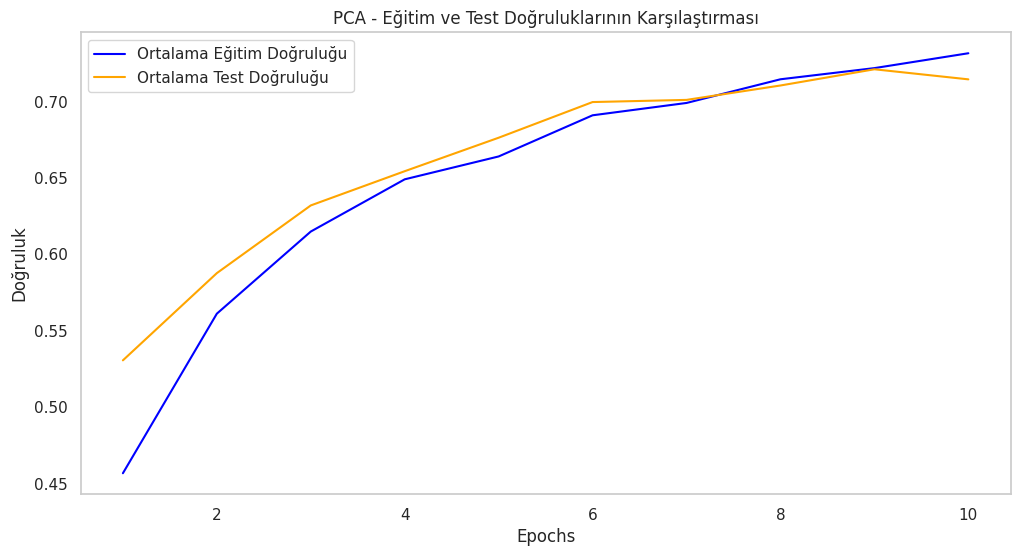

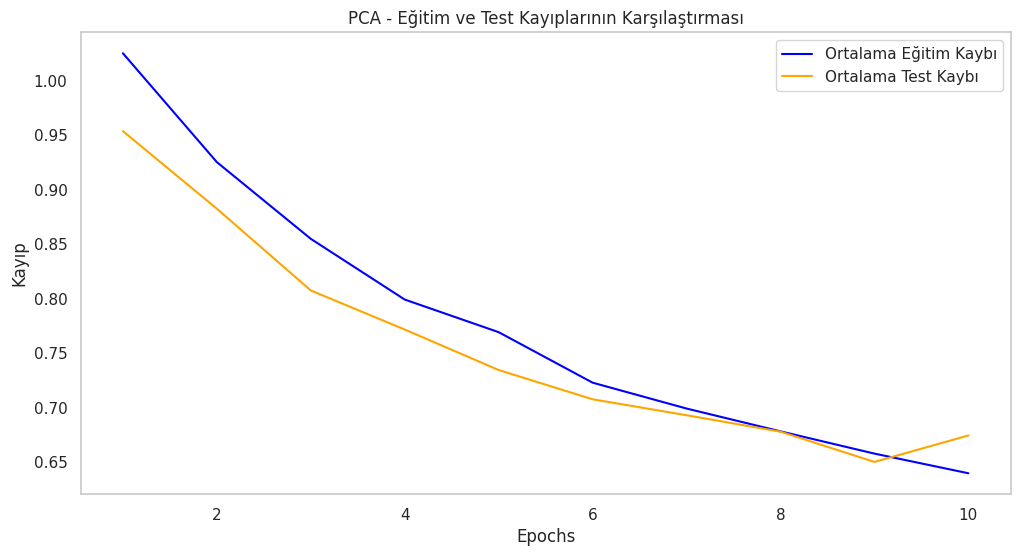

PCA Ortalama Doğruluk: 0.7145
Fold 1 Başlıyor...
Özellik Sayısı: 2, Time_steps: 2
Özellik Sayısı: 2, Time_steps: 2
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6054 - loss: 1.0028 - val_accuracy: 0.7570 - val_loss: 0.6286
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7568 - loss: 0.6279 - val_accuracy: 0.7467 - val_loss: 0.6049
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7657 - loss: 0.6116 - val_accuracy: 0.7541 - val_loss: 0.6013
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7636 - loss: 0.6087 - val_accuracy: 0.7541 - val_loss: 0.6035
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7655 - loss: 0.5836 - val_accuracy: 0.7393 - val_loss: 0.5963
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7707 - loss: 0.5967 - val_accuracy: 0.7511 - val_loss: 0.5971
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7618 - loss: 0.5952 - val_accuracy: 0.7467 - val_loss: 0.6058
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7588 - loss: 0.6011 - val_accuracy: 0.7393 - val_loss: 0.5955


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6222 - loss: 0.9981 - val_accuracy: 0.7732 - val_loss: 0.5836
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7658 - loss: 0.6120 - val_accuracy: 0.7732 - val_loss: 0.5704
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7607 - loss: 0.6165 - val_accuracy: 0.7747 - val_loss: 0.5715
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7512 - loss: 0.6292 - val_accuracy: 0.7717 - val_loss: 0.5642
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7634 - loss: 0.5902 - val_accuracy: 0.7732 - val_loss: 0.5684
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7506 - loss: 0.6202 - val_accuracy: 0.7791 - val_loss: 0.5680
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7507 - loss: 0.6414 - val_accuracy: 0.7717 - val_loss: 0.5659
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7460 - loss: 0.6141 - val_accuracy: 0.7747 - val_loss: 0.5672

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5450 - loss: 0.9806 - val_accuracy: 0.7732 - val_loss: 0.5941
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7596 - loss: 0.6170 - val_accuracy: 0.7761 - val_loss: 0.5895
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7563 - loss: 0.6267 - val_accuracy: 0.7806 - val_loss: 0.5802
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7495 - loss: 0.6197 - val_accuracy: 0.7806 - val_loss: 0.5849
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7682 - loss: 0.5858 - val_accuracy: 0.7747 - val_loss: 0.5881
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7569 - loss: 0.6152 - val_accuracy: 0.7703 - val_loss: 0.5979
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7706 - loss: 0.5975 - val_accuracy: 0.7776 - val_loss: 0.5785
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7540 - loss: 0.6278 - val_accuracy: 0.7791 - val_loss: 0.5834

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5949 - loss: 1.0051 - val_accuracy: 0.7743 - val_loss: 0.5491
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7616 - loss: 0.6341 - val_accuracy: 0.7920 - val_loss: 0.5389
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7693 - loss: 0.6107 - val_accuracy: 0.7891 - val_loss: 0.5454
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7578 - loss: 0.6111 - val_accuracy: 0.7906 - val_loss: 0.5429
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7493 - loss: 0.6193 - val_accuracy: 0.7817 - val_loss: 0.5456
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7495 - loss: 0.6095 - val_accuracy: 0.7876 - val_loss: 0.5495
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7601 - loss: 0.6126 - val_accuracy: 0.7847 - val_loss: 0.5461
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7590 - loss: 0.6124 - val_accuracy: 0.7891 - val_loss: 0.5434


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6226 - loss: 0.9901 - val_accuracy: 0.7330 - val_loss: 0.7003
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7711 - loss: 0.6031 - val_accuracy: 0.7286 - val_loss: 0.7010
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7672 - loss: 0.5985 - val_accuracy: 0.7198 - val_loss: 0.6854
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7591 - loss: 0.5977 - val_accuracy: 0.7301 - val_loss: 0.7039
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7855 - loss: 0.5740 - val_accuracy: 0.7212 - val_loss: 0.6824
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7747 - loss: 0.5666 - val_accuracy: 0.7212 - val_loss: 0.6956
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7748 - loss: 0.5742 - val_accuracy: 0.7257 - val_loss: 0.6881
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7696 - loss: 0.5804 - val_accuracy: 0.7257 - val_loss: 0.6801
Ep

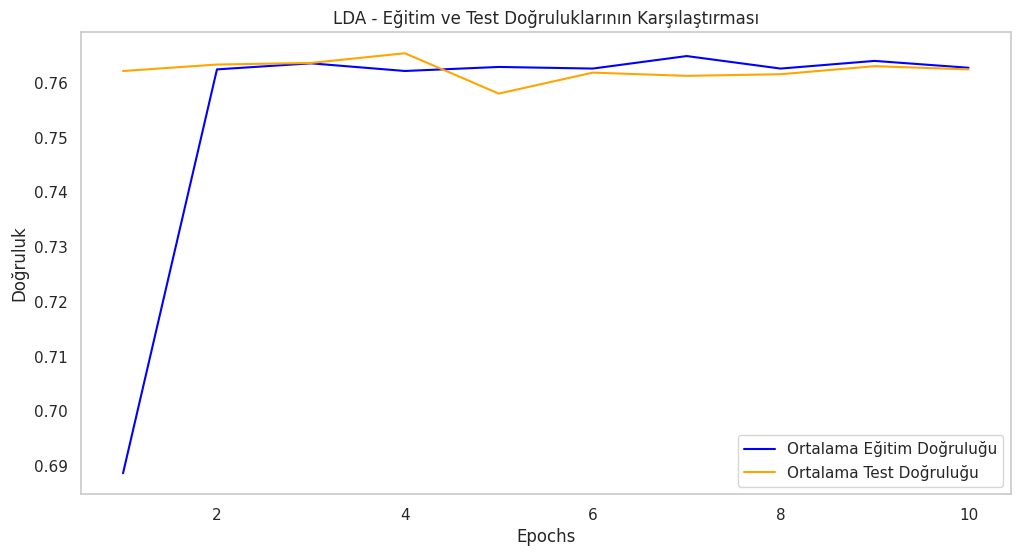

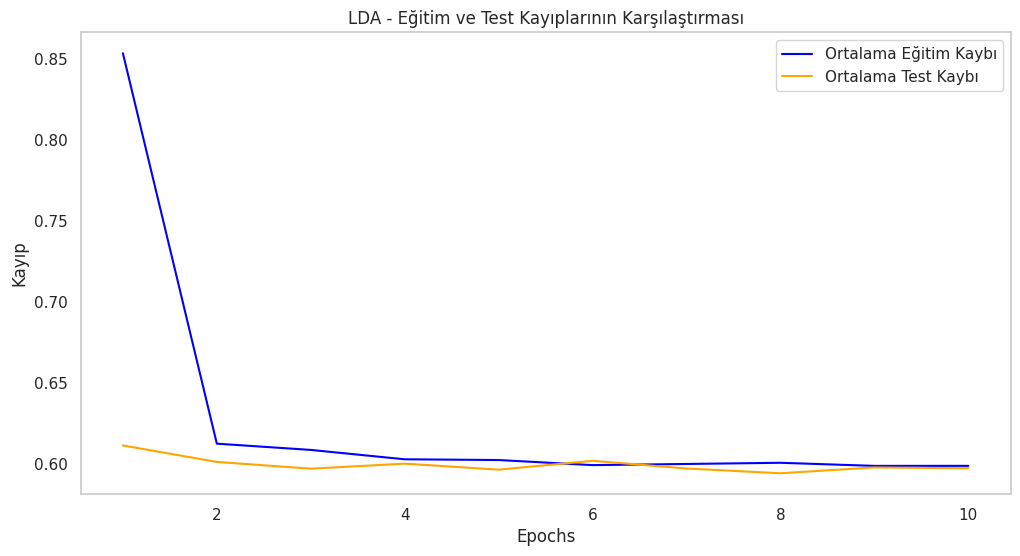

LDA Ortalama Doğruluk: 0.7624
Fold 1 Başlıyor...
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90
Özellik Sayısı: 99, Time_steps: 10
Fazlalık özellikler atılacak. Yeni özellik sayısı: 90
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.3587 - loss: 1.0927 - val_accuracy: 0.4653 - val_loss: 1.0501
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5011 - loss: 0.9935 - val_accuracy: 0.5536 - val_loss: 0.9252
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5528 - loss: 0.9111 - val_accuracy: 0.5371 - val_loss: 0.9166
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5678 - loss: 0.8977 - val_accuracy: 0.5477 - val_loss: 0.9005
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5833 - loss: 0.8771 - val_accuracy: 0.5807 - val_loss: 0.8852
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5755 - loss: 0.8734 - val_accuracy: 0.6007 - val_loss: 0.8544
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5943 - loss: 0.8462 - val_accuracy: 0.6278 - val_loss: 0.8294
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6198 - loss: 0.8162 - val_accuracy: 0.534

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3615 - loss: 1.0911 - val_accuracy: 0.5300 - val_loss: 0.9761
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5154 - loss: 0.9680 - val_accuracy: 0.5371 - val_loss: 0.8963
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5216 - loss: 0.9364 - val_accuracy: 0.5736 - val_loss: 0.8664
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5577 - loss: 0.8895 - val_accuracy: 0.6042 - val_loss: 0.8448
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5683 - loss: 0.8727 - val_accuracy: 0.5524 - val_loss: 0.8853
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5804 - loss: 0.8682 - val_accuracy: 0.6372 - val_loss: 0.7986
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6153 - loss: 0.8298 - val_accuracy: 0.5465 - val_loss: 0.9185
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6020 - loss: 0.8442 - val_accuracy: 0.654

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.3829 - loss: 1.0897 - val_accuracy: 0.4410 - val_loss: 1.0357
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5091 - loss: 0.9880 - val_accuracy: 0.5625 - val_loss: 0.9055
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5581 - loss: 0.9146 - val_accuracy: 0.5896 - val_loss: 0.8745
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5742 - loss: 0.8986 - val_accuracy: 0.6002 - val_loss: 0.8519
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5729 - loss: 0.8836 - val_accuracy: 0.6274 - val_loss: 0.8271
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6035 - loss: 0.8376 - val_accuracy: 0.6663 - val_loss: 0.7897
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6528 - loss: 0.7830 - val_accuracy: 0.6922 - val_loss: 0.7518
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6480 - loss: 0.7832 - val_accuracy: 0.682

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.3753 - loss: 1.0859 - val_accuracy: 0.4976 - val_loss: 0.9746
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5175 - loss: 0.9614 - val_accuracy: 0.5507 - val_loss: 0.9114
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5639 - loss: 0.9007 - val_accuracy: 0.5507 - val_loss: 0.9091
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5852 - loss: 0.8774 - val_accuracy: 0.5566 - val_loss: 0.9005
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6025 - loss: 0.8636 - val_accuracy: 0.5696 - val_loss: 0.8805
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6038 - loss: 0.8393 - val_accuracy: 0.5708 - val_loss: 0.8754
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6143 - loss: 0.8298 - val_accuracy: 0.5908 - val_loss: 0.8396
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6253 - loss: 0.8097 - val_accuracy: 0.613

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3639 - loss: 1.0946 - val_accuracy: 0.4882 - val_loss: 1.0073
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4829 - loss: 1.0023 - val_accuracy: 0.5767 - val_loss: 0.8729
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5516 - loss: 0.9124 - val_accuracy: 0.5920 - val_loss: 0.8934
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5633 - loss: 0.9092 - val_accuracy: 0.5884 - val_loss: 0.8359
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5685 - loss: 0.8787 - val_accuracy: 0.5778 - val_loss: 0.8417
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6062 - loss: 0.8557 - val_accuracy: 0.6309 - val_loss: 0.8006
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5981 - loss: 0.8648 - val_accuracy: 0.6321 - val_loss: 0.7872
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6268 - loss: 0.8268 - val_accuracy: 0.652

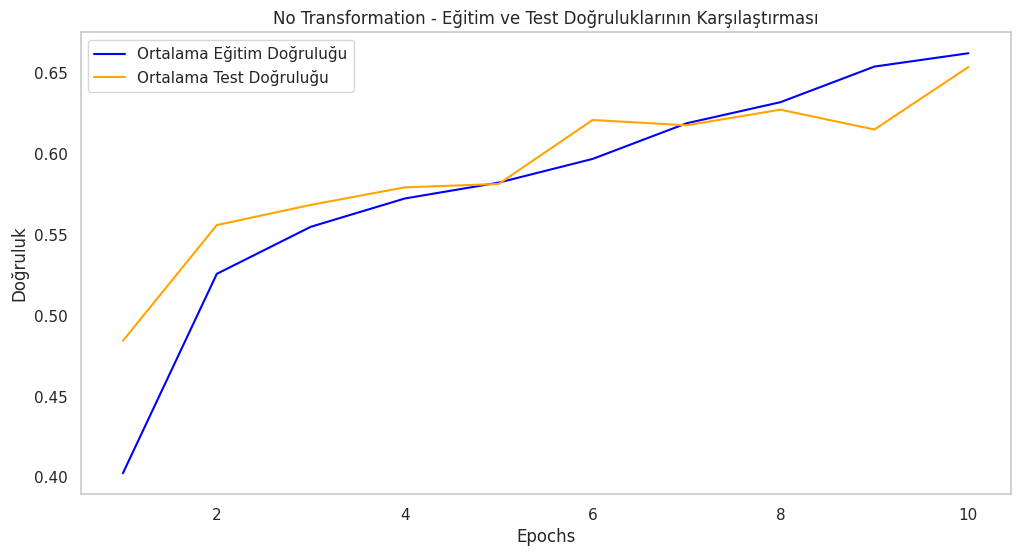

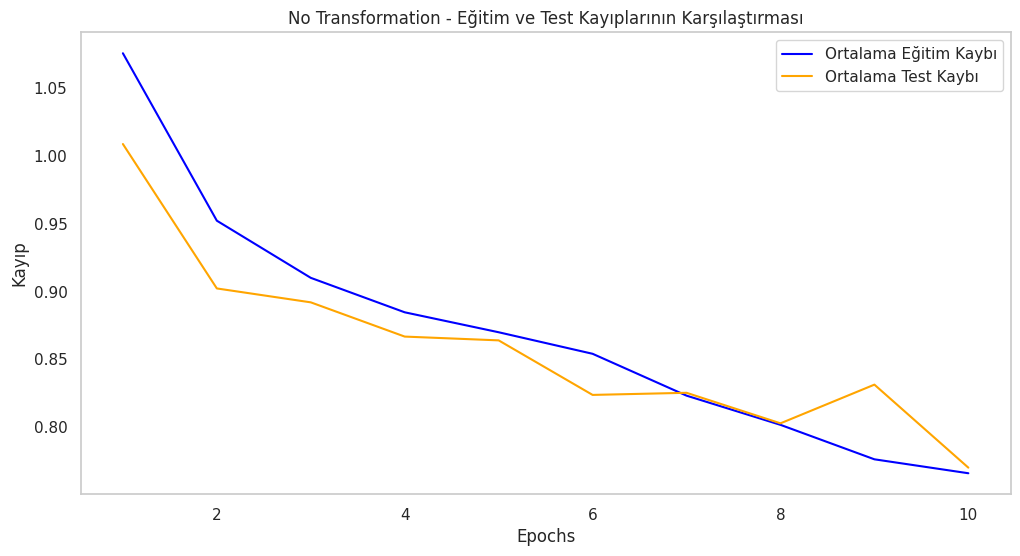

No Transformation Ortalama Doğruluk: 0.6539
Doğruluklar Tablosu:
   PCA Accuracy  LDA Accuracy  No Transformation Accuracy  PCA Train Accuracy  \
0      0.676090      0.752577                    0.658422            0.653640   
1      0.719670      0.774669                    0.666667            0.646478   
2      0.721698      0.777614                    0.604953            0.652770   
3      0.716981      0.789086                    0.645047            0.651591   
4      0.738208      0.718289                    0.694575            0.647613   

   PCA Val Accuracy  LDA Train Accuracy  LDA Val Accuracy  \
0          0.654417            0.758917          0.749190   
1          0.661249            0.754016          0.774521   
2          0.668042            0.749447          0.776436   
3          0.654953            0.750681          0.786136   
4          0.675354            0.765230          0.725074   

   No Transform Train Accuracy  No Transform Val Accuracy  
0                    

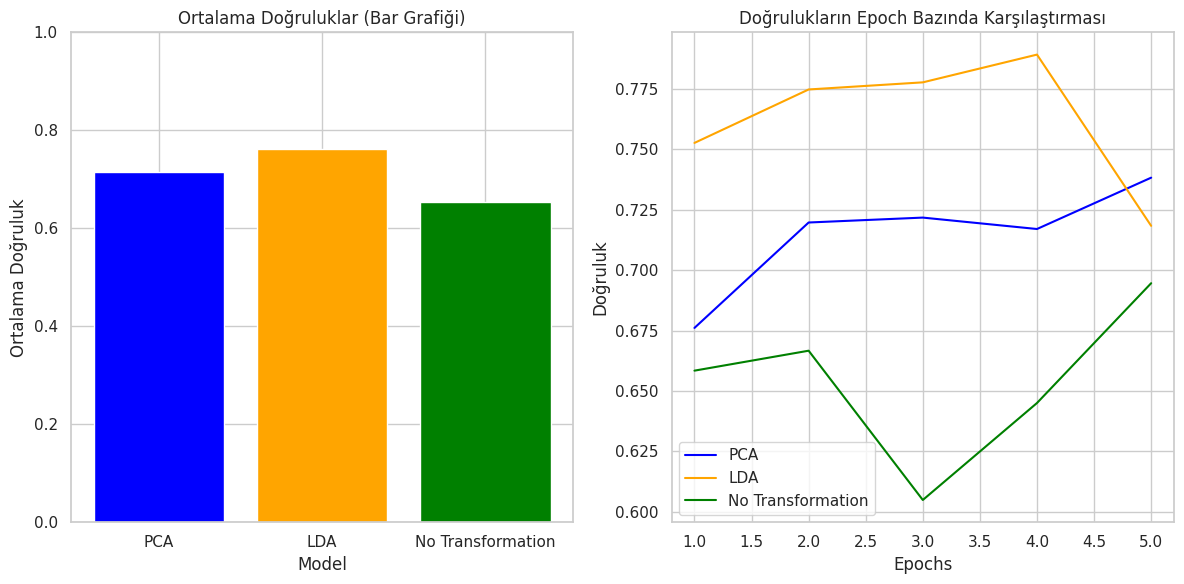

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape
from sklearn.metrics import accuracy_score

# Veri Yükleme
data_pca = pd.read_csv("/content/drive/MyDrive/data_with_pca_normalized.csv")
data_lda_train = pd.read_csv("/content/drive/MyDrive/data_with_lda_train.csv")
data_lda_test = pd.read_csv("/content/drive/MyDrive/data_with_lda_test.csv")
data_no_transform = pd.read_csv("/content/drive/MyDrive/5_data_balanced.csv")

# Veriyi 3D CNN için Yeniden Şekillendirme
def reshape_for_3d_cnn(X, time_steps=10):
    num_features = X.shape[1]
    print(f"Özellik Sayısı: {num_features}, Time_steps: {time_steps}")

    # time_steps değerini, özellik sayısına göre ayarlama
    if num_features < time_steps:
        time_steps = num_features  # Eğer özellik sayısı time_steps'ten küçükse, time_steps'i özellik sayısına eşitle
        print(f"Özellik sayısı zaman adımı sayısından küçük. time_steps değeri {time_steps} olarak ayarlandı.")

    if num_features % time_steps != 0:
        new_features = (num_features // time_steps) * time_steps
        print(f"Fazlalık özellikler atılacak. Yeni özellik sayısı: {new_features}")
        X = X[:, :new_features]

    features_per_step = X.shape[1] // time_steps

    return X.reshape(-1, time_steps, features_per_step, 1, 1)

# Hibrit Model Tanımlama (3D CNN + LSTM)
def create_hybrid_model(time_steps, features_per_step):
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 1), activation='relu', padding='same',
               input_shape=(time_steps, features_per_step, 1, 1)),
        MaxPooling3D(pool_size=(2, 2, 1), padding='same'),  # Padding'i 'same' olarak ayarladık
        Flatten(),
        Reshape((time_steps, -1)),
        TimeDistributed(Dense(64, activation='relu')),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Eğitim ve Test Doğruluklarının Toplanması
def plot_combined_history(all_histories, title):
    epochs = range(1, len(all_histories[0]['accuracy']) + 1)
    avg_train_accuracy = np.mean([history['accuracy'] for history in all_histories], axis=0)
    avg_val_accuracy = np.mean([history['val_accuracy'] for history in all_histories], axis=0)
    avg_train_loss = np.mean([history['loss'] for history in all_histories], axis=0)
    avg_val_loss = np.mean([history['val_loss'] for history in all_histories], axis=0)

    # Doğruluk Grafiği
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, avg_train_accuracy, label='Ortalama Eğitim Doğruluğu', color='blue')
    plt.plot(epochs, avg_val_accuracy, label='Ortalama Test Doğruluğu', color='orange')
    plt.title(f'{title} - Eğitim ve Test Doğruluklarının Karşılaştırması')
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid()
    plt.show()

    # Kayıp Grafiği
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, avg_train_loss, label='Ortalama Eğitim Kaybı', color='blue')
    plt.plot(epochs, avg_val_loss, label='Ortalama Test Kaybı', color='orange')
    plt.title(f'{title} - Eğitim ve Test Kayıplarının Karşılaştırması')
    plt.xlabel('Epochs')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid()
    plt.show()

# K-Fold Çapraz Doğrulama
def cross_validation(X, y, time_steps, model_name):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_histories = []
    fold = 1
    accuracy_scores = []
    train_accuracies = []
    val_accuracies = []

    for train_idx, test_idx in kfold.split(X, y):
        print(f"Fold {fold} Başlıyor...")

        # Eğitim ve Test Verilerini Ayırma
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Veriyi Yeniden Şekillendirme
        X_train = reshape_for_3d_cnn(X_train, time_steps)
        X_test = reshape_for_3d_cnn(X_test, time_steps)

        # Modeli Oluşturma
        model = create_hybrid_model(time_steps, X_train.shape[2])

        # Modeli Eğitme
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

        # Geçmişi Saklama
        all_histories.append(history.history)

        # Eğitim ve Test doğruluklarını kaydetme
        train_accuracies.append(np.mean(history.history['accuracy']))
        val_accuracies.append(np.mean(history.history['val_accuracy']))

        # Test Seti ile Doğruluk Hesaplama
        y_pred = np.argmax(model.predict(X_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        fold += 1

    # Eğitim ve Test Doğruluklarının Karşılaştırılması
    plot_combined_history(all_histories, model_name)

    # Ortalama Doğruluk
    print(f'{model_name} Ortalama Doğruluk: {np.mean(accuracy_scores):.4f}')
    return accuracy_scores, train_accuracies, val_accuracies

# Veriyi Yükleme
X_pca = data_pca.iloc[:, :-1].values
y_pca = data_pca.iloc[:, -1].values
X_lda_train = data_lda_train.iloc[:, :-1].values
y_lda_train = data_lda_train.iloc[:, -1].values
X_lda_test = data_lda_test.iloc[:, :-1].values
y_lda_test = data_lda_test.iloc[:, -1].values
X_no_transform = data_no_transform.iloc[:, :-1].values
y_no_transform = data_no_transform.iloc[:, -1].values

# Zaman adımını özellik sayısına göre uyarlama (özellik sayısına bakarak en uygun time_steps değerini ayarlayacağız)
time_steps_pca = min(X_pca.shape[1], 10)
time_steps_lda = min(X_lda_train.shape[1], 10)
time_steps_no_transform = min(X_no_transform.shape[1], 10)

# PCA ile eğitim ve doğruluk
accuracy_pca, train_acc_pca, val_acc_pca = cross_validation(X_pca, y_pca, time_steps_pca, "PCA")

# LDA ile eğitim ve doğruluk
accuracy_lda, train_acc_lda, val_acc_lda = cross_validation(X_lda_train, y_lda_train, time_steps_lda, "LDA")

# LDA ve PCA uygulanmamış verilerle eğitim ve doğruluk
accuracy_no_transform, train_acc_no_transform, val_acc_no_transform = cross_validation(X_no_transform, y_no_transform, time_steps_no_transform, "No Transformation")

# Doğrulukların Tablosu
results_table = pd.DataFrame({
    'PCA Accuracy': accuracy_pca,
    'LDA Accuracy': accuracy_lda,
    'No Transformation Accuracy': accuracy_no_transform,
    'PCA Train Accuracy': train_acc_pca,
    'PCA Val Accuracy': val_acc_pca,
    'LDA Train Accuracy': train_acc_lda,
    'LDA Val Accuracy': val_acc_lda,
    'No Transform Train Accuracy': train_acc_no_transform,
    'No Transform Val Accuracy': val_acc_no_transform
})

print("Doğruluklar Tablosu:")
print(results_table)

# Bar Grafik - Doğrulukları Görselleştirme
model_names = ['PCA', 'LDA', 'No Transformation']
mean_accuracy = [np.mean(accuracy_pca), np.mean(accuracy_lda), np.mean(accuracy_no_transform)]

# Çizgi grafiği ve bar grafiği aynı anda oluşturma
plt.figure(figsize=(12, 6))

# Bar grafiği
plt.subplot(1, 2, 1)  # (satır, sütun, aktif grafik)
plt.bar(model_names, mean_accuracy, color=['blue', 'orange', 'green'])
plt.title('Ortalama Doğruluklar (Bar Grafiği)')
plt.xlabel('Model')
plt.ylabel('Ortalama Doğruluk')
plt.ylim(0, 1)
plt.grid(True)

# Çizgi grafiği
plt.subplot(1, 2, 2)
epochs = range(1, len(accuracy_pca) + 1)
plt.plot(epochs, accuracy_pca, label='PCA', color='blue')
plt.plot(epochs, accuracy_lda, label='LDA', color='orange')
plt.plot(epochs, accuracy_no_transform, label='No Transformation', color='green')
plt.title('Doğrulukların Epoch Bazında Karşılaştırması')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Grafikleri gösterme
plt.tight_layout()
plt.show()


# ZAMAN VE KAYNAK KULLANIMI DEĞERLENDİRMESİ

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

# Veri dosyaları
pca_path = "/content/drive/MyDrive/data_with_pca_normalized.csv"
lda_train_path = "/content/drive/MyDrive/data_with_lda_train.csv"
lda_test_path = "/content/drive/MyDrive/data_with_lda_test.csv"
ham_data_path = "/content/drive/MyDrive/5_data_balanced.csv"

# 1. PCA uygulanmış veriyi yükleme
data_pca = pd.read_csv(pca_path)
X_pca = data_pca.drop(columns=['label'])
y_pca = data_pca['label'].astype(int)

# 2. LDA uygulanmış veriyi yükleme
lda_train = pd.read_csv(lda_train_path)
lda_test = pd.read_csv(lda_test_path)
X_lda = pd.concat([lda_train.drop(columns=['label']), lda_test.drop(columns=['label'])])
y_lda = pd.concat([lda_train['label'], lda_test['label']]).astype(int)

# 3. PCA ve LDA uygulanmamış veriyi yükleme
ham_data = pd.read_csv(ham_data_path)
X_ham = ham_data.drop(columns=['label'])
y_ham = ham_data['label'].astype(int)

# Modeller
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Performans metrikleri hesaplama fonksiyonu (Eğitim ve test sürelerini ölçme)
def evaluate_model(X, y, model_name):
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        fold_train_times = []
        fold_test_times = []

        for train_index, val_index in cv.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Özellik standardizasyonu
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            # Eğitim süresi
            start_train_time = time.time()
            model.fit(X_train, y_train)
            end_train_time = time.time()

            # Test süresi
            start_test_time = time.time()
            model.predict(X_val)
            end_test_time = time.time()

            # Eğitim ve test sürelerini kaydetme
            fold_train_times.append(end_train_time - start_train_time)
            fold_test_times.append(end_test_time - start_test_time)

        # Ortalama eğitim ve test sürelerini hesapla
        results.append({
            'Model': name,
            'Average Train Time (s)': np.mean(fold_train_times),
            'Average Test Time (s)': np.mean(fold_test_times),
            'Dataset': model_name
        })

    return results

# Tüm veri setleri için eğitim ve test sürelerini alma
train_test_times_pca = evaluate_model(X_pca, y_pca, "PCA")
train_test_times_lda = evaluate_model(X_lda, y_lda, "LDA")
train_test_times_ham = evaluate_model(X_ham, y_ham, "Ham")

# Sonuçları birleştirme
all_train_test_times = pd.DataFrame(train_test_times_pca + train_test_times_lda + train_test_times_ham)

# Sonuçları CSV olarak kaydetme
all_train_test_times.to_csv('/content/drive/MyDrive/ml_train_test_times.csv', index=False)

# Eğitim ve test sürelerini yazdırma
print(all_train_test_times)


            Model  Average Train Time (s)  Average Test Time (s) Dataset
0             SVM                2.013299               0.098014     PCA
1   Decision Tree                0.068431               0.000553     PCA
2   Random Forest                1.649854               0.024997     PCA
3             GBM                6.923166               0.007322     PCA
4             KNN                0.005232               0.093806     PCA
5             SVM                1.588899               0.091060     LDA
6   Decision Tree                0.019492               0.000773     LDA
7   Random Forest                0.675586               0.020527     LDA
8             GBM                1.544999               0.005842     LDA
9             KNN                0.003038               0.058302     LDA
10            SVM                3.768015               0.194390     Ham
11  Decision Tree                0.591340               0.000753     Ham
12  Random Forest                3.851961          

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import to_categorical

# MLP Modeli
def create_mlp_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# RNN Modeli
def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(SimpleRNN(64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN Modeli
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# DBN Modeli
def create_dbn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Autoencoder Modeli
def create_autoencoder(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli Eğitme ve Test Etme
def train_and_predict_kfold(features, labels, model_name, input_dim, input_shape=None, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    train_times = []
    test_times = []

    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)

        if model_name == "MLP":
            model = create_mlp_model(input_dim, y_train.shape[1])
        elif model_name == "RNN":
            model = create_rnn_model((X_train.shape[1], 1), y_train.shape[1])
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        elif model_name == "CNN":
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
            model = create_cnn_model((X_train.shape[1], 1), y_train.shape[1])
        elif model_name == "DBN":
            model = create_dbn_model(input_dim, y_train.shape[1])
        elif model_name == "Autoencoder":
            model = create_autoencoder(input_dim, y_train.shape[1])

        # Eğitim Süresi
        start_train = time.time()
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
        end_train = time.time()
        train_times.append(end_train - start_train)

        # Test Süresi
        start_test = time.time()
        model.evaluate(X_test, y_test, verbose=0)
        end_test = time.time()
        test_times.append(end_test - start_test)

    # Ortalama Eğitim ve Test Süreleri
    avg_train_time = np.mean(train_times)
    avg_test_time = np.mean(test_times)

    return avg_train_time, avg_test_time

def main():
    # Veri yolları ve öznitelik çıkarma yöntemleri
    paths = [
        ("/content/drive/MyDrive/data_with_lda_train.csv", "LDA"),
        ("/content/drive/MyDrive/data_with_pca_normalized.csv", "PCA"),
        ("/content/drive/MyDrive/5_data_balanced.csv", "Balanced"),
        ("/content/drive/MyDrive/data_with_lda_test.csv", "LDA Test")
    ]

    # Her model için sürelerin toplanacağı sözlük
    train_times_dict = {model: [] for model in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]}
    test_times_dict = {model: [] for model in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]}

    # Her veri seti ile işlem yapılacak
    for path, method in paths:
        data = pd.read_csv(path)

        # Etiketler ve Özellikler
        labels = data.iloc[:, -1].values
        features = data.iloc[:, :-1].values

        print(f"Veri seti: {path} - Öznitelik Yöntemi: {method}")
        print(f"Etiketlerin ilk 5 değeri: {labels[:5]}")
        print(f"Özelliklerin boyutu: {features.shape}")

        # Her model için eğitim ve test sürelerini toplama
        for model_name in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]:
            avg_train_time, avg_test_time = train_and_predict_kfold(features, labels, model_name, features.shape[1])
            train_times_dict[model_name].append(avg_train_time)
            test_times_dict[model_name].append(avg_test_time)

    # Eğitim ve Test Sürelerinin Yazdırılması
    for model_name in ["MLP", "RNN", "CNN", "DBN", "Autoencoder"]:
        print(f"\n{model_name} Modeli İçin Ortalama Eğitim ve Test Süreleri:")
        for idx, (method, _) in enumerate(paths):
            print(f"  {method} - Eğitim Süresi: {train_times_dict[model_name][idx]:.4f} saniye")
            print(f"  {method} - Test Süresi: {test_times_dict[model_name][idx]:.4f} saniye")

if __name__ == "__main__":
    main()


Veri seti: /content/drive/MyDrive/data_with_lda_train.csv - Öznitelik Yöntemi: LDA
Etiketlerin ilk 5 değeri: [2. 1. 0. 0. 1.]
Özelliklerin boyutu: (3393, 2)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6538 - loss: 0.8503
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7550 - loss: 0.6038
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7728 - loss: 0.5855
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7657 - loss: 0.5835
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7688 - loss: 0.5870
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7633 - loss: 0.5977
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7747 - loss: 0.5762
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7752 - loss: 0.5623
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7732 - loss: 0.5749
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7502 - loss: 0.6108
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7076 - loss: 0.8388
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7552 - loss: 0.6139
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7615 - loss: 0.5986
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7659 - loss: 0.5850
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7627 - loss: 0.5891
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7638 - loss: 0.5969
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7729 - loss: 0.5745
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7602 - loss: 0.6024
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7594 - loss: 0.5941
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7645 - loss: 0.5924
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6639 - loss: 0.8385
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7559 - loss: 0.6001
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7579 - loss: 0.5977
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7776 - loss: 0.5584
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7624 - loss: 0.5862
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7523 - loss: 0.5973
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7599 - loss: 0.5994
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7687 - loss: 0.5813
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7610 - loss: 0.5899
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7631 - loss: 0.5881
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6649 - loss: 0.8631
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7557 - loss: 0.6198
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7512 - loss: 0.6155
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7639 - loss: 0.6069
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7491 - loss: 0.6155
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7464 - loss: 0.6111
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7547 - loss: 0.6108
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7485 - loss: 0.6134
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7548 - loss: 0.5941
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7687 - loss: 0.5926
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7105 - loss: 0.7976
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7756 - loss: 0.5747
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7625 - loss: 0.5907
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.5640
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.5738
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7781 - loss: 0.5737
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7722 - loss: 0.5653
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7688 - loss: 0.5728
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7901 - loss: 0.5484
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7607 - loss: 0.5850
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5808 - loss: 0.9298
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7573 - loss: 0.6086
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7728 - loss: 0.5816
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7671 - loss: 0.6149
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7558 - loss: 0.6197
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7638 - loss: 0.6010
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7575 - loss: 0.5943
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7662 - loss: 0.5926
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7783 - loss: 0.5939
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7698 - loss: 0.5919
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5904 - loss: 0.9126
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7737 - loss: 0.5973
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7567 - loss: 0.6047
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7646 - loss: 0.5938
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7440 - loss: 0.6225
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7609 - loss: 0.6087
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7604 - loss: 0.5903
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7547 - loss: 0.6198
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7572 - loss: 0.6058
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7524 - loss: 0.6148
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5992 - loss: 0.9091
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7442 - loss: 0.6268
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7470 - loss: 0.6227
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7530 - loss: 0.5946
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7730 - loss: 0.5837
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7592 - loss: 0.5957
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7657 - loss: 0.5898
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7470 - loss: 0.6272
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7655 - loss: 0.5973
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7372 - loss: 0.6180
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6177 - loss: 0.9101
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7542 - loss: 0.6365
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7450 - loss: 0.6441
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7468 - loss: 0.6165
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7643 - loss: 0.5976
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7643 - loss: 0.6006
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7753 - loss: 0.5849
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7568 - loss: 0.6271
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7516 - loss: 0.6137
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7530 - loss: 0.6174
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7289 - loss: 0.8177
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7629 - loss: 0.6062
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7743 - loss: 0.5803
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7695 - loss: 0.5853
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7652 - loss: 0.5934
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - loss: 0.6109
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7707 - loss: 0.5771
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7833 - loss: 0.5652
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7910 - loss: 0.5518
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7699 - loss: 0.5751
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7113 - loss: 0.8018
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7692 - loss: 0.6089
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7722 - loss: 0.6009
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7601 - loss: 0.6118
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7610 - loss: 0.6148
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7741 - loss: 0.6088
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7761 - loss: 0.6044
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7639 - loss: 0.6063
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7698 - loss: 0.5964
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7727 - loss: 0.5765
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7232 - loss: 0.8059
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7667 - loss: 0.6070
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7580 - loss: 0.6207
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7615 - loss: 0.6135
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7545 - loss: 0.6314
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7641 - loss: 0.6138
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7684 - loss: 0.6092
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7702 - loss: 0.6047
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7608 - loss: 0.6212
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7561 - loss: 0.6078
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7001 - loss: 0.8051
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7573 - loss: 0.6251
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7684 - loss: 0.6040
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7438 - loss: 0.6346
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7655 - loss: 0.5941
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7702 - loss: 0.5909
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7493 - loss: 0.6044
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7685 - loss: 0.6048
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7507 - loss: 0.6227
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7663 - loss: 0.5987
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6796 - loss: 0.8201
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7592 - loss: 0.6148
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7639 - loss: 0.6127
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7738 - loss: 0.5953
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7569 - loss: 0.6148
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7542 - loss: 0.6175
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7515 - loss: 0.6133
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7776 - loss: 0.5877
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7578 - loss: 0.6228
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7568 - loss: 0.6262
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6904 - loss: 0.8133
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7836 - loss: 0.5688
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7716 - loss: 0.5795
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7620 - loss: 0.5920
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7667 - loss: 0.5945
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7819 - loss: 0.5854
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7704 - loss: 0.5860
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7751 - loss: 0.5675
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7776 - loss: 0.5840
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7745 - loss: 0.5814
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6148 - loss: 0.8893
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7717 - loss: 0.5935
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7621 - loss: 0.5853
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7517 - loss: 0.6167
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7652 - loss: 0.5920
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7680 - loss: 0.5767
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7429 - loss: 0.6246
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7804 - loss: 0.5660
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7828 - loss: 0.5504
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7782 - loss: 0.5687
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7403 - loss: 0.8341
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7690 - loss: 0.6088
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7711 - loss: 0.5791
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7684 - loss: 0.6016
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7649 - loss: 0.5923
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7583 - loss: 0.5958
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7627 - loss: 0.5937
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7502 - loss: 0.6027
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7676 - loss: 0.5868
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7551 - loss: 0.5842
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7367 - loss: 0.8210
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7555 - loss: 0.6074
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7623 - loss: 0.6134
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7618 - loss: 0.5851
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7632 - loss: 0.5858
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7521 - loss: 0.5979
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7713 - loss: 0.5648
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7617 - loss: 0.5989
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7565 - loss: 0.5911
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7694 - loss: 0.5922
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6771 - loss: 0.8730
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7521 - loss: 0.6186
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7561 - loss: 0.6198
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7761 - loss: 0.5844
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7546 - loss: 0.5937
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7512 - loss: 0.6091
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7556 - loss: 0.6098
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7646 - loss: 0.5937
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7571 - loss: 0.6029
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7572 - loss: 0.6111
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7287 - loss: 0.8535
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7758 - loss: 0.5881
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7784 - loss: 0.5621
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7651 - loss: 0.5713
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7657 - loss: 0.5665
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7768 - loss: 0.5664
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.6028
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7807 - loss: 0.5591
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7799 - loss: 0.5596
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7745 - loss: 0.5631
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7425 - loss: 0.8142
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7711 - loss: 0.5782
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7806 - loss: 0.5717
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7627 - loss: 0.6068
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7858 - loss: 0.5687
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7547 - loss: 0.5920
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7685 - loss: 0.5898
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7679 - loss: 0.5840
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7795 - loss: 0.5730
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7688 - loss: 0.5807
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6828 - loss: 0.8571
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7625 - loss: 0.5820
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7568 - loss: 0.6044
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7644 - loss: 0.5741
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7660 - loss: 0.5791
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7622 - loss: 0.5808
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7554 - loss: 0.5938
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7584 - loss: 0.5806
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7620 - loss: 0.5773
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.5730
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6770 - loss: 0.8416
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7702 - loss: 0.5765
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7573 - loss: 0.5954
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.5738
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7447 - loss: 0.5953
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7683 - loss: 0.5735
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7648 - loss: 0.5726
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7578 - loss: 0.5926
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7557 - loss: 0.5889
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7722 - loss: 0.5697
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6986 - loss: 0.8770
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7651 - loss: 0.5887
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7672 - loss: 0.5928
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7650 - loss: 0.5974
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7497 - loss: 0.6151
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7638 - loss: 0.5953
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7654 - loss: 0.5928
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7639 - loss: 0.6069
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7701 - loss: 0.5736
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7631 - loss: 0.5815
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7451 - loss: 0.7834
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7593 - loss: 0.5900
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7782 - loss: 0.5577
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7859 - loss: 0.5451
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7789 - loss: 0.5609
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7761 - loss: 0.5806
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.5672
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7671 - loss: 0.5650
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7840 - loss: 0.5532
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7590 - loss: 0.5748
Veri seti: /content/drive/MyDrive/data_with_pca_normalized.csv - Öznitelik Yöntemi: PCA
Etiketlerin ilk 5 değeri: [0. 0. 0. 0. 0.]
Özelliklerin boyutu: (4242, 12)
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5858 - loss: 0.9159
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7340 - loss: 0.6327
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7796 - loss: 0.5552
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7932 - loss: 0.5081
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8166 - loss: 0.4582
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8224 - loss: 0.4431
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.3978
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.3992
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8286 - loss: 0.4013
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8490 - loss: 0.3564
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5846 - loss: 0.9228
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7410 - loss: 0.6368
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7698 - loss: 0.5740
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7985 - loss: 0.5051
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8027 - loss: 0.4814
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8325 - loss: 0.4272
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8291 - loss: 0.4261
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8352 - loss: 0.4258
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8413 - loss: 0.3868
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8704 - loss: 0.3571
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 0.9141
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7458 - loss: 0.6168
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7632 - loss: 0.5654
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7923 - loss: 0.5076
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8106 - loss: 0.4697
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.4513
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8362 - loss: 0.4252
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.3900
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.3764
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8623 - loss: 0.3561
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5718 - loss: 0.9356
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7405 - loss: 0.6421
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7804 - loss: 0.5419
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.5096
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8145 - loss: 0.4689
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8263 - loss: 0.4253
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8246 - loss: 0.4221
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8443 - loss: 0.3878
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 - loss: 0.3843
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8598 - loss: 0.3558
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5676 - loss: 0.9299
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7362 - loss: 0.6506
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7717 - loss: 0.5686
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7946 - loss: 0.5125
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8156 - loss: 0.4691
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8112 - loss: 0.4533
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8265 - loss: 0.4244
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8281 - loss: 0.4005
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8467 - loss: 0.3864
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.3723


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4186 - loss: 1.0669
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6309 - loss: 0.8464
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6835 - loss: 0.7162
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7121 - loss: 0.6609
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7314 - loss: 0.6394
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7561 - loss: 0.5793
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7876 - loss: 0.5239
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7933 - loss: 0.5134
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8060 - loss: 0.4685
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7998 - loss: 0.4681
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4212 - loss: 1.0666
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6585 - loss: 0.7897
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7064 - loss: 0.7053
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7339 - loss: 0.6489
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7546 - loss: 0.5854
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7811 - loss: 0.5517
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7554 - loss: 0.5854
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7839 - loss: 0.5121
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7952 - loss: 0.5009
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7787 - loss: 0.5152
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4331 - loss: 1.0506
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6333 - loss: 0.8189
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7023 - loss: 0.7197
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7425 - loss: 0.6302
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7511 - loss: 0.6073
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7680 - loss: 0.5663
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7696 - loss: 0.5656
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7463 - loss: 0.5975
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8018 - loss: 0.4889
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8014 - loss: 0.4858
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3751 - loss: 1.0885
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6066 - loss: 0.8905
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6833 - loss: 0.7501
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7354 - loss: 0.6486
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7507 - loss: 0.5986
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7559 - loss: 0.5789
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7716 - loss: 0.5593
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7722 - loss: 0.5522
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7827 - loss: 0.5340
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7843 - loss: 0.5117
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4020 - loss: 1.0880
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6381 - loss: 0.8278
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6643 - loss: 0.7603
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7091 - loss: 0.6780
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7250 - loss: 0.6313
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7572 - loss: 0.6007
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7674 - loss: 0.5676
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7764 - loss: 0.5398
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7812 - loss: 0.5279
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7708 - loss: 0.5317
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6179 - loss: 0.8744
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7153 - loss: 0.6505
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7583 - loss: 0.5763
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7947 - loss: 0.4919
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8014 - loss: 0.4763
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8277 - loss: 0.4137
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8504 - loss: 0.3784
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8455 - loss: 0.3662
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8464 - loss: 0.3796
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8673 - loss: 0.3273
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5805 - loss: 0.8934
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6968 - loss: 0.6780
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7846 - loss: 0.5427
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7936 - loss: 0.5043
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8007 - loss: 0.4895
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8345 - loss: 0.3995
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8476 - loss: 0.3874
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8508 - loss: 0.3773
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8721 - loss: 0.3389
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8722 - loss: 0.3078
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5945 - loss: 0.9045
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7248 - loss: 0.6617
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7538 - loss: 0.5652
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7945 - loss: 0.5108
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8092 - loss: 0.4688
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8172 - loss: 0.4406
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8488 - loss: 0.3850
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8578 - loss: 0.3514
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8459 - loss: 0.3813
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8738 - loss: 0.3122
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5880 - loss: 0.8976
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7376 - loss: 0.6314
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7588 - loss: 0.5751
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7932 - loss: 0.4951
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8143 - loss: 0.4555
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8144 - loss: 0.4496
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8292 - loss: 0.4113
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8634 - loss: 0.3412
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8729 - loss: 0.3051
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8745 - loss: 0.3024
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5670 - loss: 0.9076
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7159 - loss: 0.6459
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7451 - loss: 0.5867
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7932 - loss: 0.4930
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7932 - loss: 0.4815
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8240 - loss: 0.4382
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8366 - loss: 0.4085
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8548 - loss: 0.3553
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8470 - loss: 0.3568
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8726 - loss: 0.3060
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5858 - loss: 0.9336
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7359 - loss: 0.6196
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7976 - loss: 0.5091
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8097 - loss: 0.4541
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8302 - loss: 0.4134
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8300 - loss: 0.4001
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8569 - loss: 0.3652
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8695 - loss: 0.3334
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8796 - loss: 0.3062
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8700 - loss: 0.3148
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5542 - loss: 0.9424
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7638 - loss: 0.6004
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7828 - loss: 0.5409
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8100 - loss: 0.4705
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8371 - loss: 0.4263
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.3940
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8548 - loss: 0.3603
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8704 - loss: 0.3390
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8758 - loss: 0.3188
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8876 - loss: 0.2915
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5511 - loss: 0.9664
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7424 - loss: 0.6333
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7951 - loss: 0.5095
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8245 - loss: 0.4445
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8298 - loss: 0.4233
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8496 - loss: 0.3831
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8512 - loss: 0.3644
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8600 - loss: 0.3581
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8691 - loss: 0.3250
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8740 - loss: 0.3324
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5851 - loss: 0.9320
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7669 - loss: 0.5975
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8001 - loss: 0.5020
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8182 - loss: 0.4694
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8318 - loss: 0.4281
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8447 - loss: 0.3870
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8413 - loss: 0.3775
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8612 - loss: 0.3407
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8839 - loss: 0.2955
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8929 - loss: 0.2794
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5681 - loss: 0.9499
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7475 - loss: 0.6232
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7893 - loss: 0.5250
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7941 - loss: 0.5049
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8117 - loss: 0.4401
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8393 - loss: 0.3938
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8407 - loss: 0.3870
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8529 - loss: 0.3627
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8586 - loss: 0.3403
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8843 - loss: 0.2978
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6161 - loss: 0.8996
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7431 - loss: 0.6196
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7964 - loss: 0.5059
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8154 - loss: 0.4580
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8274 - loss: 0.4243
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8288 - loss: 0.4029
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8569 - loss: 0.3515
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8515 - loss: 0.3585
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8737 - loss: 0.3019
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8906 - loss: 0.2772
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6015 - loss: 0.9125
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7625 - loss: 0.6063
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8009 - loss: 0.5078
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8100 - loss: 0.4722
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8280 - loss: 0.4245
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8512 - loss: 0.3576
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8553 - loss: 0.3574
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8729 - loss: 0.3397
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8810 - loss: 0.3101
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8713 - loss: 0.3114
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5643 - loss: 0.9534
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7499 - loss: 0.6026
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7855 - loss: 0.5109
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8196 - loss: 0.4456
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8269 - loss: 0.4266
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8457 - loss: 0.3858
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8569 - loss: 0.3607
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8603 - loss: 0.3396
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8624 - loss: 0.3309
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8716 - loss: 0.3004
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5440 - loss: 0.9461
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7535 - loss: 0.6117
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7979 - loss: 0.5179
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8061 - loss: 0.4831
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8299 - loss: 0.4248
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8319 - loss: 0.4182
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8658 - loss: 0.3452
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8645 - loss: 0.3339
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8828 - loss: 0.2969
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8929 - loss: 0.2801
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5433 - loss: 0.9406
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7435 - loss: 0.6114
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7843 - loss: 0.5361
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8033 - loss: 0.4778
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8229 - loss: 0.4369
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8280 - loss: 0.4019
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8536 - loss: 0.3710
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8670 - loss: 0.3303
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8673 - loss: 0.3289
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8876 - loss: 0.2954
Veri seti: /content/drive/MyDrive/5_data_balanced.csv - Öznitelik Yöntemi: Balanced
Etiketlerin ilk 5 değeri: [0. 0. 0. 0. 0.]
Özelliklerin boyutu: (4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6016 - loss: 0.8645
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7771 - loss: 0.5699
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8071 - loss: 0.4688
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8326 - loss: 0.4189
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8589 - loss: 0.3576
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8574 - loss: 0.3367
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8829 - loss: 0.3022
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9038 - loss: 0.2670
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8771 - loss: 0.3066
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9004 - loss: 0.2598
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5652 - loss: 0.9254
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7722 - loss: 0.5719
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8110 - loss: 0.4886
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8363 - loss: 0.4134
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8470 - loss: 0.3825
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8703 - loss: 0.3304
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8785 - loss: 0.3080
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8995 - loss: 0.2698
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8784 - loss: 0.3386
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9212 - loss: 0.2202
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5972 - loss: 0.8572
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7738 - loss: 0.5579
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7921 - loss: 0.5001
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8401 - loss: 0.3979
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8443 - loss: 0.3784
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8623 - loss: 0.3255
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8815 - loss: 0.2930
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8888 - loss: 0.2803
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8948 - loss: 0.2650
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8979 - loss: 0.2527
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5738 - loss: 0.9066
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7795 - loss: 0.5753
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8119 - loss: 0.4744
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8406 - loss: 0.3911
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8538 - loss: 0.3695
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8806 - loss: 0.3148
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8806 - loss: 0.2993
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9029 - loss: 0.2643
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9037 - loss: 0.2467
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9043 - loss: 0.2486
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6359 - loss: 0.8297
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7713 - loss: 0.5523
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8111 - loss: 0.4494
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8390 - loss: 0.3811
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8620 - loss: 0.3527
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8766 - loss: 0.3166
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8904 - loss: 0.2824
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8847 - loss: 0.2748
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8920 - loss: 0.2544
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9231 - loss: 0.2233
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4702 - loss: 1.0303
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6304 - loss: 0.8467
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6541 - loss: 0.7889
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6777 - loss: 0.7586
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6733 - loss: 0.7703
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6858 - loss: 0.7233
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7089 - loss: 0.6854
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7067 - loss: 0.6774
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7103 - loss: 0.6703
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6588 - loss: 0.7649
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4870 - loss: 0.9897
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6285 - loss: 0.8675
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6541 - loss: 0.8115
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6587 - loss: 0.7903
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6670 - loss: 0.7636
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6577 - loss: 0.8075
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6676 - loss: 0.7533
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6797 - loss: 0.7269
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6878 - loss: 0.7042
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7011 - loss: 0.6941
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4814 - loss: 1.0073
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6210 - loss: 0.8540
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6376 - loss: 0.8134
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6662 - loss: 0.7703
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6853 - loss: 0.7249
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6561 - loss: 0.7810
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6811 - loss: 0.7425
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6902 - loss: 0.7373
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7076 - loss: 0.6794
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6990 - loss: 0.6747
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4752 - loss: 1.0122
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6138 - loss: 0.8548
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6392 - loss: 0.8101
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6700 - loss: 0.7630
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6864 - loss: 0.7309
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6932 - loss: 0.7137
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6867 - loss: 0.7131
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7165 - loss: 0.6698
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7247 - loss: 0.6669
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7128 - loss: 0.6713
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5413 - loss: 0.9609
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6275 - loss: 0.8382
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6541 - loss: 0.7977
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6687 - loss: 0.7646
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6563 - loss: 0.7654
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6834 - loss: 0.7230
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6918 - loss: 0.7202
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7006 - loss: 0.7037
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6647 - loss: 0.7693
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6202 - loss: 0.8264
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5994 - loss: 0.8606
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7696 - loss: 0.5392
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8174 - loss: 0.4497
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8378 - loss: 0.3768
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8682 - loss: 0.3563
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8758 - loss: 0.3045
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9089 - loss: 0.2327
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9081 - loss: 0.2379
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9203 - loss: 0.1902
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9280 - loss: 0.1737
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5629 - loss: 0.9654
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7554 - loss: 0.5912
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7949 - loss: 0.5030
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8150 - loss: 0.4317
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8364 - loss: 0.3889
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8424 - loss: 0.3838
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8617 - loss: 0.3209
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8913 - loss: 0.2764
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8972 - loss: 0.2557
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9153 - loss: 0.2113


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6148 - loss: 0.8578
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7685 - loss: 0.5519
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8102 - loss: 0.4512
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8409 - loss: 0.3952
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8740 - loss: 0.3212
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.8763 - loss: 0.3197
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8818 - loss: 0.2889
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9131 - loss: 0.2367
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9300 - loss: 0.1851
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9350 - loss: 0.1683
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5787 - loss: 0.8866
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7619 - loss: 0.5583
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.8061 - loss: 0.4657
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8312 - loss: 0.3894
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8798 - loss: 0.3052
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8879 - loss: 0.2810
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9065 - loss: 0.2256
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9180 - loss: 0.2110
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9278 - loss: 0.1864
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9115 - loss: 0.2491
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5875 - loss: 0.8961
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7701 - loss: 0.5685
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7949 - loss: 0.4780
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8357 - loss: 0.3967
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8576 - loss: 0.3412
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8757 - loss: 0.2986
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9063 - loss: 0.2563
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9258 - loss: 0.2016
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9346 - loss: 0.1851
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9227 - loss: 0.1976
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5708 - loss: 0.9031
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7829 - loss: 0.5450
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8063 - loss: 0.4591
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8427 - loss: 0.3950
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8595 - loss: 0.3393
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8756 - loss: 0.3019
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8481 - loss: 0.4075
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8983 - loss: 0.2551
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9144 - loss: 0.2234
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9308 - loss: 0.1886
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5929 - loss: 0.8717
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7855 - loss: 0.5381
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.4103
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8436 - loss: 0.4053
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8846 - loss: 0.3231
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8884 - loss: 0.2846
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - loss: 0.2680
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8958 - loss: 0.2561
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8907 - loss: 0.2907
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9272 - loss: 0.1919
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6072 - loss: 0.8620
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7692 - loss: 0.5396
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8263 - loss: 0.4198
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8522 - loss: 0.3743
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8593 - loss: 0.3578
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8781 - loss: 0.3042
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9089 - loss: 0.2427
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9127 - loss: 0.2259
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9277 - loss: 0.2019
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9251 - loss: 0.1916
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5766 - loss: 0.8853
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7952 - loss: 0.5255
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8139 - loss: 0.4481
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.3773
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8571 - loss: 0.3570
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8853 - loss: 0.3005
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8912 - loss: 0.2662
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8900 - loss: 0.2654
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9134 - loss: 0.2142
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9251 - loss: 0.2062
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5744 - loss: 0.8879
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7797 - loss: 0.5429
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8153 - loss: 0.4469
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8568 - loss: 0.3589
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8732 - loss: 0.3112
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8822 - loss: 0.2954
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8891 - loss: 0.2764
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9010 - loss: 0.2436
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8920 - loss: 0.2654
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9139 - loss: 0.2108
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6083 - loss: 0.8566
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7829 - loss: 0.5374
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8209 - loss: 0.4381
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8521 - loss: 0.3755
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8728 - loss: 0.3298
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8883 - loss: 0.2802
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9029 - loss: 0.2484
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9041 - loss: 0.2294
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9086 - loss: 0.2175
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9299 - loss: 0.1904
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5752 - loss: 0.8974
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7877 - loss: 0.5292
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8368 - loss: 0.4158
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8502 - loss: 0.3746
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8752 - loss: 0.3215
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8890 - loss: 0.2754
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3317
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9094 - loss: 0.2364
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9122 - loss: 0.2298
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9318 - loss: 0.1820
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6253 - loss: 0.8550
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7909 - loss: 0.5222
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8271 - loss: 0.4229
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8409 - loss: 0.3942
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8562 - loss: 0.3553
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8660 - loss: 0.3166
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8907 - loss: 0.2892
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8988 - loss: 0.2552
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9033 - loss: 0.2302
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9262 - loss: 0.1974
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5815 - loss: 0.9013
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.5410
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8281 - loss: 0.4283
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8409 - loss: 0.3740
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8680 - loss: 0.3331
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8925 - loss: 0.2722
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9074 - loss: 0.2514
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9056 - loss: 0.2375
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9221 - loss: 0.2052
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9388 - loss: 0.1798
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5875 - loss: 0.8685
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7814 - loss: 0.5330
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.4186
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8620 - loss: 0.3501
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8653 - loss: 0.3207
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8727 - loss: 0.3095
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8948 - loss: 0.2581
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9108 - loss: 0.2317
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9074 - loss: 0.2465
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9176 - loss: 0.2027
Veri seti: /content/drive/MyDrive/data_with_lda_test.csv - Öznitelik Yöntemi: LDA Test
Etiketlerin ilk 5 değeri: [1. 0. 2. 0. 2.]
Özelliklerin boyutu:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5812 - loss: 1.0129
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7436 - loss: 0.7226 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7188 - loss: 0.6426 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7380 - loss: 0.6542 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7430 - loss: 0.6364 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7391 - loss: 0.6044 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - loss: 0.6371 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7591 - loss: 0.6195 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7347 - loss: 0.6314
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7323 - loss: 0.6291 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5291 - loss: 1.0101
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7315 - loss: 0.7575 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7455 - loss: 0.6568 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7402 - loss: 0.6480
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7292 - loss: 0.6696 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7418 - loss: 0.6289 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7556 - loss: 0.6248
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7489 - loss: 0.6438 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7600 - loss: 0.6081 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7444 - loss: 0.6307 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6130 - loss: 0.9939
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7360 - loss: 0.7451 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7266 - loss: 0.6811 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7435 - loss: 0.6353 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7351 - loss: 0.6700 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7254 - loss: 0.6543 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7246 - loss: 0.6690 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7636 - loss: 0.6201
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7411 - loss: 0.6306 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7200 - loss: 0.6741 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4537 - loss: 1.0411
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7119 - loss: 0.7848
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7453 - loss: 0.6856
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7108 - loss: 0.6878
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7369 - loss: 0.6504
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7242 - loss: 0.6366
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7528 - loss: 0.6300
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7265 - loss: 0.6518
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7330 - loss: 0.6536
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7399 - loss: 0.6461
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5740 - loss: 1.0033
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7485 - loss: 0.7220 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7506 - loss: 0.6177
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7601 - loss: 0.6113
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7566 - loss: 0.5896 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7470 - loss: 0.6088 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7404 - loss: 0.6158 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 0.6314 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7486 - loss: 0.6045 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7593 - loss: 0.5846 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3390 - loss: 1.1242
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7526 - loss: 0.8764
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7312 - loss: 0.7556
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7568 - loss: 0.6414
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7340 - loss: 0.6585
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7516 - loss: 0.6283
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7248 - loss: 0.6862
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7365 - loss: 0.6730
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7502 - loss: 0.6139
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7237 - loss: 0.6589
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4631 - loss: 1.0498
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7155 - loss: 0.8848
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7337 - loss: 0.7611
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7335 - loss: 0.6995
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7527 - loss: 0.6809
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7177 - loss: 0.6908
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7479 - loss: 0.6564
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7166 - loss: 0.6660
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7105 - loss: 0.7174
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7492 - loss: 0.6402
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5234 - loss: 1.0401
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7419 - loss: 0.8238
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7394 - loss: 0.7150
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7548 - loss: 0.6635
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7086 - loss: 0.7107
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7375 - loss: 0.6904
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7403 - loss: 0.6638
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7119 - loss: 0.7027
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7341 - loss: 0.6526
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7128 - loss: 0.6901
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5411 - loss: 0.9986
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7125 - loss: 0.8099
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7461 - loss: 0.7052
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7385 - loss: 0.6483
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7390 - loss: 0.6574
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7188 - loss: 0.6821
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7344 - loss: 0.6710
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7610 - loss: 0.6124
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7492 - loss: 0.6454
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7263 - loss: 0.6723
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3808 - loss: 1.0629
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7382 - loss: 0.8624
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7072 - loss: 0.7335
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7165 - loss: 0.6880
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7177 - loss: 0.6612
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7359 - loss: 0.6302
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7446 - loss: 0.6302
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7481 - loss: 0.6185 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7680 - loss: 0.6015
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7436 - loss: 0.6437
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6360 - loss: 0.9946
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7342 - loss: 0.6909
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7405 - loss: 0.7010
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7596 - loss: 0.6590
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7526 - loss: 0.6665
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7415 - loss: 0.6230
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7145 - loss: 0.6771
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7271 - loss: 0.6978
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7578 - loss: 0.6168
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7588 - loss: 0.6068
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6356 - loss: 0.9991
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7140 - loss: 0.7260
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7695 - loss: 0.6458
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7450 - loss: 0.6651
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7213 - loss: 0.7135
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7310 - loss: 0.6841
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7624 - loss: 0.6597
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7321 - loss: 0.6804
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7320 - loss: 0.6846
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7191 - loss: 0.7072
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6347 - loss: 0.9932
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7129 - loss: 0.7049
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7118 - loss: 0.7182
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7471 - loss: 0.6695
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7222 - loss: 0.6643
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7460 - loss: 0.6399
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7099 - loss: 0.7092
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7147 - loss: 0.6994
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6759 - loss: 0.7672
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7450 - loss: 0.6541
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6040 - loss: 0.9916
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7057 - loss: 0.7293
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7132 - loss: 0.7072
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7624 - loss: 0.6356
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7600 - loss: 0.5987
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7382 - loss: 0.6722
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7297 - loss: 0.6857
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7448 - loss: 0.6358
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7496 - loss: 0.6307
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7534 - loss: 0.6471
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6271 - loss: 0.9842
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7726 - loss: 0.6503
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7686 - loss: 0.5928
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7359 - loss: 0.6786
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7654 - loss: 0.5922
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7700 - loss: 0.6185
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7533 - loss: 0.6307
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7667 - loss: 0.5979
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7573 - loss: 0.6396
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7446 - loss: 0.6218
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5851 - loss: 1.0015
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7200 - loss: 0.7610 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7351 - loss: 0.6508 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7614 - loss: 0.5979
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7545 - loss: 0.6058 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7358 - loss: 0.6477
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7441 - loss: 0.6008 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7545 - loss: 0.6150 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7456 - loss: 0.6146 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7590 - loss: 0.5788 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5451 - loss: 0.9741
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7506 - loss: 0.7120 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7588 - loss: 0.6403
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7244 - loss: 0.6695
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7239 - loss: 0.6609
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7274 - loss: 0.6894 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7298 - loss: 0.6641 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7566 - loss: 0.6438 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7425 - loss: 0.6243 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7495 - loss: 0.6491
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6111 - loss: 1.0150
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7199 - loss: 0.7794 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7338 - loss: 0.6621
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7595 - loss: 0.6267
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7283 - loss: 0.6828  
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7570 - loss: 0.6099
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7635 - loss: 0.6426
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7422 - loss: 0.6405
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7599 - loss: 0.6155
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7505 - loss: 0.6539
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6297 - loss: 1.0164
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7549 - loss: 0.7606
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7469 - loss: 0.6761
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7290 - loss: 0.6813
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7211 - loss: 0.6688  
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7426 - loss: 0.6138 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7754 - loss: 0.5918
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7357 - loss: 0.6240 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7603 - loss: 0.6094
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7544 - loss: 0.6240 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5695 - loss: 1.0179
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7449 - loss: 0.7672 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7411 - loss: 0.6418 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7652 - loss: 0.5929
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7341 - loss: 0.6436 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7601 - loss: 0.6185 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7355 - loss: 0.6286 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7625 - loss: 0.6153 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7443 - loss: 0.6147 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7538 - loss: 0.5979 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6265 - loss: 0.9800
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7461 - loss: 0.6800
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7645 - loss: 0.5709
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7639 - loss: 0.5906 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7145 - loss: 0.6425 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7543 - loss: 0.5791
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7549 - loss: 0.6101 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7620 - loss: 0.5913 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7484 - loss: 0.6305 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7488 - loss: 0.6357
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5653 - loss: 0.9977
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7325 - loss: 0.8331 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7306 - loss: 0.7388 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7446 - loss: 0.6799
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7398 - loss: 0.6857 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7612 - loss: 0.6059 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7610 - loss: 0.6259 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7353 - loss: 0.6608 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7554 - loss: 0.6190
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7507 - loss: 0.6339
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5484 - loss: 1.0283
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7410 - loss: 0.7576
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7055 - loss: 0.7189
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7264 - loss: 0.6722
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7677 - loss: 0.6059
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7568 - loss: 0.6218
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7295 - loss: 0.6776  
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7134 - loss: 0.6762 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7569 - loss: 0.6269 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7339 - loss: 0.6546 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6573 - loss: 0.9858
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7098 - loss: 0.7524 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7174 - loss: 0.6975 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7547 - loss: 0.6216 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 0.6464 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7310 - loss: 0.6429 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7526 - loss: 0.6073 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7562 - loss: 0.6365 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7260 - loss: 0.6892 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7289 - loss: 0.6608 
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4747 - loss: 1.0339
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7138 - loss: 0.7992
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7562 - loss: 0.6437
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7575 - loss: 0.6153
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7597 - loss: 0.6016
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7599 - loss: 0.6067
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.6104
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7660 - loss: 0.5751
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7411 - loss: 0.6166
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7465 - loss: 0.6242

MLP Modeli İçin Ortalama Eğitim ve Test Süreleri:
  /content/drive/MyDrive/data_with_lda_train.csv - Eğitim Süresi: 4.8701 saniye
  /content/drive/MyDrive/data_with_lda_

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv3D
from keras.utils import to_categorical
import time

# 3D CNN+LSTM Modeli
def create_3d_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli Eğitme ve Test Etme
def train_and_predict(features, labels, model_name):
    # Eğitim ve test verilerini ayırma
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Veriyi Standartlaştırma
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Kategorik hale getirme
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Modelin giriş şekli için reshape işlemi
    time_steps = 1
    n_features = X_train.shape[1]
    X_train = X_train.reshape(X_train.shape[0], time_steps, n_features // time_steps, 1, 1)
    X_test = X_test.reshape(X_test.shape[0], time_steps, n_features // time_steps, 1, 1)

    model = create_3d_cnn_lstm_model((time_steps, X_train.shape[2], 1, 1), y_train.shape[1])

    # Eğitim Süresi
    start_time = time.time()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
    training_time = time.time() - start_time

    # Test Süresi
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    # Sonuçları döndürme
    return training_time, prediction_time

# Eğitim ve Tahmin Sürelerini Toplama ve Görselleştirme
def summarize_training_times(paths):
    results = []

    for path in paths:
        data = pd.read_csv(path)

        labels = data.iloc[:, -1].values
        features = data.iloc[:, :-1].values

        # Dosya adı üzerinden PCA veya LDA etiketini belirleme
        if 'lda' in path.lower():
            dataset_label = 'LDA'
        elif 'pca' in path.lower():
            dataset_label = 'PCA'
        else:
            dataset_label = 'Original'  # Orijinal veri

        # Modeli orijinal veri ile çalıştır
        train_time, pred_time = train_and_predict(features, labels, "3D_CNN_LSTM")

        # Sonuçları toplama
        results.append({
            "Model": "3D_CNN_LSTM",
            "Dataset": f"{dataset_label} - {path.split('/')[-1]}",
            "Training Time (s)": train_time,
            "Prediction Time (s)": pred_time
        })

    # Sonuçları DataFrame olarak döndürme
    results_df = pd.DataFrame(results)
    return results_df

def main():
    # Veri yolları
    paths = [
        "/content/drive/MyDrive/data_with_lda_train.csv",
        "/content/drive/MyDrive/data_with_lda_test.csv",
        "/content/drive/MyDrive/5_data_balanced.csv",
        "/content/drive/MyDrive/data_with_pca_normalized.csv"
    ]

    # Eğitim ve tahmin sürelerini hesapla
    results_df = summarize_training_times(paths)

    # Sonuçları yazdır
    print(results_df)

    # Sonuçları CSV olarak kaydetme
    results_df.to_csv('/content/drive/MyDrive/model_training_results.csv', index=False)

if __name__ == "__main__":
    main()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6446 - loss: 0.8941
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7565 - loss: 0.6299
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7638 - loss: 0.6078
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7534 - loss: 0.6049
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7502 - loss: 0.6327
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7586 - loss: 0.6007
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7646 - loss: 0.5943
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7590 - loss: 0.6065
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7601 - loss: 0.6101
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7678 - loss: 0.6013
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5412 - loss: 1.0792
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7368 - loss: 0.8023
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7582 - loss: 0.6403
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7377 - loss: 0.6699
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7339 - loss: 0.6546
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7435 - loss: 0.6811
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7186 - loss: 0.6813
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7408 - loss: 0.6586
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7166 - loss: 0.6956
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7776 - loss: 0.6117
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 192ms/step - accuracy: 0.5245 - loss: 0.9493
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.7170 - loss: 0.6644
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.7683 - loss: 0.5647
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 0.7873 - loss: 0.5076
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.8140 - loss: 0.4402
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.8291 - loss: 0.4155
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - accuracy: 0.8609 - loss: 0.3413
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 182ms/step - accuracy: 0.8733 - loss: 0.3143
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.8852 - loss: 0.2826
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - accuracy: 0.8714 - loss: 0.3160
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5171 - loss: 0.9721
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6950 - loss: 0.7247
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7195 - loss: 0.6440
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7662 - loss: 0.5549
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7699 - loss: 0.5507
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7982 - loss: 0.4913
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8039 - loss: 0.4657
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8161 - loss: 0.4482
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8252 - loss: 0.4304
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8351 - loss: 0.3930
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
         Model                             Dataset  Training Time (s)  \
0  3D_CNN_LSTM       LDA - 

# MODEL GENELLEMESİ VE K-FOLD GEÇERLEME SONUÇLARI
Hibrit model için PCA-LDA-NO_PCA_LDA dosyalarına uygulanacak her bir fold için değerelndirme sonuçları
> HİBRİT MODEL EĞİTİM VE PERFORMANSI
bölümünde önceden yapılmıştır.









# DOĞRULAMA VERİSİ HAZIRLIĞI

In [ ]:
import cv2
import mediapipe as mp
import os
import pandas as pd

# MediaPipe Pose setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

# Görsel dizinleri (Ana dizin)
image_paths = [
    "/content/drive/MyDrive/validation_veri_seti"  # Görsellerin bulunduğu ana dizin
]

# Çıktı dosyası
output_csv_path = "/content/drive/MyDrive/validation_dataset_skeleton_keypoints.csv"

# Çıktılar için bir liste
all_keypoints = []

# Her görsel dizini için işlemler
for path in image_paths:
    for root, dirs, files in os.walk(path):  # Ana dizin ve alt dizinleri tarar
        for file in files:
            if file.endswith((".jpg", ".jpeg", ".png")):  # Görsel dosyalarını işler
                image_path = os.path.join(root, file)  # Görselin tam yolu
                print(f"Processing image: {image_path}")

                # Görseli oku
                frame = cv2.imread(image_path)

                # BGR'den RGB'ye dönüştür
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Pose algılama
                results = pose.process(rgb_frame)

                # Eğer poz tespit edilmişse
                if results.pose_landmarks:
                    keypoints = []
                    for lm in results.pose_landmarks.landmark:
                        keypoints.append((lm.x, lm.y, lm.z))
                    all_keypoints.append({
                        "image_path": image_path,
                        "keypoints": keypoints
                    })

# Tüm keypoint verilerini DataFrame'e çevir ve kaydet
df = pd.DataFrame(all_keypoints)
df.to_csv(output_csv_path, index=False)
print(f"Keypoints saved to: {output_csv_path}")


Processing image: /content/drive/MyDrive/validation_veri_seti/train/youtube_K49xtHv5VkQ_854x480_h264_mp4-1610_jpg.rf.c55274662b94b285c7311b1209203a57.jpg
Processing image: /content/drive/MyDrive/validation_veri_seti/train/youtube_K49xtHv5VkQ_854x480_h264_mp4-1646_jpg.rf.93de80e219f9d818580b0104667e79a8.jpg
Processing image: /content/drive/MyDrive/validation_veri_seti/train/youtube_K49xtHv5VkQ_854x480_h264_mp4-1516_jpg.rf.e9d26f8fb853a47fc5ca34e3d10f29ee.jpg
Processing image: /content/drive/MyDrive/validation_veri_seti/train/youtube_K49xtHv5VkQ_854x480_h264_mp4-1646_jpg.rf.da5e22023011bc2ceca04b79bb43adcb.jpg
Processing image: /content/drive/MyDrive/validation_veri_seti/train/youtube_K49xtHv5VkQ_854x480_h264_mp4-1644_jpg.rf.e8638c5da273d5f13914ec7dd54c1797.jpg
Processing image: /content/drive/MyDrive/validation_veri_seti/train/youtube_K49xtHv5VkQ_854x480_h264_mp4-1648_jpg.rf.e22cc329789266c080ee9e71a9b92038.jpg
Processing image: /content/drive/MyDrive/validation_veri_seti/train/youtube_

In [ ]:
import pandas as pd
import numpy as np
import ast

# CSV dosyasını yükleyelim
file_path = "/content/drive/MyDrive/validation_dataset_skeleton_keypoints.csv"
data = pd.read_csv(file_path)

# 1. 'keypoints' sütunundaki verilerin işlenmesi
def expand_keypoints(row):
    try:
        keypoints = ast.literal_eval(row)  # Keypoints sütununu bir listeye dönüştür
        flat_keypoints = [coord for point in keypoints for coord in point]  # x, y, z'yi birleştir
        return flat_keypoints
    except Exception as e:
        print(f"Hata oluştu: {e} -> {row}")  # Hata mesajını daha ayrıntılı şekilde yazdıralım
        return [np.nan] * (num_keypoints * 3)  # Hata durumunda NaN değerleri döndür

# keypoints sütununun örnek uzunluğunu (keypoint sayısını) bulalım
num_keypoints = len(ast.literal_eval(str(data['keypoints'].iloc[0])))  # ilk satırdan örnek al

# Anahtar noktaları sütunlara ayırmak için yeni sütun isimleri oluşturalım
keypoint_columns = [f"kp{i}_{axis}" for i in range(num_keypoints) for axis in ["x", "y", "z"]]

# 'keypoints' sütununu dönüştürüp yeni sütunlar ekleyelim
expanded_keypoints = data['keypoints'].apply(expand_keypoints)

# Yeni sütunları oluşturup, 'keypoints' sütununu kaldırarak veriyi genişletelim
keypoints_df = pd.DataFrame(expanded_keypoints.tolist(), columns=keypoint_columns)
data_expanded = pd.concat([data.drop(columns=['keypoints']), keypoints_df], axis=1)

# Verinin tamamını kaydedelim
output_full_path = "/content/drive/MyDrive/validation_dataset_skeleton_keypoints_data_expanded_full.csv"
data_expanded.to_csv(output_full_path, index=False)

print(f"Veri başarıyla kaydedildi: {output_full_path}")


Veri başarıyla kaydedildi: /content/drive/MyDrive/validation_dataset_skeleton_keypoints_data_expanded_full.csv


In [ ]:
import os
import json
import pandas as pd

# Function to parse COCO JSON files and extract relevant data
def parse_coco_json(json_file, folder_path, valid_category_ids):
    data = []
    with open(json_file, 'r') as file:
        annotations = json.load(file)

        # Extract image information
        images = {img['id']: img['file_name'] for img in annotations.get('images', [])}

        # Process annotations
        for annotation in annotations.get('annotations', []):
            image_id = annotation.get('image_id')
            category_id = annotation.get('category_id')
            bbox = annotation.get('bbox')

            # Validate category ID and bbox
            if category_id in valid_category_ids and bbox is not None:
                image_name = images.get(image_id)
                if image_name:
                    image_path = os.path.join(folder_path, image_name)

                    # Check if the image file exists
                    if os.path.exists(image_path):
                        data.append({
                            "image_path": image_path,
                            "category_id": category_id,
                            "bbox": bbox
                        })
                    else:
                        print(f"Warning: Image file {image_path} not found for JSON {json_file}")
    return data

# Define valid category IDs for backhand, forehand, and serve
valid_category_ids = [1, 2, 3]  # Replace with actual IDs

# Define paths to train, valid, and test folders
train_dir = "/content/drive/MyDrive/validation_veri_seti/test"
valid_dir = "/content/drive/MyDrive/validation_veri_seti/valid"
test_dir = "/content/drive/MyDrive/validation_veri_seti/test"

# Parse JSON files from each folder
train_json_file = os.path.join(train_dir, "_annotations.coco.json")
valid_json_file = os.path.join(valid_dir, "_annotations.coco.json")
test_json_file = os.path.join(test_dir, "_annotations.coco.json")

train_data = parse_coco_json(train_json_file, train_dir, valid_category_ids)
valid_data = parse_coco_json(valid_json_file, valid_dir, valid_category_ids)
test_data = parse_coco_json(test_json_file, test_dir, valid_category_ids)

# Convert parsed data to DataFrames
def create_dataframe(data, dataset_type):
    df = pd.DataFrame(data)
    df["dataset_type"] = dataset_type
    return df

train_df = create_dataframe(train_data, "train")
valid_df = create_dataframe(valid_data, "valid")
test_df = create_dataframe(test_data, "test")

# Combine all data into a single DataFrame
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

# Save the combined dataset to a CSV file
output_csv_path = "/content/drive/MyDrive/test_validprepared_dataset.csv"
combined_df.to_csv(output_csv_path, index=False)

print(f"Dataset prepared and saved at {output_csv_path}")


Dataset prepared and saved at /content/drive/MyDrive/test_validprepared_dataset.csv


In [ ]:
import os
import json
import pandas as pd

# Function to parse COCO JSON files and extract relevant data
def parse_coco_json(json_file, folder_path, valid_category_ids):
    data = []
    with open(json_file, 'r') as file:
        annotations = json.load(file)

        # Extract image information
        images = {img['id']: img['file_name'] for img in annotations.get('images', [])}

        # Process annotations
        for annotation in annotations.get('annotations', []):
            image_id = annotation.get('image_id')
            category_id = annotation.get('category_id')
            bbox = annotation.get('bbox')

            # Update category ID mapping
            category_mapping = {1: 0, 2: 1, 3: 2}
            if category_id in category_mapping:
                category_id = category_mapping[category_id]

            # Validate category ID and bbox
            if category_id in valid_category_ids and bbox is not None:
                image_name = images.get(image_id)
                if image_name:
                    image_path = os.path.join(folder_path, image_name)

                    # Check if the image file exists
                    if os.path.exists(image_path):
                        data.append({
                            "image_path": image_path,
                            "category_id": category_id,
                            "bbox": bbox
                        })
                    else:
                        print(f"Warning: Image file {image_path} not found for JSON {json_file}")
    return data

# Define valid category IDs for backhand, forehand, and serve
valid_category_ids = [0, 1, 2]  # Updated to reflect new mapping

# Define paths to train, valid, and test folders
train_dir = "/content/drive/MyDrive/validation_veri_seti/test"
valid_dir = "/content/drive/MyDrive/validation_veri_seti/valid"
test_dir = "/content/drive/MyDrive/validation_veri_seti/test"


# Parse JSON files from each folder
train_json_file = os.path.join(train_dir, "_annotations.coco.json")
valid_json_file = os.path.join(valid_dir, "_annotations.coco.json")
test_json_file = os.path.join(test_dir, "_annotations.coco.json")

train_data = parse_coco_json(train_json_file, train_dir, valid_category_ids)
valid_data = parse_coco_json(valid_json_file, valid_dir, valid_category_ids)
test_data = parse_coco_json(test_json_file, test_dir, valid_category_ids)

# Convert parsed data to DataFrames
def create_dataframe(data, dataset_type):
    df = pd.DataFrame(data)
    df["dataset_type"] = dataset_type
    return df

train_df = create_dataframe(train_data, "train")
valid_df = create_dataframe(valid_data, "valid")
test_df = create_dataframe(test_data, "test")

# Combine all data into a single DataFrame
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

# Save the combined dataset to a CSV file
output_csv_path = "/content/drive/MyDrive/test_validprepared_dataset_labeled.csv"
combined_df.to_csv(output_csv_path, index=False)

print(f"Dataset prepared and saved at {output_csv_path}")


Dataset prepared and saved at /content/drive/MyDrive/test_validprepared_dataset_labeled.csv


In [ ]:
import pandas as pd

# 1. Dosyaları yükleyelim
labeled_data_path = "/content/drive/MyDrive/test_validprepared_dataset_labeled.csv"
keypoints_data_path = "/content/drive/MyDrive/validation_dataset_skeleton_keypoints_data_expanded_full.csv"

labeled_data = pd.read_csv(labeled_data_path)
keypoints_data = pd.read_csv(keypoints_data_path)

# 2. image_path verilerini karşılaştıralım
labeled_image_paths = set(labeled_data['image_path'])
keypoints_image_paths = set(keypoints_data['image_path'])

# 3. Eşleşen image_path'leri bulalım
matching_image_paths = labeled_image_paths.intersection(keypoints_image_paths)

# 4. Eşleşen image_path'leri yazdıralım
print(f"Eşleşen image_path sayısı: {len(matching_image_paths)}")

# 5. Eşleşen image_path'ler için etiketleme işlemi yapalım
merged_data = pd.merge(keypoints_data, labeled_data[['image_path', 'category_id']], on='image_path', how='left')

# 6. Etiketleme işlemi sonrası veriyi kaydedelim
output_file_path = "/content/drive/MyDrive/validation_dataset_with_labels_merged.csv"
merged_data.to_csv(output_file_path, index=False)

# 7. Kaydedilen dosyanın içeriğindeki veri sayısını yazdıralım
saved_data = pd.read_csv(output_file_path)
print(f"Kaydedilen dosyada toplam {saved_data.shape[0]} veri bulunuyor.")


Eşleşen image_path sayısı: 107
Kaydedilen dosyada toplam 3417 veri bulunuyor.


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Dosyayı yükleyelim
file_path = "/content/drive/MyDrive/validation_dataset_with_labels_merged.csv"
data = pd.read_csv(file_path)

# 2. Sayısal Veriler Üzerinde Boş Verileri Doldurma
# Sayısal sütunlarda boş verileri medyan ile dolduralım
# 'category_id' ve 'image_path' sütunlarını dışarıda bırakıyoruz
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col not in ['category_id', 'image_path']]
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# 3. Veriyi Ölçeklendirme
# Sayısal sütunları belirleyip, Min-Max ölçeklendirmesi uygulayalım
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# 4. Tekrarlanan Öğeleri Silme
# Aynı satırların tekrarlayanlarını silelim
data.drop_duplicates(inplace=True)

# 5. category_id ve image_path sütununu dışarıda bırakıp, geri kalan sütunlarla işlemi sürdürdük
output_file_path = "/content/drive/MyDrive/validation_dataset_with_labels_merged_cleaned_no_balance.csv"
data.to_csv(output_file_path, index=False)

# 6. Kaydedilen dosyanın içeriğindeki veri sayısını yazdıralım
saved_data = pd.read_csv(output_file_path)
print(f"Temizlenmiş dosyada toplam {saved_data.shape[0]} veri bulunuyor.")


Temizlenmiş dosyada toplam 3386 veri bulunuyor.


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Dosyayı yükleyelim
file_path = "/content/drive/MyDrive/validation_dataset_with_labels_merged_cleaned_no_balance.csv"
data = pd.read_csv(file_path)

# 2. Etiketlenmiş ve etiketsiz verileri ayıralım
train_data = data.dropna(subset=['category_id'])  # Etiketlenmiş veriler
test_data = data[data['category_id'].isna()]  # Etiketsiz veriler

# Etiketsiz veri olup olmadığını kontrol edelim
if test_data.empty:
    print("Etiketsiz veri bulunmamaktadır.")
else:
    # Özellikler (features) ve etiketleri ayıralım
    X_train = train_data.drop(columns=['category_id', 'image_path'])  # image_path dışarıda bırakıldı
    y_train = train_data['category_id'].astype(int)  # Kategorik hale getirmek için int türüne dönüştürme

    X_test = test_data.drop(columns=['category_id', 'image_path'])  # image_path dışarıda bırakıldı

    # 3. Modeli başlatalım ve eğitelim
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # 4. Boş etiketli veriler için tahmin yapalım
    predicted_labels = model.predict(X_test)

    # 5. Test verisindeki boş etiketleri tahminlerle dolduralım
    test_data['category_id'] = predicted_labels

    # 6. Sonuçları birleştirip kaydedelim
    data.loc[data['category_id'].isna(), 'category_id'] = predicted_labels
    output_file_path = "/content/drive/MyDrive/validation_dataset_with_labels_merged_filled.csv"
    data.to_csv(output_file_path, index=False)

    print(f"Boş etiketler başarıyla tahmin edilip kaydedildi: {output_file_path}")


<ipython-input-21-2a479251a290>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['category_id'] = predicted_labels


Boş etiketler başarıyla tahmin edilip kaydedildi: /content/drive/MyDrive/validation_dataset_with_labels_merged_filled.csv


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

# 1. Dosyayı yükleyelim
file_path = "/content/drive/MyDrive/validation_dataset_with_labels_merged_filled.csv"
data = pd.read_csv(file_path)

# 2. Sayısal Veriler Üzerinde Boş Verileri Doldurma
# 'category_id' ve 'image_path' sütunlarını dışarıda bırakıyoruz
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col not in ['category_id', 'image_path']]
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# 3. Veriyi Ölçeklendirme
# Sayısal sütunları belirleyip, Min-Max ölçeklendirmesi uygulayalım
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# 4. Tekrarlanan Öğeleri Silme
# Aynı satırların tekrarlayanlarını silelim
data.drop_duplicates(inplace=True)

# 5. Veriyi Dengeleme (Over-sampling)
# 'category_id' hedef sütunu (label) olarak alıyoruz
X = data.drop(columns=['category_id', 'image_path'])
y = data['category_id']

# RandomOverSampler ile dengeleme işlemi yapıyoruz
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Dengeleme sonrası yeni veriyi tekrar birleştiriyoruz
data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
data_resampled['category_id'] = y_resampled
data_resampled['image_path'] = data['image_path'].iloc[:len(data_resampled)].reset_index(drop=True)

# 6. Temizlenmiş ve dengelenmiş veriyi kaydedelim
output_file_path = "/content/drive/MyDrive/validation_dataset_with_labels_merged_cleaned_balanced.csv"
data_resampled.to_csv(output_file_path, index=False)

# 7. Kaydedilen dosyanın içeriğindeki veri sayısını yazdıralım
saved_data = pd.read_csv(output_file_path)
print(f"Dengelenmiş dosyada toplam {saved_data.shape[0]} veri bulunuyor.")


<ipython-input-22-b5f8e63b8d35>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_resampled['image_path'] = data['image_path'].iloc[:len(data_resampled)].reset_index(drop=True)


Dengelenmiş dosyada toplam 3753 veri bulunuyor.


# MODEL GENELLEME YETENEĞİ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Batch Size     8 non-null      int64  
 1   Epochs         8 non-null      int64  
 2   Learning Rate  8 non-null      float64
 3   Accuracy       8 non-null      float64
 4   F1 Score       8 non-null      float64
 5   Sensitivity    8 non-null      float64
 6   Precision      8 non-null      float64
 7   AUC ROC        8 non-null      float64
dtypes: float64(6), int64(2)
memory usage: 644.0 bytes


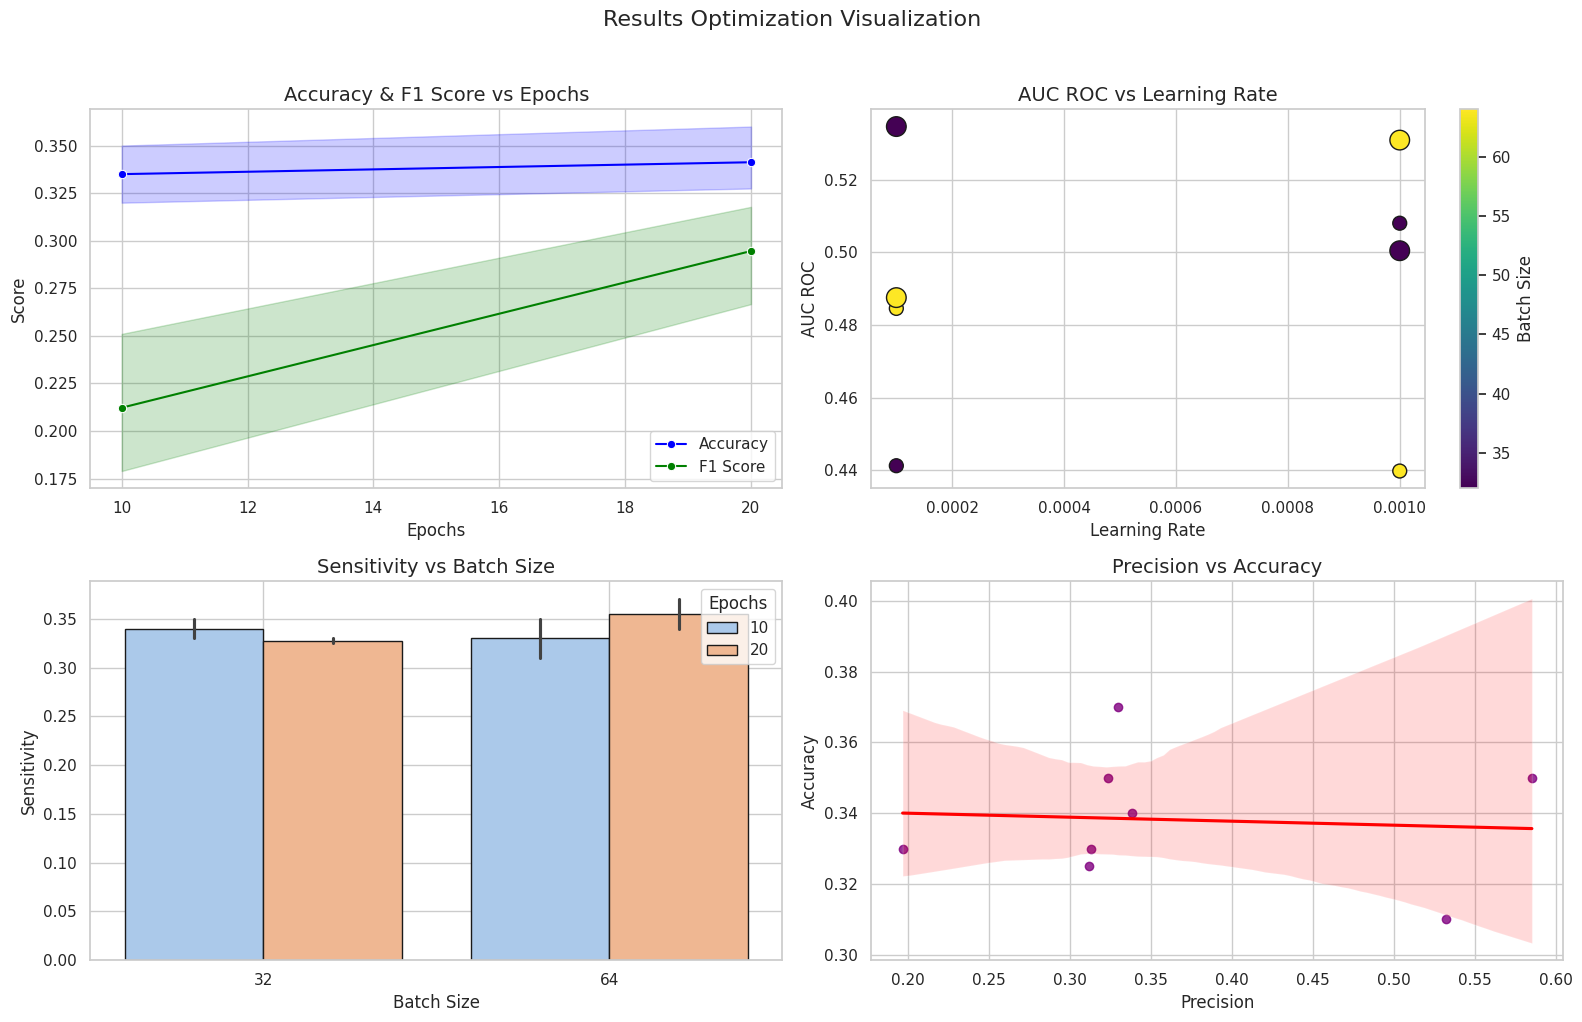

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dosyayı yükle
file_path = '/content/drive/MyDrive/results_optimation.csv'
data = pd.read_csv(file_path)

# İlk birkaç satıra göz atalım
data.head(), data.info()

# Grafik boyutlarını ve genel stil ayarlarını belirleyin
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik boyutlarını ve genel stil ayarlarını belirleyin
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 10))

# Subplot 1: Epochs'e göre Accuracy ve F1 Score
plt.subplot(2, 2, 1)
sns.lineplot(data=data, x="Epochs", y="Accuracy", label="Accuracy", marker="o", color="blue")
sns.lineplot(data=data, x="Epochs", y="F1 Score", label="F1 Score", marker="o", color="green")
plt.title("Accuracy & F1 Score vs Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend()
plt.grid(True)

# Subplot 2: Learning Rate'e göre AUC ROC (colorbar düzeltmesiyle)
plt.subplot(2, 2, 2)
scatter = plt.scatter(
    data["Learning Rate"],
    data["AUC ROC"],
    c=data["Batch Size"],
    s=data["Epochs"] * 10,  # Boyutu Epochs ile ilişkilendir
    cmap="viridis",
    edgecolor="k"
)
plt.title("AUC ROC vs Learning Rate", fontsize=14)
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("AUC ROC", fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label("Batch Size")
plt.grid(True)

# Subplot 3: Sensitivity ve Precision karşılaştırması
plt.subplot(2, 2, 3)
sns.barplot(data=data, x="Batch Size", y="Sensitivity", hue="Epochs", palette="pastel", edgecolor="k")
plt.title("Sensitivity vs Batch Size", fontsize=14)
plt.xlabel("Batch Size", fontsize=12)
plt.ylabel("Sensitivity", fontsize=12)
plt.legend(title="Epochs")
plt.grid(True)

# Subplot 4: Precision ve Accuracy arasındaki ilişki
plt.subplot(2, 2, 4)
sns.regplot(data=data, x="Precision", y="Accuracy", scatter_kws={'color': 'purple'}, line_kws={'color': 'red'})
plt.title("Precision vs Accuracy", fontsize=14)
plt.xlabel("Precision", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)

# Genel başlık ve gösterim
plt.suptitle("Results Optimization Visualization", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


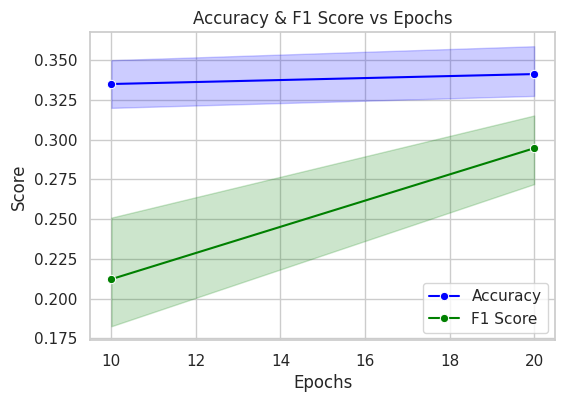

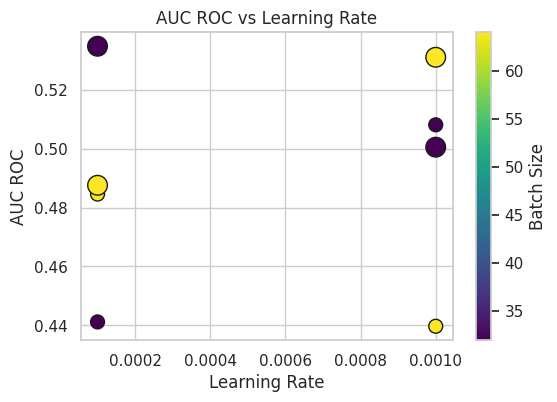

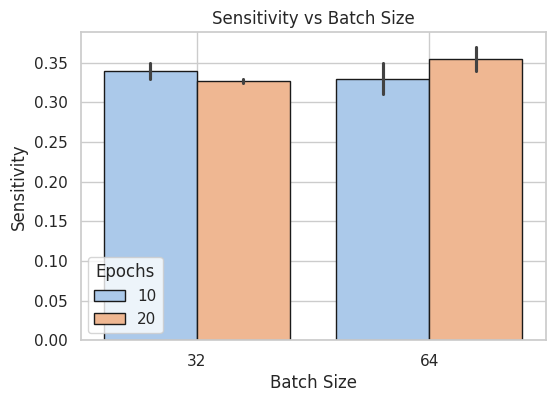

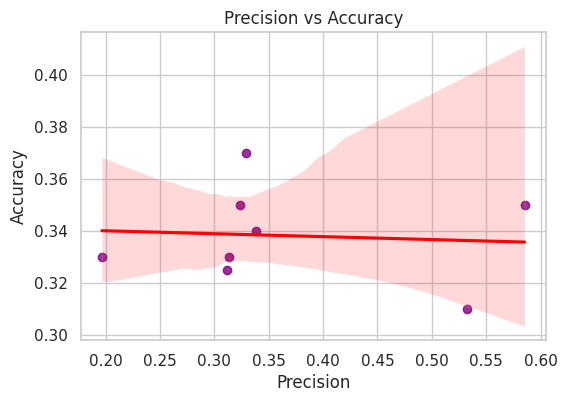

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dosyayı yükle
file_path = '/content/drive/MyDrive/results_optimation.csv'
data = pd.read_csv(file_path)

# Genel stil ayarları
sns.set_theme(style="whitegrid")

# 1. Grafik: Epochs'e göre Accuracy ve F1 Score
plt.figure(figsize=(6, 4))
sns.lineplot(data=data, x="Epochs", y="Accuracy", label="Accuracy", marker="o", color="blue")
sns.lineplot(data=data, x="Epochs", y="F1 Score", label="F1 Score", marker="o", color="green")
plt.title("Accuracy & F1 Score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_f1_vs_epochs.png")  # Kaydet
plt.show()

# 2. Grafik: Learning Rate'e göre AUC ROC
plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    data["Learning Rate"],
    data["AUC ROC"],
    c=data["Batch Size"],
    s=data["Epochs"] * 10,
    cmap="viridis",
    edgecolor="k"
)
plt.title("AUC ROC vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("AUC ROC")
cbar = plt.colorbar(scatter)
cbar.set_label("Batch Size")
plt.grid(True)
plt.savefig("auc_vs_learning_rate.png")  # Kaydet
plt.show()

# 3. Grafik: Sensitivity vs Batch Size
plt.figure(figsize=(6, 4))
sns.barplot(data=data, x="Batch Size", y="Sensitivity", hue="Epochs", palette="pastel", edgecolor="k")
plt.title("Sensitivity vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Sensitivity")
plt.legend(title="Epochs")
plt.grid(True)
plt.savefig("sensitivity_vs_batch.png")  # Kaydet
plt.show()

# 4. Grafik: Precision vs Accuracy
plt.figure(figsize=(6, 4))
sns.regplot(data=data, x="Precision", y="Accuracy", scatter_kws={'color': 'purple'}, line_kws={'color': 'red'})
plt.title("Precision vs Accuracy")
plt.xlabel("Precision")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("precision_vs_accuracy.png")  # Kaydet
plt.show()
